In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Gaussian process models for stellar variability

When fitting exoplanets, we also need to fit for the stellar variability and Gaussian Processes (GPs) are often a good descriptive model for this variation.
[PyMC3 has support for all sorts of general GP models](https://docs.pymc.io/gp.html), but *exoplanet* includes support for scalable 1D GPs (see :ref:`gp` for more info) that can work with large datasets.
In this tutorial, we go through the process of modeling the light curve of a rotating star observed by Kepler using *exoplanet*.

First, let's download and plot the data:

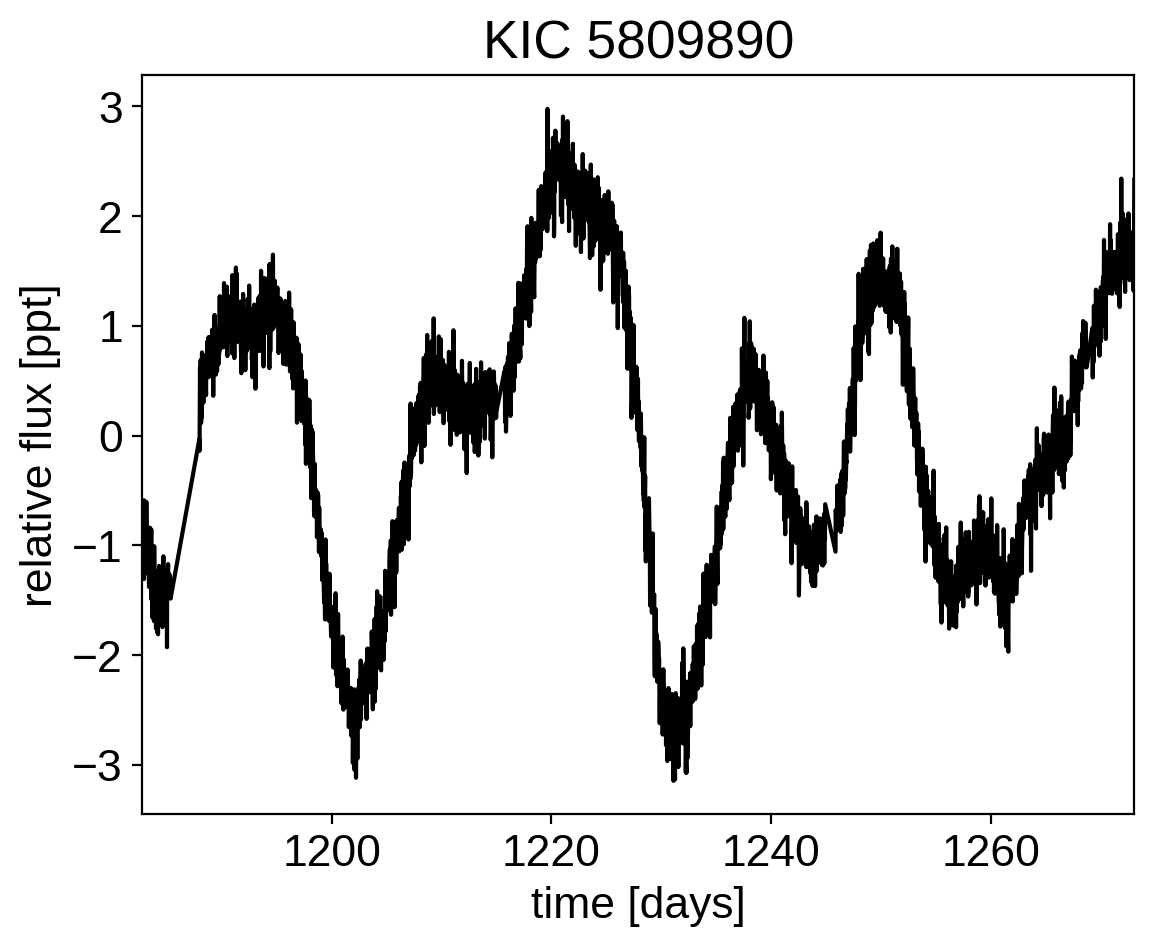

In [3]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

lcf = lk.search_lightcurvefile("KIC 5809890", quarter=13).download(
    quality_bitmask="hardest"
)
lc = lcf.PDCSAP_FLUX.normalize().remove_nans().remove_outliers()

x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err, dtype=np.float64)
mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

plt.plot(x, y, "k")
plt.xlim(x.min(), x.max())
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890");

## A Gaussian process model for stellar variability

This looks like the light curve of a rotating star, and [it has been shown](https://arxiv.org/abs/1706.05459) that it is possible to model this variability by using a quasiperiodic Gaussian process.
To start with, let's get an estimate of the rotation period using the Lomb-Scargle periodogram:

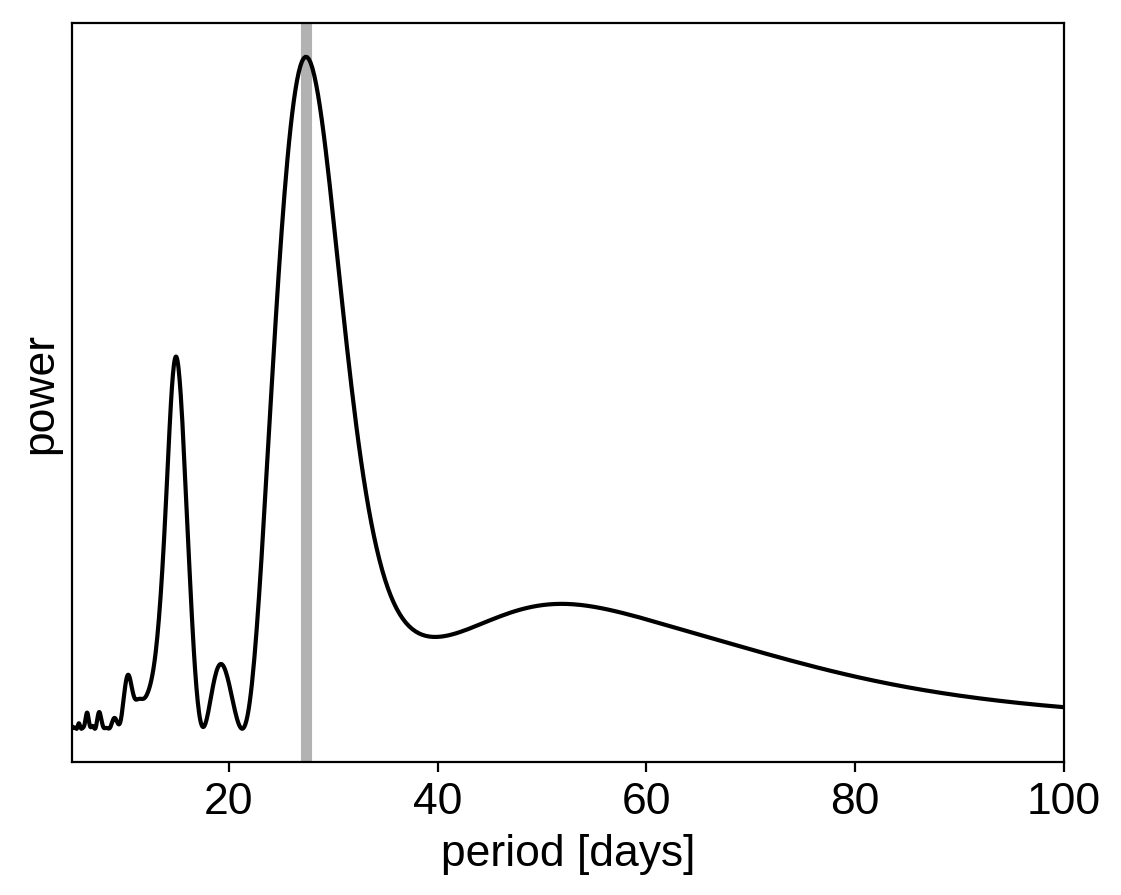

In [4]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=5.0, max_period=100.0, samples_per_peak=50
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
plt.ylabel("power");

Now, using this initialization, we can set up the GP model in *exoplanet*.
We'll use the :class:`exoplanet.gp.terms.RotationTerm` kernel that is a mixture of two simple harmonic oscillators with periods separated by a factor of two.
As you can see from the periodogram above, this might be a good model for this light curve and I've found that it works well in many cases.

In [5]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sd=10.0)

    # A jitter term describing excess white noise
    logs2 = pm.Normal("logs2", mu=2 * np.log(np.mean(yerr)), sd=2.0)

    # A term to describe the non-periodic variability
    logSw4 = pm.Normal("logSw4", mu=np.log(np.var(y)), sd=5.0)
    logw0 = pm.Normal("logw0", mu=np.log(2 * np.pi / 10), sd=5.0)

    # The parameters of the RotationTerm kernel
    logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0, upper=np.log(50))
    logperiod = BoundedNormal("logperiod", mu=np.log(peak["period"]), sd=5.0)
    logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
    logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
    mix = xo.distributions.UnitUniform("mix")

    # Track the period as a deterministic
    period = pm.Deterministic("period", tt.exp(logperiod))

    # Set up the Gaussian Process model
    kernel = xo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, Q=1 / np.sqrt(2))
    kernel += xo.gp.terms.RotationTerm(
        log_amp=logamp, period=period, log_Q0=logQ0, log_deltaQ=logdeltaQ, mix=mix
    )
    gp = xo.gp.GP(kernel, x, yerr ** 2 + tt.exp(logs2))

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    pm.Potential("loglike", gp.log_likelihood(y - mean))

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict())

    # Optimize to find the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.672569e+02]

1it [00:00, 63.87it/s, logp=2.672569e+02]

2it [00:00, 93.46it/s, logp=2.672569e+02]

3it [00:00, 109.16it/s, logp=5.136323e+02]

4it [00:00, 119.26it/s, logp=1.156425e+02]

5it [00:00, 128.48it/s, logp=5.979256e+02]

6it [00:00, 134.56it/s, logp=5.714984e+02]

7it [00:00, 140.01it/s, logp=6.326147e+02]

8it [00:00, 143.57it/s, logp=6.068474e+02]

9it [00:00, 146.97it/s, logp=6.417452e+02]

10it [00:00, 149.57it/s, logp=6.581322e+02]

11it [00:00, 151.58it/s, logp=6.674794e+02]

12it [00:00, 153.31it/s, logp=6.613014e+02]

13it [00:00, 154.85it/s, logp=6.757355e+02]

14it [00:00, 156.09it/s, logp=6.789136e+02]

15it [00:00, 157.09it/s, logp=6.838594e+02]

16it [00:00, 158.13it/s, logp=6.861378e+02]

17it [00:00, 166.70it/s, logp=6.861378e+02]

17it [00:00, 166.70it/s, logp=6.865861e+02]

18it [00:00, 166.70it/s, logp=6.871456e+02]

19it [00:00, 166.70it/s, logp=6.876705e+02]

20it [00:00, 166.70it/s, logp=6.876475e+02]

21it [00:00, 166.70it/s, logp=6.878897e+02]

22it [00:00, 166.70it/s, logp=6.881082e+02]

23it [00:00, 166.70it/s, logp=6.885047e+02]

24it [00:00, 166.70it/s, logp=6.891367e+02]

25it [00:00, 166.70it/s, logp=6.901976e+02]

26it [00:00, 166.70it/s, logp=6.909579e+02]

27it [00:00, 166.70it/s, logp=6.916029e+02]

28it [00:00, 166.70it/s, logp=6.920778e+02]

29it [00:00, 166.70it/s, logp=6.924232e+02]

30it [00:00, 166.70it/s, logp=6.931738e+02]

31it [00:00, 166.70it/s, logp=6.904344e+02]

32it [00:00, 166.70it/s, logp=6.938591e+02]

33it [00:00, 166.70it/s, logp=6.905932e+02]

34it [00:00, 166.70it/s, logp=6.946126e+02]

35it [00:00, 169.45it/s, logp=6.946126e+02]

35it [00:00, 169.45it/s, logp=6.956241e+02]

36it [00:00, 169.45it/s, logp=6.968903e+02]

37it [00:00, 169.45it/s, logp=6.985163e+02]

38it [00:00, 169.45it/s, logp=6.996495e+02]

39it [00:00, 169.45it/s, logp=6.999613e+02]

40it [00:00, 169.45it/s, logp=7.002774e+02]

41it [00:00, 169.45it/s, logp=7.005226e+02]

42it [00:00, 169.45it/s, logp=7.006902e+02]

43it [00:00, 169.45it/s, logp=7.009343e+02]

44it [00:00, 169.45it/s, logp=7.010994e+02]

45it [00:00, 169.45it/s, logp=7.012373e+02]

46it [00:00, 169.45it/s, logp=7.013984e+02]

47it [00:00, 149.28it/s, logp=7.013984e+02]

47it [00:00, 149.28it/s, logp=7.014793e+02]

48it [00:00, 149.28it/s, logp=7.015101e+02]

49it [00:00, 149.28it/s, logp=7.015674e+02]

50it [00:00, 149.28it/s, logp=7.016709e+02]

51it [00:00, 149.28it/s, logp=7.018427e+02]

52it [00:00, 149.28it/s, logp=7.020861e+02]

53it [00:00, 149.28it/s, logp=7.023415e+02]

54it [00:00, 149.28it/s, logp=7.026723e+02]

55it [00:00, 149.28it/s, logp=7.025339e+02]

56it [00:00, 149.28it/s, logp=7.014986e+02]

57it [00:00, 149.28it/s, logp=7.026330e+02]

58it [00:00, 149.28it/s, logp=7.020678e+02]

59it [00:00, 149.28it/s, logp=7.026833e+02]

60it [00:00, 149.28it/s, logp=7.026669e+02]

61it [00:00, 144.74it/s, logp=7.026669e+02]

61it [00:00, 144.74it/s, logp=7.027172e+02]

62it [00:00, 144.74it/s, logp=7.027824e+02]

63it [00:00, 144.74it/s, logp=7.029731e+02]

64it [00:00, 144.74it/s, logp=7.029217e+02]

65it [00:00, 144.74it/s, logp=7.030916e+02]

66it [00:00, 144.74it/s, logp=7.031036e+02]

67it [00:00, 144.74it/s, logp=7.031254e+02]

68it [00:00, 144.74it/s, logp=7.031583e+02]

69it [00:00, 144.74it/s, logp=7.031682e+02]

70it [00:00, 144.74it/s, logp=7.031690e+02]

71it [00:00, 144.74it/s, logp=7.031699e+02]

72it [00:00, 130.52it/s, logp=7.031699e+02]

72it [00:00, 130.52it/s, logp=7.031712e+02]

73it [00:00, 130.52it/s, logp=7.031722e+02]

74it [00:00, 130.52it/s, logp=7.031724e+02]

75it [00:00, 130.52it/s, logp=7.031724e+02]

76it [00:00, 130.52it/s, logp=7.031724e+02]

77it [00:00, 130.52it/s, logp=7.031724e+02]

78it [00:00, 130.52it/s, logp=7.031724e+02]

79it [00:00, 130.52it/s, logp=7.031724e+02]

80it [00:00, 130.52it/s, logp=7.031724e+02]

81it [00:00, 130.52it/s, logp=7.031724e+02]

82it [00:00, 130.52it/s, logp=7.031724e+02]

83it [00:00, 130.52it/s, logp=7.031724e+02]

84it [00:00, 130.52it/s, logp=7.031724e+02]

85it [00:00, 130.52it/s, logp=7.031724e+02]

86it [00:00, 130.52it/s, logp=7.031724e+02]

87it [00:00, 130.52it/s, logp=7.031724e+02]

88it [00:00, 136.38it/s, logp=7.031724e+02]

88it [00:00, 136.38it/s, logp=7.031724e+02]

89it [00:00, 136.38it/s, logp=7.031724e+02]

90it [00:00, 136.38it/s, logp=7.031724e+02]

91it [00:00, 136.38it/s, logp=7.031724e+02]

92it [00:00, 136.38it/s, logp=7.031724e+02]

93it [00:00, 136.38it/s, logp=7.031724e+02]

94it [00:00, 136.38it/s, logp=7.031724e+02]

95it [00:00, 136.38it/s, logp=7.031724e+02]

96it [00:00, 136.38it/s, logp=7.031724e+02]

97it [00:00, 136.38it/s, logp=7.031724e+02]

98it [00:00, 136.38it/s, logp=7.031724e+02]

99it [00:00, 136.38it/s, logp=7.031724e+02]

100it [00:00, 136.38it/s, logp=7.031724e+02]

101it [00:00, 136.38it/s, logp=7.031724e+02]

102it [00:00, 136.38it/s, logp=7.031724e+02]

103it [00:00, 136.38it/s, logp=7.031724e+02]

104it [00:00, 136.38it/s, logp=7.031724e+02]

105it [00:00, 136.38it/s, logp=7.031724e+02]

106it [00:00, 146.19it/s, logp=7.031724e+02]

106it [00:00, 146.19it/s, logp=7.031724e+02]

107it [00:00, 146.19it/s, logp=7.031724e+02]

108it [00:00, 146.19it/s, logp=7.031724e+02]

109it [00:00, 146.19it/s, logp=7.031724e+02]

110it [00:00, 146.19it/s, logp=7.031724e+02]

111it [00:00, 146.19it/s, logp=7.031724e+02]

112it [00:00, 146.19it/s, logp=7.031724e+02]

113it [00:00, 146.19it/s, logp=7.031724e+02]

114it [00:00, 146.19it/s, logp=7.031724e+02]

115it [00:00, 146.19it/s, logp=7.031724e+02]

116it [00:00, 146.19it/s, logp=7.031724e+02]

117it [00:00, 146.19it/s, logp=7.031724e+02]

118it [00:00, 146.19it/s, logp=7.031724e+02]

119it [00:00, 146.19it/s, logp=7.031724e+02]

120it [00:00, 146.19it/s, logp=7.031724e+02]

121it [00:00, 146.19it/s, logp=7.031724e+02]

122it [00:00, 146.19it/s, logp=7.031724e+02]

123it [00:00, 146.19it/s, logp=7.031724e+02]

124it [00:00, 154.86it/s, logp=7.031724e+02]

124it [00:00, 154.86it/s, logp=7.031724e+02]

125it [00:00, 154.86it/s, logp=7.031724e+02]

126it [00:00, 154.86it/s, logp=7.031724e+02]

127it [00:00, 154.86it/s, logp=7.031724e+02]

128it [00:00, 154.86it/s, logp=7.031724e+02]

129it [00:00, 154.86it/s, logp=7.031724e+02]

130it [00:00, 154.86it/s, logp=7.031724e+02]

131it [00:00, 154.86it/s, logp=7.031724e+02]

132it [00:00, 154.86it/s, logp=7.031724e+02]

133it [00:00, 154.86it/s, logp=7.031724e+02]

134it [00:00, 154.86it/s, logp=7.031724e+02]

135it [00:00, 154.86it/s, logp=7.031724e+02]

136it [00:00, 154.86it/s, logp=7.031724e+02]

137it [00:00, 154.86it/s, logp=7.031724e+02]

138it [00:00, 154.86it/s, logp=7.031724e+02]

139it [00:00, 154.86it/s, logp=7.031724e+02]

140it [00:00, 152.67it/s, logp=7.031724e+02]

140it [00:00, 152.67it/s, logp=7.031724e+02]

141it [00:00, 152.67it/s, logp=7.031724e+02]

142it [00:00, 152.67it/s, logp=7.031724e+02]

143it [00:00, 152.67it/s, logp=7.031724e+02]

144it [00:00, 152.67it/s, logp=7.031724e+02]

145it [00:00, 152.67it/s, logp=7.031724e+02]

146it [00:00, 152.67it/s, logp=7.031724e+02]

147it [00:00, 152.67it/s, logp=7.031724e+02]

148it [00:00, 152.67it/s, logp=7.031724e+02]

149it [00:00, 152.67it/s, logp=7.031724e+02]

150it [00:00, 152.67it/s, logp=7.031724e+02]

151it [00:00, 152.67it/s, logp=7.031724e+02]

152it [00:01, 152.67it/s, logp=7.031724e+02]

153it [00:01, 152.67it/s, logp=7.031724e+02]

154it [00:01, 152.67it/s, logp=7.031724e+02]

155it [00:01, 152.67it/s, logp=7.031724e+02]

156it [00:01, 152.67it/s, logp=7.031724e+02]

157it [00:01, 152.67it/s, logp=7.031724e+02]

158it [00:01, 159.94it/s, logp=7.031724e+02]

158it [00:01, 159.94it/s, logp=7.031724e+02]

159it [00:01, 159.94it/s, logp=7.031724e+02]

160it [00:01, 159.94it/s, logp=7.031724e+02]

161it [00:01, 159.94it/s, logp=7.031724e+02]

162it [00:01, 159.94it/s, logp=7.031724e+02]

163it [00:11, 13.59it/s, logp=7.031724e+02] 


message: Desired error not necessarily achieved due to precision loss.
logp: 267.25686032200514 -> 703.1723809089232


Now that we have the model set up, let's plot the maximum a posteriori model prediction.

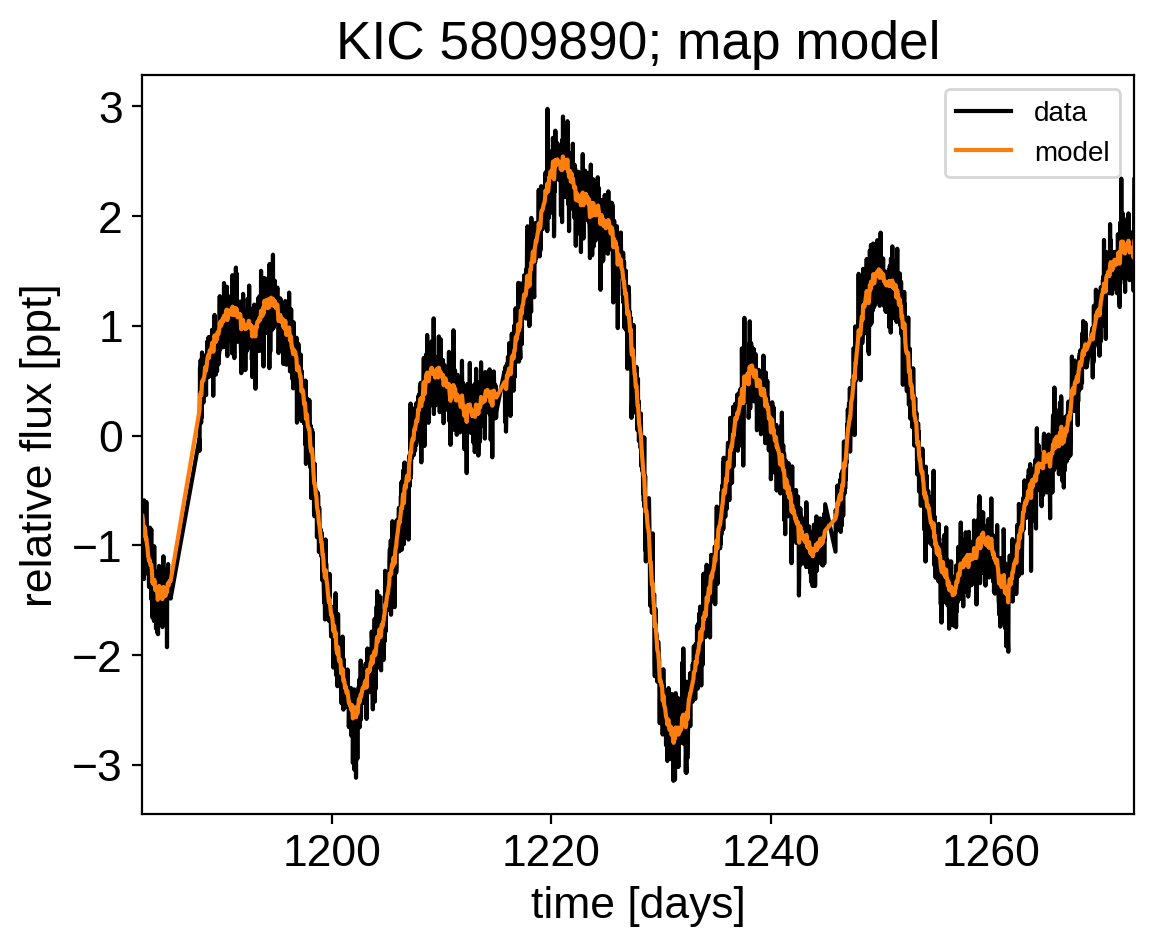

In [6]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890; map model");

That looks pretty good!
Now let's sample from the posterior using :func:`exoplanet.get_dense_nuts_step`.

In [7]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=2000,
        draws=2000,
        start=map_soln,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [mix, logdeltaQ, logQ0, logperiod, logamp, logw0, logSw4, logs2, mean]


Sampling 4 chains:   0%|          | 0/16000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/16000 [00:00<10:27, 25.50draws/s]

Sampling 4 chains:   0%|          | 10/16000 [00:00<43:44,  6.09draws/s]

Sampling 4 chains:   0%|          | 11/16000 [00:01<50:25,  5.28draws/s]

Sampling 4 chains:   0%|          | 13/16000 [00:01<45:57,  5.80draws/s]

Sampling 4 chains:   0%|          | 15/16000 [00:01<42:08,  6.32draws/s]

Sampling 4 chains:   0%|          | 16/16000 [00:01<56:32,  4.71draws/s]

Sampling 4 chains:   0%|          | 17/16000 [00:02<57:33,  4.63draws/s]

Sampling 4 chains:   0%|          | 19/16000 [00:02<47:51,  5.57draws/s]

Sampling 4 chains:   0%|          | 20/16000 [00:02<57:39,  4.62draws/s]

Sampling 4 chains:   0%|          | 21/16000 [00:02<1:06:10,  4.02draws/s]

Sampling 4 chains:   0%|          | 22/16000 [00:03<1:00:21,  4.41draws/s]

Sampling 4 chains:   0%|          | 24/16000 [00:03<53:26,  4.98draws/s]  

Sampling 4 chains:   0%|          | 25/16000 [00:03<1:00:39,  4.39draws/s]

Sampling 4 chains:   0%|          | 26/16000 [00:03<1:03:19,  4.20draws/s]

Sampling 4 chains:   0%|          | 28/16000 [00:04<54:05,  4.92draws/s]  

Sampling 4 chains:   0%|          | 30/16000 [00:04<52:46,  5.04draws/s]

Sampling 4 chains:   0%|          | 31/16000 [00:04<47:53,  5.56draws/s]

Sampling 4 chains:   0%|          | 32/16000 [00:05<56:39,  4.70draws/s]

Sampling 4 chains:   0%|          | 34/16000 [00:05<47:58,  5.55draws/s]

Sampling 4 chains:   0%|          | 36/16000 [00:05<43:16,  6.15draws/s]

Sampling 4 chains:   0%|          | 37/16000 [00:05<40:44,  6.53draws/s]

Sampling 4 chains:   0%|          | 38/16000 [00:05<42:23,  6.28draws/s]

Sampling 4 chains:   0%|          | 40/16000 [00:05<34:37,  7.68draws/s]

Sampling 4 chains:   0%|          | 41/16000 [00:06<48:45,  5.46draws/s]

Sampling 4 chains:   0%|          | 42/16000 [00:06<1:03:31,  4.19draws/s]

Sampling 4 chains:   0%|          | 44/16000 [00:06<52:08,  5.10draws/s]  

Sampling 4 chains:   0%|          | 47/16000 [00:06<39:35,  6.71draws/s]

Sampling 4 chains:   0%|          | 49/16000 [00:07<34:47,  7.64draws/s]

Sampling 4 chains:   0%|          | 51/16000 [00:07<39:32,  6.72draws/s]

Sampling 4 chains:   0%|          | 53/16000 [00:07<46:21,  5.73draws/s]

Sampling 4 chains:   0%|          | 54/16000 [00:08<42:22,  6.27draws/s]

Sampling 4 chains:   0%|          | 56/16000 [00:08<35:16,  7.53draws/s]

Sampling 4 chains:   0%|          | 58/16000 [00:08<35:20,  7.52draws/s]

Sampling 4 chains:   0%|          | 59/16000 [00:08<46:26,  5.72draws/s]

Sampling 4 chains:   0%|          | 61/16000 [00:08<42:41,  6.22draws/s]

Sampling 4 chains:   0%|          | 62/16000 [00:09<41:09,  6.46draws/s]

Sampling 4 chains:   0%|          | 63/16000 [00:09<57:46,  4.60draws/s]

Sampling 4 chains:   0%|          | 65/16000 [00:09<55:50,  4.76draws/s]

Sampling 4 chains:   0%|          | 66/16000 [00:09<49:08,  5.40draws/s]

Sampling 4 chains:   0%|          | 67/16000 [00:10<44:19,  5.99draws/s]

Sampling 4 chains:   0%|          | 68/16000 [00:10<44:22,  5.98draws/s]

Sampling 4 chains:   0%|          | 69/16000 [00:10<45:51,  5.79draws/s]

Sampling 4 chains:   0%|          | 72/16000 [00:11<53:43,  4.94draws/s]

Sampling 4 chains:   0%|          | 76/16000 [00:11<45:15,  5.86draws/s]

Sampling 4 chains:   0%|          | 77/16000 [00:11<44:59,  5.90draws/s]

Sampling 4 chains:   0%|          | 79/16000 [00:12<49:04,  5.41draws/s]

Sampling 4 chains:   0%|          | 80/16000 [00:12<44:24,  5.97draws/s]

Sampling 4 chains:   1%|          | 82/16000 [00:12<47:48,  5.55draws/s]

Sampling 4 chains:   1%|          | 83/16000 [00:12<46:33,  5.70draws/s]

Sampling 4 chains:   1%|          | 84/16000 [00:13<40:55,  6.48draws/s]

Sampling 4 chains:   1%|          | 85/16000 [00:13<48:08,  5.51draws/s]

Sampling 4 chains:   1%|          | 87/16000 [00:13<39:01,  6.79draws/s]

Sampling 4 chains:   1%|          | 88/16000 [00:14<1:15:31,  3.51draws/s]

Sampling 4 chains:   1%|          | 90/16000 [00:14<1:03:19,  4.19draws/s]

Sampling 4 chains:   1%|          | 94/16000 [00:14<47:06,  5.63draws/s]  

Sampling 4 chains:   1%|          | 96/16000 [00:14<53:56,  4.91draws/s]

Sampling 4 chains:   1%|          | 98/16000 [00:15<55:25,  4.78draws/s]

Sampling 4 chains:   1%|          | 102/16000 [00:15<43:18,  6.12draws/s]

Sampling 4 chains:   1%|          | 104/16000 [00:15<35:29,  7.46draws/s]

Sampling 4 chains:   1%|          | 106/16000 [00:16<44:09,  6.00draws/s]

Sampling 4 chains:   1%|          | 108/16000 [00:16<39:42,  6.67draws/s]

Sampling 4 chains:   1%|          | 109/16000 [00:16<54:55,  4.82draws/s]

Sampling 4 chains:   1%|          | 110/16000 [00:16<47:30,  5.57draws/s]

Sampling 4 chains:   1%|          | 111/16000 [00:17<59:28,  4.45draws/s]

Sampling 4 chains:   1%|          | 112/16000 [00:17<59:41,  4.44draws/s]

Sampling 4 chains:   1%|          | 113/16000 [00:17<1:05:07,  4.07draws/s]

Sampling 4 chains:   1%|          | 114/16000 [00:17<55:32,  4.77draws/s]  

Sampling 4 chains:   1%|          | 117/16000 [00:18<45:48,  5.78draws/s]

Sampling 4 chains:   1%|          | 119/16000 [00:18<42:13,  6.27draws/s]

Sampling 4 chains:   1%|          | 121/16000 [00:18<37:05,  7.13draws/s]

Sampling 4 chains:   1%|          | 122/16000 [00:18<41:05,  6.44draws/s]

Sampling 4 chains:   1%|          | 123/16000 [00:19<44:59,  5.88draws/s]

Sampling 4 chains:   1%|          | 124/16000 [00:19<1:02:33,  4.23draws/s]

Sampling 4 chains:   1%|          | 126/16000 [00:19<49:27,  5.35draws/s]  

Sampling 4 chains:   1%|          | 127/16000 [00:19<48:58,  5.40draws/s]

Sampling 4 chains:   1%|          | 129/16000 [00:19<41:29,  6.38draws/s]

Sampling 4 chains:   1%|          | 132/16000 [00:20<32:01,  8.26draws/s]

Sampling 4 chains:   1%|          | 134/16000 [00:20<38:14,  6.91draws/s]

Sampling 4 chains:   1%|          | 136/16000 [00:20<43:09,  6.13draws/s]

Sampling 4 chains:   1%|          | 137/16000 [00:20<38:27,  6.87draws/s]

Sampling 4 chains:   1%|          | 138/16000 [00:21<36:45,  7.19draws/s]

Sampling 4 chains:   1%|          | 139/16000 [00:21<34:36,  7.64draws/s]

Sampling 4 chains:   1%|          | 141/16000 [00:21<35:40,  7.41draws/s]

Sampling 4 chains:   1%|          | 142/16000 [00:21<34:46,  7.60draws/s]

Sampling 4 chains:   1%|          | 143/16000 [00:21<44:28,  5.94draws/s]

Sampling 4 chains:   1%|          | 145/16000 [00:22<41:22,  6.39draws/s]

Sampling 4 chains:   1%|          | 146/16000 [00:22<37:26,  7.06draws/s]

Sampling 4 chains:   1%|          | 147/16000 [00:22<37:28,  7.05draws/s]

Sampling 4 chains:   1%|          | 149/16000 [00:22<36:35,  7.22draws/s]

Sampling 4 chains:   1%|          | 150/16000 [00:22<49:50,  5.30draws/s]

Sampling 4 chains:   1%|          | 151/16000 [00:23<52:42,  5.01draws/s]

Sampling 4 chains:   1%|          | 152/16000 [00:23<45:29,  5.81draws/s]

Sampling 4 chains:   1%|          | 153/16000 [00:23<48:13,  5.48draws/s]

Sampling 4 chains:   1%|          | 154/16000 [00:23<51:09,  5.16draws/s]

Sampling 4 chains:   1%|          | 157/16000 [00:24<50:51,  5.19draws/s]

Sampling 4 chains:   1%|          | 158/16000 [00:24<52:11,  5.06draws/s]

Sampling 4 chains:   1%|          | 160/16000 [00:24<40:45,  6.48draws/s]

Sampling 4 chains:   1%|          | 161/16000 [00:24<45:28,  5.81draws/s]

Sampling 4 chains:   1%|          | 163/16000 [00:25<40:25,  6.53draws/s]

Sampling 4 chains:   1%|          | 166/16000 [00:25<41:53,  6.30draws/s]

Sampling 4 chains:   1%|          | 167/16000 [00:25<38:58,  6.77draws/s]

Sampling 4 chains:   1%|          | 168/16000 [00:25<39:05,  6.75draws/s]

Sampling 4 chains:   1%|          | 169/16000 [00:25<35:33,  7.42draws/s]

Sampling 4 chains:   1%|          | 170/16000 [00:26<35:14,  7.49draws/s]

Sampling 4 chains:   1%|          | 172/16000 [00:26<35:19,  7.47draws/s]

Sampling 4 chains:   1%|          | 175/16000 [00:26<28:11,  9.35draws/s]

Sampling 4 chains:   1%|          | 177/16000 [00:26<26:33,  9.93draws/s]

Sampling 4 chains:   1%|          | 179/16000 [00:26<28:48,  9.16draws/s]

Sampling 4 chains:   1%|          | 181/16000 [00:27<29:50,  8.83draws/s]

Sampling 4 chains:   1%|          | 185/16000 [00:27<27:20,  9.64draws/s]

Sampling 4 chains:   1%|          | 187/16000 [00:27<28:09,  9.36draws/s]

Sampling 4 chains:   1%|          | 189/16000 [00:27<29:58,  8.79draws/s]

Sampling 4 chains:   1%|          | 190/16000 [00:28<41:32,  6.34draws/s]

Sampling 4 chains:   1%|          | 193/16000 [00:28<32:25,  8.13draws/s]

Sampling 4 chains:   1%|          | 195/16000 [00:28<32:15,  8.17draws/s]

Sampling 4 chains:   1%|          | 197/16000 [00:28<32:49,  8.02draws/s]

Sampling 4 chains:   1%|          | 199/16000 [00:29<43:51,  6.00draws/s]

Sampling 4 chains:   1%|▏         | 200/16000 [00:29<46:09,  5.71draws/s]

Sampling 4 chains:   1%|▏         | 202/16000 [00:29<41:13,  6.39draws/s]

Sampling 4 chains:   1%|▏         | 204/16000 [00:29<35:55,  7.33draws/s]

Sampling 4 chains:   1%|▏         | 205/16000 [00:30<39:25,  6.68draws/s]

Sampling 4 chains:   1%|▏         | 206/16000 [00:30<47:20,  5.56draws/s]

Sampling 4 chains:   1%|▏         | 209/16000 [00:30<42:05,  6.25draws/s]

Sampling 4 chains:   1%|▏         | 210/16000 [00:30<49:00,  5.37draws/s]

Sampling 4 chains:   1%|▏         | 212/16000 [00:31<38:54,  6.76draws/s]

Sampling 4 chains:   1%|▏         | 214/16000 [00:31<35:23,  7.43draws/s]

Sampling 4 chains:   1%|▏         | 215/16000 [00:31<40:41,  6.46draws/s]

Sampling 4 chains:   1%|▏         | 216/16000 [00:31<41:40,  6.31draws/s]

Sampling 4 chains:   1%|▏         | 218/16000 [00:31<34:36,  7.60draws/s]

Sampling 4 chains:   1%|▏         | 219/16000 [00:31<37:00,  7.11draws/s]

Sampling 4 chains:   1%|▏         | 220/16000 [00:32<51:31,  5.10draws/s]

Sampling 4 chains:   1%|▏         | 224/16000 [00:32<41:44,  6.30draws/s]

Sampling 4 chains:   1%|▏         | 225/16000 [00:32<37:52,  6.94draws/s]

Sampling 4 chains:   1%|▏         | 227/16000 [00:32<34:27,  7.63draws/s]

Sampling 4 chains:   1%|▏         | 229/16000 [00:33<29:54,  8.79draws/s]

Sampling 4 chains:   1%|▏         | 231/16000 [00:33<40:30,  6.49draws/s]

Sampling 4 chains:   1%|▏         | 233/16000 [00:33<32:33,  8.07draws/s]

Sampling 4 chains:   1%|▏         | 235/16000 [00:33<28:58,  9.07draws/s]

Sampling 4 chains:   1%|▏         | 237/16000 [00:34<32:48,  8.01draws/s]

Sampling 4 chains:   1%|▏         | 239/16000 [00:34<27:37,  9.51draws/s]

Sampling 4 chains:   2%|▏         | 241/16000 [00:34<26:33,  9.89draws/s]

Sampling 4 chains:   2%|▏         | 243/16000 [00:34<36:59,  7.10draws/s]

Sampling 4 chains:   2%|▏         | 244/16000 [00:34<34:30,  7.61draws/s]

Sampling 4 chains:   2%|▏         | 246/16000 [00:35<28:06,  9.34draws/s]

Sampling 4 chains:   2%|▏         | 249/16000 [00:35<26:45,  9.81draws/s]

Sampling 4 chains:   2%|▏         | 251/16000 [00:35<29:50,  8.79draws/s]

Sampling 4 chains:   2%|▏         | 253/16000 [00:35<25:29, 10.30draws/s]

Sampling 4 chains:   2%|▏         | 255/16000 [00:36<31:08,  8.43draws/s]

Sampling 4 chains:   2%|▏         | 257/16000 [00:36<32:06,  8.17draws/s]

Sampling 4 chains:   2%|▏         | 258/16000 [00:36<33:46,  7.77draws/s]

Sampling 4 chains:   2%|▏         | 260/16000 [00:36<30:28,  8.61draws/s]

Sampling 4 chains:   2%|▏         | 261/16000 [00:37<48:30,  5.41draws/s]

Sampling 4 chains:   2%|▏         | 264/16000 [00:37<37:34,  6.98draws/s]

Sampling 4 chains:   2%|▏         | 266/16000 [00:37<34:45,  7.55draws/s]

Sampling 4 chains:   2%|▏         | 268/16000 [00:37<29:47,  8.80draws/s]

Sampling 4 chains:   2%|▏         | 270/16000 [00:37<30:49,  8.51draws/s]

Sampling 4 chains:   2%|▏         | 272/16000 [00:38<31:51,  8.23draws/s]

Sampling 4 chains:   2%|▏         | 273/16000 [00:38<30:19,  8.64draws/s]

Sampling 4 chains:   2%|▏         | 275/16000 [00:38<33:56,  7.72draws/s]

Sampling 4 chains:   2%|▏         | 277/16000 [00:38<30:43,  8.53draws/s]

Sampling 4 chains:   2%|▏         | 278/16000 [00:38<29:53,  8.77draws/s]

Sampling 4 chains:   2%|▏         | 280/16000 [00:38<29:07,  8.99draws/s]

Sampling 4 chains:   2%|▏         | 281/16000 [00:39<29:10,  8.98draws/s]

Sampling 4 chains:   2%|▏         | 282/16000 [00:39<38:07,  6.87draws/s]

Sampling 4 chains:   2%|▏         | 284/16000 [00:39<31:45,  8.25draws/s]

Sampling 4 chains:   2%|▏         | 286/16000 [00:39<30:57,  8.46draws/s]

Sampling 4 chains:   2%|▏         | 287/16000 [00:39<31:44,  8.25draws/s]

Sampling 4 chains:   2%|▏         | 288/16000 [00:40<43:26,  6.03draws/s]

Sampling 4 chains:   2%|▏         | 290/16000 [00:40<34:54,  7.50draws/s]

Sampling 4 chains:   2%|▏         | 292/16000 [00:40<31:23,  8.34draws/s]

Sampling 4 chains:   2%|▏         | 294/16000 [00:40<34:19,  7.63draws/s]

Sampling 4 chains:   2%|▏         | 295/16000 [00:40<34:58,  7.48draws/s]

Sampling 4 chains:   2%|▏         | 297/16000 [00:40<28:32,  9.17draws/s]

Sampling 4 chains:   2%|▏         | 299/16000 [00:41<29:48,  8.78draws/s]

Sampling 4 chains:   2%|▏         | 301/16000 [00:41<32:12,  8.12draws/s]

Sampling 4 chains:   2%|▏         | 303/16000 [00:41<35:40,  7.33draws/s]

Sampling 4 chains:   2%|▏         | 305/16000 [00:41<34:28,  7.59draws/s]

Sampling 4 chains:   2%|▏         | 308/16000 [00:42<32:18,  8.10draws/s]

Sampling 4 chains:   2%|▏         | 310/16000 [00:42<34:09,  7.66draws/s]

Sampling 4 chains:   2%|▏         | 312/16000 [00:42<29:33,  8.84draws/s]

Sampling 4 chains:   2%|▏         | 314/16000 [00:42<27:18,  9.58draws/s]

Sampling 4 chains:   2%|▏         | 316/16000 [00:43<25:10, 10.39draws/s]

Sampling 4 chains:   2%|▏         | 318/16000 [00:43<32:14,  8.10draws/s]

Sampling 4 chains:   2%|▏         | 319/16000 [00:43<42:36,  6.13draws/s]

Sampling 4 chains:   2%|▏         | 321/16000 [00:43<35:33,  7.35draws/s]

Sampling 4 chains:   2%|▏         | 322/16000 [00:44<54:42,  4.78draws/s]

Sampling 4 chains:   2%|▏         | 326/16000 [00:44<42:30,  6.14draws/s]

Sampling 4 chains:   2%|▏         | 328/16000 [00:44<34:47,  7.51draws/s]

Sampling 4 chains:   2%|▏         | 330/16000 [00:44<36:03,  7.24draws/s]

Sampling 4 chains:   2%|▏         | 333/16000 [00:45<33:06,  7.88draws/s]

Sampling 4 chains:   2%|▏         | 337/16000 [00:45<26:13,  9.95draws/s]

Sampling 4 chains:   2%|▏         | 339/16000 [00:45<24:44, 10.55draws/s]

Sampling 4 chains:   2%|▏         | 342/16000 [00:45<22:31, 11.58draws/s]

Sampling 4 chains:   2%|▏         | 345/16000 [00:45<20:05, 12.98draws/s]

Sampling 4 chains:   2%|▏         | 347/16000 [00:46<21:25, 12.18draws/s]

Sampling 4 chains:   2%|▏         | 349/16000 [00:46<23:25, 11.13draws/s]

Sampling 4 chains:   2%|▏         | 351/16000 [00:46<22:55, 11.38draws/s]

Sampling 4 chains:   2%|▏         | 353/16000 [00:46<21:52, 11.92draws/s]

Sampling 4 chains:   2%|▏         | 355/16000 [00:46<22:10, 11.76draws/s]

Sampling 4 chains:   2%|▏         | 357/16000 [00:46<22:44, 11.46draws/s]

Sampling 4 chains:   2%|▏         | 359/16000 [00:47<21:43, 11.99draws/s]

Sampling 4 chains:   2%|▏         | 362/16000 [00:47<17:53, 14.57draws/s]

Sampling 4 chains:   2%|▏         | 366/16000 [00:47<14:32, 17.91draws/s]

Sampling 4 chains:   2%|▏         | 369/16000 [00:47<17:41, 14.73draws/s]

Sampling 4 chains:   2%|▏         | 371/16000 [00:47<17:58, 14.49draws/s]

Sampling 4 chains:   2%|▏         | 373/16000 [00:47<17:10, 15.17draws/s]

Sampling 4 chains:   2%|▏         | 377/16000 [00:48<15:42, 16.57draws/s]

Sampling 4 chains:   2%|▏         | 380/16000 [00:48<15:01, 17.33draws/s]

Sampling 4 chains:   2%|▏         | 382/16000 [00:48<15:03, 17.29draws/s]

Sampling 4 chains:   2%|▏         | 384/16000 [00:48<16:45, 15.53draws/s]

Sampling 4 chains:   2%|▏         | 386/16000 [00:48<16:36, 15.67draws/s]

Sampling 4 chains:   2%|▏         | 388/16000 [00:48<20:43, 12.56draws/s]

Sampling 4 chains:   2%|▏         | 392/16000 [00:49<19:01, 13.67draws/s]

Sampling 4 chains:   2%|▏         | 395/16000 [00:49<17:11, 15.13draws/s]

Sampling 4 chains:   2%|▏         | 397/16000 [00:49<19:54, 13.06draws/s]

Sampling 4 chains:   2%|▎         | 400/16000 [00:49<16:48, 15.47draws/s]

Sampling 4 chains:   3%|▎         | 403/16000 [00:49<14:49, 17.54draws/s]

Sampling 4 chains:   3%|▎         | 406/16000 [00:49<13:12, 19.68draws/s]

Sampling 4 chains:   3%|▎         | 409/16000 [00:49<13:13, 19.64draws/s]

Sampling 4 chains:   3%|▎         | 412/16000 [00:50<12:33, 20.68draws/s]

Sampling 4 chains:   3%|▎         | 415/16000 [00:50<16:44, 15.51draws/s]

Sampling 4 chains:   3%|▎         | 417/16000 [00:50<20:15, 12.82draws/s]

Sampling 4 chains:   3%|▎         | 419/16000 [00:50<24:32, 10.58draws/s]

Sampling 4 chains:   3%|▎         | 421/16000 [00:51<26:06,  9.95draws/s]

Sampling 4 chains:   3%|▎         | 423/16000 [00:51<22:30, 11.53draws/s]

Sampling 4 chains:   3%|▎         | 427/16000 [00:51<18:38, 13.92draws/s]

Sampling 4 chains:   3%|▎         | 429/16000 [00:51<16:59, 15.27draws/s]

Sampling 4 chains:   3%|▎         | 431/16000 [00:51<21:15, 12.20draws/s]

Sampling 4 chains:   3%|▎         | 434/16000 [00:51<18:08, 14.30draws/s]

Sampling 4 chains:   3%|▎         | 436/16000 [00:51<17:02, 15.22draws/s]

Sampling 4 chains:   3%|▎         | 438/16000 [00:52<22:27, 11.55draws/s]

Sampling 4 chains:   3%|▎         | 440/16000 [00:52<22:56, 11.31draws/s]

Sampling 4 chains:   3%|▎         | 442/16000 [00:52<21:24, 12.12draws/s]

Sampling 4 chains:   3%|▎         | 445/16000 [00:52<19:11, 13.51draws/s]

Sampling 4 chains:   3%|▎         | 447/16000 [00:52<18:41, 13.86draws/s]

Sampling 4 chains:   3%|▎         | 449/16000 [00:52<17:21, 14.93draws/s]

Sampling 4 chains:   3%|▎         | 451/16000 [00:53<17:03, 15.19draws/s]

Sampling 4 chains:   3%|▎         | 456/16000 [00:53<13:57, 18.55draws/s]

Sampling 4 chains:   3%|▎         | 460/16000 [00:53<11:55, 21.72draws/s]

Sampling 4 chains:   3%|▎         | 463/16000 [00:53<12:20, 20.99draws/s]

Sampling 4 chains:   3%|▎         | 467/16000 [00:53<11:12, 23.11draws/s]

Sampling 4 chains:   3%|▎         | 470/16000 [00:53<10:52, 23.80draws/s]

Sampling 4 chains:   3%|▎         | 473/16000 [00:53<12:27, 20.77draws/s]

Sampling 4 chains:   3%|▎         | 476/16000 [00:53<12:42, 20.37draws/s]

Sampling 4 chains:   3%|▎         | 479/16000 [00:54<12:28, 20.74draws/s]

Sampling 4 chains:   3%|▎         | 482/16000 [00:54<12:34, 20.57draws/s]

Sampling 4 chains:   3%|▎         | 485/16000 [00:54<12:28, 20.73draws/s]

Sampling 4 chains:   3%|▎         | 488/16000 [00:54<12:19, 20.98draws/s]

Sampling 4 chains:   3%|▎         | 492/16000 [00:54<11:12, 23.04draws/s]

Sampling 4 chains:   3%|▎         | 497/16000 [00:54<10:27, 24.69draws/s]

Sampling 4 chains:   3%|▎         | 500/16000 [00:54<10:33, 24.45draws/s]

Sampling 4 chains:   3%|▎         | 503/16000 [00:55<10:12, 25.28draws/s]

Sampling 4 chains:   3%|▎         | 508/16000 [00:55<09:24, 27.44draws/s]

Sampling 4 chains:   3%|▎         | 511/16000 [00:55<10:25, 24.77draws/s]

Sampling 4 chains:   3%|▎         | 514/16000 [00:55<11:13, 23.00draws/s]

Sampling 4 chains:   3%|▎         | 517/16000 [00:55<13:00, 19.85draws/s]

Sampling 4 chains:   3%|▎         | 522/16000 [00:55<11:19, 22.77draws/s]

Sampling 4 chains:   3%|▎         | 526/16000 [00:56<10:37, 24.26draws/s]

Sampling 4 chains:   3%|▎         | 529/16000 [00:56<10:57, 23.53draws/s]

Sampling 4 chains:   3%|▎         | 534/16000 [00:56<09:58, 25.82draws/s]

Sampling 4 chains:   3%|▎         | 538/16000 [00:56<09:08, 28.19draws/s]

Sampling 4 chains:   3%|▎         | 542/16000 [00:56<08:42, 29.56draws/s]

Sampling 4 chains:   3%|▎         | 546/16000 [00:56<08:26, 30.52draws/s]

Sampling 4 chains:   3%|▎         | 550/16000 [00:56<08:58, 28.69draws/s]

Sampling 4 chains:   3%|▎         | 554/16000 [00:56<08:59, 28.65draws/s]

Sampling 4 chains:   3%|▎         | 559/16000 [00:57<08:35, 29.95draws/s]

Sampling 4 chains:   4%|▎         | 563/16000 [00:57<08:00, 32.13draws/s]

Sampling 4 chains:   4%|▎         | 567/16000 [00:57<07:43, 33.30draws/s]

Sampling 4 chains:   4%|▎         | 572/16000 [00:57<08:22, 30.71draws/s]

Sampling 4 chains:   4%|▎         | 577/16000 [00:57<07:56, 32.34draws/s]

Sampling 4 chains:   4%|▎         | 582/16000 [00:57<07:37, 33.69draws/s]

Sampling 4 chains:   4%|▎         | 586/16000 [00:57<07:20, 35.00draws/s]

Sampling 4 chains:   4%|▎         | 590/16000 [00:58<09:37, 26.68draws/s]

Sampling 4 chains:   4%|▎         | 595/16000 [00:58<08:18, 30.92draws/s]

Sampling 4 chains:   4%|▎         | 599/16000 [00:58<08:05, 31.70draws/s]

Sampling 4 chains:   4%|▍         | 604/16000 [00:58<07:41, 33.36draws/s]

Sampling 4 chains:   4%|▍         | 608/16000 [00:58<08:52, 28.93draws/s]

Sampling 4 chains:   4%|▍         | 612/16000 [00:58<09:07, 28.11draws/s]

Sampling 4 chains:   4%|▍         | 616/16000 [00:58<09:29, 27.03draws/s]

Sampling 4 chains:   4%|▍         | 619/16000 [00:59<09:57, 25.75draws/s]

Sampling 4 chains:   4%|▍         | 622/16000 [00:59<10:30, 24.37draws/s]

Sampling 4 chains:   4%|▍         | 626/16000 [00:59<09:49, 26.09draws/s]

Sampling 4 chains:   4%|▍         | 630/16000 [00:59<09:35, 26.69draws/s]

Sampling 4 chains:   4%|▍         | 633/16000 [00:59<09:56, 25.76draws/s]

Sampling 4 chains:   4%|▍         | 636/16000 [00:59<10:38, 24.08draws/s]

Sampling 4 chains:   4%|▍         | 641/16000 [00:59<09:11, 27.85draws/s]

Sampling 4 chains:   4%|▍         | 645/16000 [00:59<08:23, 30.51draws/s]

Sampling 4 chains:   4%|▍         | 649/16000 [01:00<07:53, 32.42draws/s]

Sampling 4 chains:   4%|▍         | 653/16000 [01:00<10:55, 23.42draws/s]

Sampling 4 chains:   4%|▍         | 657/16000 [01:00<10:22, 24.66draws/s]

Sampling 4 chains:   4%|▍         | 661/16000 [01:00<10:04, 25.37draws/s]

Sampling 4 chains:   4%|▍         | 666/16000 [01:00<09:07, 27.98draws/s]

Sampling 4 chains:   4%|▍         | 670/16000 [01:00<09:01, 28.30draws/s]

Sampling 4 chains:   4%|▍         | 674/16000 [01:01<08:49, 28.96draws/s]

Sampling 4 chains:   4%|▍         | 678/16000 [01:01<09:22, 27.24draws/s]

Sampling 4 chains:   4%|▍         | 682/16000 [01:01<09:13, 27.67draws/s]

Sampling 4 chains:   4%|▍         | 685/16000 [01:01<10:28, 24.37draws/s]

Sampling 4 chains:   4%|▍         | 688/16000 [01:01<10:21, 24.63draws/s]

Sampling 4 chains:   4%|▍         | 692/16000 [01:01<09:13, 27.64draws/s]

Sampling 4 chains:   4%|▍         | 695/16000 [01:01<10:07, 25.20draws/s]

Sampling 4 chains:   4%|▍         | 698/16000 [01:02<10:54, 23.37draws/s]

Sampling 4 chains:   4%|▍         | 703/16000 [01:02<09:29, 26.84draws/s]

Sampling 4 chains:   4%|▍         | 707/16000 [01:02<09:43, 26.20draws/s]

Sampling 4 chains:   4%|▍         | 711/16000 [01:02<09:37, 26.46draws/s]

Sampling 4 chains:   4%|▍         | 714/16000 [01:02<09:47, 26.01draws/s]

Sampling 4 chains:   4%|▍         | 718/16000 [01:02<09:37, 26.47draws/s]

Sampling 4 chains:   5%|▍         | 723/16000 [01:02<08:19, 30.56draws/s]

Sampling 4 chains:   5%|▍         | 727/16000 [01:02<08:34, 29.70draws/s]

Sampling 4 chains:   5%|▍         | 731/16000 [01:03<08:37, 29.49draws/s]

Sampling 4 chains:   5%|▍         | 736/16000 [01:03<08:23, 30.34draws/s]

Sampling 4 chains:   5%|▍         | 741/16000 [01:03<07:29, 33.92draws/s]

Sampling 4 chains:   5%|▍         | 745/16000 [01:03<08:09, 31.19draws/s]

Sampling 4 chains:   5%|▍         | 749/16000 [01:03<08:08, 31.20draws/s]

Sampling 4 chains:   5%|▍         | 753/16000 [01:03<07:57, 31.92draws/s]

Sampling 4 chains:   5%|▍         | 757/16000 [01:03<07:32, 33.72draws/s]

Sampling 4 chains:   5%|▍         | 761/16000 [01:04<08:03, 31.51draws/s]

Sampling 4 chains:   5%|▍         | 765/16000 [01:04<08:45, 29.02draws/s]

Sampling 4 chains:   5%|▍         | 770/16000 [01:04<08:17, 30.60draws/s]

Sampling 4 chains:   5%|▍         | 774/16000 [01:04<08:02, 31.58draws/s]

Sampling 4 chains:   5%|▍         | 778/16000 [01:04<07:41, 32.97draws/s]

Sampling 4 chains:   5%|▍         | 782/16000 [01:04<08:21, 30.32draws/s]

Sampling 4 chains:   5%|▍         | 786/16000 [01:04<09:31, 26.60draws/s]

Sampling 4 chains:   5%|▍         | 789/16000 [01:05<09:22, 27.03draws/s]

Sampling 4 chains:   5%|▍         | 793/16000 [01:05<10:01, 25.26draws/s]

Sampling 4 chains:   5%|▍         | 796/16000 [01:05<10:01, 25.27draws/s]

Sampling 4 chains:   5%|▌         | 801/16000 [01:05<08:36, 29.42draws/s]

Sampling 4 chains:   5%|▌         | 805/16000 [01:05<08:37, 29.37draws/s]

Sampling 4 chains:   5%|▌         | 809/16000 [01:05<08:01, 31.53draws/s]

Sampling 4 chains:   5%|▌         | 813/16000 [01:05<07:48, 32.43draws/s]

Sampling 4 chains:   5%|▌         | 820/16000 [01:05<06:40, 37.93draws/s]

Sampling 4 chains:   5%|▌         | 825/16000 [01:06<07:10, 35.27draws/s]

Sampling 4 chains:   5%|▌         | 829/16000 [01:06<08:36, 29.38draws/s]

Sampling 4 chains:   5%|▌         | 834/16000 [01:06<08:18, 30.40draws/s]

Sampling 4 chains:   5%|▌         | 838/16000 [01:06<08:51, 28.52draws/s]

Sampling 4 chains:   5%|▌         | 842/16000 [01:06<08:37, 29.27draws/s]

Sampling 4 chains:   5%|▌         | 846/16000 [01:06<08:39, 29.16draws/s]

Sampling 4 chains:   5%|▌         | 850/16000 [01:06<08:05, 31.19draws/s]

Sampling 4 chains:   5%|▌         | 854/16000 [01:07<08:32, 29.56draws/s]

Sampling 4 chains:   5%|▌         | 858/16000 [01:07<09:07, 27.65draws/s]

Sampling 4 chains:   5%|▌         | 862/16000 [01:07<08:16, 30.46draws/s]

Sampling 4 chains:   5%|▌         | 866/16000 [01:07<08:39, 29.11draws/s]

Sampling 4 chains:   5%|▌         | 870/16000 [01:07<08:31, 29.59draws/s]

Sampling 4 chains:   5%|▌         | 874/16000 [01:07<07:55, 31.80draws/s]

Sampling 4 chains:   6%|▌         | 880/16000 [01:07<07:37, 33.07draws/s]

Sampling 4 chains:   6%|▌         | 884/16000 [01:08<07:26, 33.84draws/s]

Sampling 4 chains:   6%|▌         | 888/16000 [01:08<07:39, 32.91draws/s]

Sampling 4 chains:   6%|▌         | 893/16000 [01:08<07:17, 34.56draws/s]

Sampling 4 chains:   6%|▌         | 898/16000 [01:08<06:39, 37.84draws/s]

Sampling 4 chains:   6%|▌         | 902/16000 [01:08<06:33, 38.34draws/s]

Sampling 4 chains:   6%|▌         | 906/16000 [01:08<07:28, 33.64draws/s]

Sampling 4 chains:   6%|▌         | 910/16000 [01:08<08:02, 31.28draws/s]

Sampling 4 chains:   6%|▌         | 914/16000 [01:08<07:40, 32.75draws/s]

Sampling 4 chains:   6%|▌         | 918/16000 [01:09<07:27, 33.72draws/s]

Sampling 4 chains:   6%|▌         | 923/16000 [01:09<06:48, 36.94draws/s]

Sampling 4 chains:   6%|▌         | 927/16000 [01:09<07:01, 35.79draws/s]

Sampling 4 chains:   6%|▌         | 932/16000 [01:09<06:27, 38.84draws/s]

Sampling 4 chains:   6%|▌         | 939/16000 [01:09<05:50, 43.02draws/s]

Sampling 4 chains:   6%|▌         | 945/16000 [01:09<05:30, 45.51draws/s]

Sampling 4 chains:   6%|▌         | 950/16000 [01:09<05:29, 45.63draws/s]

Sampling 4 chains:   6%|▌         | 956/16000 [01:09<05:29, 45.63draws/s]

Sampling 4 chains:   6%|▌         | 963/16000 [01:09<05:08, 48.69draws/s]

Sampling 4 chains:   6%|▌         | 968/16000 [01:10<05:48, 43.10draws/s]

Sampling 4 chains:   6%|▌         | 973/16000 [01:10<06:26, 38.87draws/s]

Sampling 4 chains:   6%|▌         | 978/16000 [01:10<06:29, 38.53draws/s]

Sampling 4 chains:   6%|▌         | 985/16000 [01:10<06:02, 41.41draws/s]

Sampling 4 chains:   6%|▌         | 992/16000 [01:10<05:32, 45.16draws/s]

Sampling 4 chains:   6%|▌         | 997/16000 [01:10<05:40, 44.03draws/s]

Sampling 4 chains:   6%|▋         | 1002/16000 [01:10<05:30, 45.32draws/s]

Sampling 4 chains:   6%|▋         | 1007/16000 [01:11<06:10, 40.51draws/s]

Sampling 4 chains:   6%|▋         | 1012/16000 [01:11<06:22, 39.17draws/s]

Sampling 4 chains:   6%|▋         | 1017/16000 [01:11<06:10, 40.40draws/s]

Sampling 4 chains:   6%|▋         | 1022/16000 [01:11<06:07, 40.74draws/s]

Sampling 4 chains:   6%|▋         | 1027/16000 [01:11<06:24, 38.91draws/s]

Sampling 4 chains:   6%|▋         | 1031/16000 [01:11<06:34, 37.95draws/s]

Sampling 4 chains:   6%|▋         | 1036/16000 [01:11<06:12, 40.20draws/s]

Sampling 4 chains:   7%|▋         | 1043/16000 [01:11<05:36, 44.47draws/s]

Sampling 4 chains:   7%|▋         | 1048/16000 [01:11<05:26, 45.78draws/s]

Sampling 4 chains:   7%|▋         | 1053/16000 [01:12<05:41, 43.73draws/s]

Sampling 4 chains:   7%|▋         | 1058/16000 [01:12<05:55, 42.02draws/s]

Sampling 4 chains:   7%|▋         | 1063/16000 [01:12<05:46, 43.14draws/s]

Sampling 4 chains:   7%|▋         | 1068/16000 [01:12<06:01, 41.29draws/s]

Sampling 4 chains:   7%|▋         | 1073/16000 [01:12<06:41, 37.17draws/s]

Sampling 4 chains:   7%|▋         | 1077/16000 [01:12<07:09, 34.78draws/s]

Sampling 4 chains:   7%|▋         | 1082/16000 [01:12<06:59, 35.57draws/s]

Sampling 4 chains:   7%|▋         | 1087/16000 [01:12<06:23, 38.87draws/s]

Sampling 4 chains:   7%|▋         | 1092/16000 [01:13<06:04, 40.90draws/s]

Sampling 4 chains:   7%|▋         | 1097/16000 [01:13<07:17, 34.08draws/s]

Sampling 4 chains:   7%|▋         | 1101/16000 [01:13<08:03, 30.82draws/s]

Sampling 4 chains:   7%|▋         | 1107/16000 [01:13<07:22, 33.68draws/s]

Sampling 4 chains:   7%|▋         | 1111/16000 [01:13<07:28, 33.19draws/s]

Sampling 4 chains:   7%|▋         | 1116/16000 [01:13<06:51, 36.13draws/s]

Sampling 4 chains:   7%|▋         | 1120/16000 [01:13<06:40, 37.19draws/s]

Sampling 4 chains:   7%|▋         | 1125/16000 [01:14<06:12, 39.95draws/s]

Sampling 4 chains:   7%|▋         | 1130/16000 [01:14<06:27, 38.36draws/s]

Sampling 4 chains:   7%|▋         | 1134/16000 [01:14<06:32, 37.91draws/s]

Sampling 4 chains:   7%|▋         | 1138/16000 [01:14<07:25, 33.33draws/s]

Sampling 4 chains:   7%|▋         | 1143/16000 [01:14<07:10, 34.55draws/s]

Sampling 4 chains:   7%|▋         | 1147/16000 [01:14<07:27, 33.22draws/s]

Sampling 4 chains:   7%|▋         | 1151/16000 [01:14<07:37, 32.42draws/s]

Sampling 4 chains:   7%|▋         | 1156/16000 [01:14<07:18, 33.88draws/s]

Sampling 4 chains:   7%|▋         | 1162/16000 [01:15<06:45, 36.59draws/s]

Sampling 4 chains:   7%|▋         | 1167/16000 [01:15<06:16, 39.39draws/s]

Sampling 4 chains:   7%|▋         | 1172/16000 [01:15<06:06, 40.49draws/s]

Sampling 4 chains:   7%|▋         | 1177/16000 [01:15<06:06, 40.40draws/s]

Sampling 4 chains:   7%|▋         | 1182/16000 [01:15<05:47, 42.59draws/s]

Sampling 4 chains:   7%|▋         | 1187/16000 [01:15<05:46, 42.77draws/s]

Sampling 4 chains:   7%|▋         | 1192/16000 [01:15<05:55, 41.61draws/s]

Sampling 4 chains:   7%|▋         | 1198/16000 [01:15<05:42, 43.17draws/s]

Sampling 4 chains:   8%|▊         | 1203/16000 [01:16<06:03, 40.67draws/s]

Sampling 4 chains:   8%|▊         | 1208/16000 [01:16<06:28, 38.04draws/s]

Sampling 4 chains:   8%|▊         | 1212/16000 [01:16<06:45, 36.45draws/s]

Sampling 4 chains:   8%|▊         | 1218/16000 [01:16<06:22, 38.65draws/s]

Sampling 4 chains:   8%|▊         | 1222/16000 [01:16<06:48, 36.22draws/s]

Sampling 4 chains:   8%|▊         | 1226/16000 [01:16<07:06, 34.65draws/s]

Sampling 4 chains:   8%|▊         | 1232/16000 [01:16<06:29, 37.91draws/s]

Sampling 4 chains:   8%|▊         | 1236/16000 [01:16<06:55, 35.50draws/s]

Sampling 4 chains:   8%|▊         | 1240/16000 [01:17<07:03, 34.83draws/s]

Sampling 4 chains:   8%|▊         | 1245/16000 [01:17<06:41, 36.73draws/s]

Sampling 4 chains:   8%|▊         | 1249/16000 [01:17<06:32, 37.58draws/s]

Sampling 4 chains:   8%|▊         | 1255/16000 [01:17<06:13, 39.52draws/s]

Sampling 4 chains:   8%|▊         | 1260/16000 [01:17<06:09, 39.92draws/s]

Sampling 4 chains:   8%|▊         | 1266/16000 [01:17<05:52, 41.85draws/s]

Sampling 4 chains:   8%|▊         | 1271/16000 [01:17<05:48, 42.30draws/s]

Sampling 4 chains:   8%|▊         | 1276/16000 [01:17<06:05, 40.29draws/s]

Sampling 4 chains:   8%|▊         | 1281/16000 [01:18<06:19, 38.75draws/s]

Sampling 4 chains:   8%|▊         | 1286/16000 [01:18<06:00, 40.77draws/s]

Sampling 4 chains:   8%|▊         | 1291/16000 [01:18<05:41, 43.11draws/s]

Sampling 4 chains:   8%|▊         | 1296/16000 [01:18<05:56, 41.19draws/s]

Sampling 4 chains:   8%|▊         | 1301/16000 [01:18<06:06, 40.07draws/s]

Sampling 4 chains:   8%|▊         | 1306/16000 [01:18<06:17, 38.96draws/s]

Sampling 4 chains:   8%|▊         | 1310/16000 [01:18<06:34, 37.24draws/s]

Sampling 4 chains:   8%|▊         | 1316/16000 [01:18<06:08, 39.87draws/s]

Sampling 4 chains:   8%|▊         | 1322/16000 [01:19<05:50, 41.86draws/s]

Sampling 4 chains:   8%|▊         | 1327/16000 [01:19<06:09, 39.74draws/s]

Sampling 4 chains:   8%|▊         | 1332/16000 [01:19<06:33, 37.28draws/s]

Sampling 4 chains:   8%|▊         | 1336/16000 [01:19<06:48, 35.86draws/s]

Sampling 4 chains:   8%|▊         | 1340/16000 [01:19<06:57, 35.15draws/s]

Sampling 4 chains:   8%|▊         | 1345/16000 [01:19<06:47, 35.99draws/s]

Sampling 4 chains:   8%|▊         | 1349/16000 [01:19<07:07, 34.30draws/s]

Sampling 4 chains:   8%|▊         | 1356/16000 [01:20<06:23, 38.22draws/s]

Sampling 4 chains:   9%|▊         | 1362/16000 [01:20<06:11, 39.36draws/s]

Sampling 4 chains:   9%|▊         | 1369/16000 [01:20<05:38, 43.26draws/s]

Sampling 4 chains:   9%|▊         | 1377/16000 [01:20<04:51, 50.12draws/s]

Sampling 4 chains:   9%|▊         | 1383/16000 [01:20<05:49, 41.85draws/s]

Sampling 4 chains:   9%|▊         | 1388/16000 [01:20<06:17, 38.74draws/s]

Sampling 4 chains:   9%|▊         | 1393/16000 [01:20<06:13, 39.15draws/s]

Sampling 4 chains:   9%|▊         | 1398/16000 [01:20<06:11, 39.33draws/s]

Sampling 4 chains:   9%|▉         | 1404/16000 [01:21<05:50, 41.61draws/s]

Sampling 4 chains:   9%|▉         | 1409/16000 [01:21<05:58, 40.71draws/s]

Sampling 4 chains:   9%|▉         | 1415/16000 [01:21<05:48, 41.81draws/s]

Sampling 4 chains:   9%|▉         | 1420/16000 [01:21<05:59, 40.56draws/s]

Sampling 4 chains:   9%|▉         | 1425/16000 [01:21<05:49, 41.72draws/s]

Sampling 4 chains:   9%|▉         | 1431/16000 [01:21<05:36, 43.26draws/s]

Sampling 4 chains:   9%|▉         | 1437/16000 [01:21<05:29, 44.21draws/s]

Sampling 4 chains:   9%|▉         | 1443/16000 [01:21<05:23, 45.00draws/s]

Sampling 4 chains:   9%|▉         | 1449/16000 [01:22<05:08, 47.18draws/s]

Sampling 4 chains:   9%|▉         | 1456/16000 [01:22<04:56, 49.07draws/s]

Sampling 4 chains:   9%|▉         | 1461/16000 [01:22<05:23, 44.99draws/s]

Sampling 4 chains:   9%|▉         | 1469/16000 [01:22<05:02, 48.02draws/s]

Sampling 4 chains:   9%|▉         | 1475/16000 [01:22<04:58, 48.60draws/s]

Sampling 4 chains:   9%|▉         | 1482/16000 [01:22<04:32, 53.27draws/s]

Sampling 4 chains:   9%|▉         | 1488/16000 [01:22<04:48, 50.34draws/s]

Sampling 4 chains:   9%|▉         | 1494/16000 [01:22<04:53, 49.49draws/s]

Sampling 4 chains:   9%|▉         | 1500/16000 [01:23<04:59, 48.49draws/s]

Sampling 4 chains:   9%|▉         | 1506/16000 [01:23<05:15, 45.93draws/s]

Sampling 4 chains:   9%|▉         | 1512/16000 [01:23<05:10, 46.67draws/s]

Sampling 4 chains:   9%|▉         | 1517/16000 [01:23<05:32, 43.60draws/s]

Sampling 4 chains:  10%|▉         | 1523/16000 [01:23<05:30, 43.81draws/s]

Sampling 4 chains:  10%|▉         | 1528/16000 [01:23<05:26, 44.36draws/s]

Sampling 4 chains:  10%|▉         | 1533/16000 [01:23<05:42, 42.20draws/s]

Sampling 4 chains:  10%|▉         | 1538/16000 [01:24<05:55, 40.71draws/s]

Sampling 4 chains:  10%|▉         | 1543/16000 [01:24<05:55, 40.68draws/s]

Sampling 4 chains:  10%|▉         | 1548/16000 [01:24<05:42, 42.14draws/s]

Sampling 4 chains:  10%|▉         | 1554/16000 [01:24<05:45, 41.83draws/s]

Sampling 4 chains:  10%|▉         | 1559/16000 [01:24<05:55, 40.62draws/s]

Sampling 4 chains:  10%|▉         | 1564/16000 [01:24<06:17, 38.19draws/s]

Sampling 4 chains:  10%|▉         | 1568/16000 [01:24<06:16, 38.35draws/s]

Sampling 4 chains:  10%|▉         | 1573/16000 [01:24<05:49, 41.23draws/s]

Sampling 4 chains:  10%|▉         | 1578/16000 [01:25<06:06, 39.30draws/s]

Sampling 4 chains:  10%|▉         | 1584/16000 [01:25<05:39, 42.40draws/s]

Sampling 4 chains:  10%|▉         | 1590/16000 [01:25<05:41, 42.17draws/s]

Sampling 4 chains:  10%|▉         | 1595/16000 [01:25<05:47, 41.45draws/s]

Sampling 4 chains:  10%|█         | 1600/16000 [01:25<05:51, 40.98draws/s]

Sampling 4 chains:  10%|█         | 1606/16000 [01:25<05:28, 43.80draws/s]

Sampling 4 chains:  10%|█         | 1611/16000 [01:25<05:46, 41.50draws/s]

Sampling 4 chains:  10%|█         | 1616/16000 [01:25<05:42, 42.04draws/s]

Sampling 4 chains:  10%|█         | 1622/16000 [01:26<05:32, 43.28draws/s]

Sampling 4 chains:  10%|█         | 1628/16000 [01:26<05:30, 43.47draws/s]

Sampling 4 chains:  10%|█         | 1633/16000 [01:26<05:40, 42.15draws/s]

Sampling 4 chains:  10%|█         | 1638/16000 [01:26<06:06, 39.24draws/s]

Sampling 4 chains:  10%|█         | 1642/16000 [01:26<06:08, 38.91draws/s]

Sampling 4 chains:  10%|█         | 1647/16000 [01:26<06:00, 39.80draws/s]

Sampling 4 chains:  10%|█         | 1654/16000 [01:26<05:29, 43.50draws/s]

Sampling 4 chains:  10%|█         | 1660/16000 [01:26<05:20, 44.74draws/s]

Sampling 4 chains:  10%|█         | 1665/16000 [01:27<05:37, 42.53draws/s]

Sampling 4 chains:  10%|█         | 1670/16000 [01:27<05:40, 42.03draws/s]

Sampling 4 chains:  10%|█         | 1676/16000 [01:27<05:29, 43.49draws/s]

Sampling 4 chains:  11%|█         | 1681/16000 [01:27<05:40, 42.11draws/s]

Sampling 4 chains:  11%|█         | 1686/16000 [01:27<06:11, 38.56draws/s]

Sampling 4 chains:  11%|█         | 1690/16000 [01:27<08:02, 29.63draws/s]

Sampling 4 chains:  11%|█         | 1695/16000 [01:27<07:22, 32.32draws/s]

Sampling 4 chains:  11%|█         | 1699/16000 [01:28<07:17, 32.70draws/s]

Sampling 4 chains:  11%|█         | 1704/16000 [01:28<07:02, 33.83draws/s]

Sampling 4 chains:  11%|█         | 1710/16000 [01:28<06:54, 34.47draws/s]

Sampling 4 chains:  11%|█         | 1715/16000 [01:28<06:22, 37.36draws/s]

Sampling 4 chains:  11%|█         | 1719/16000 [01:28<07:23, 32.19draws/s]

Sampling 4 chains:  11%|█         | 1723/16000 [01:28<08:35, 27.70draws/s]

Sampling 4 chains:  11%|█         | 1729/16000 [01:28<07:23, 32.17draws/s]

Sampling 4 chains:  11%|█         | 1734/16000 [01:29<07:19, 32.46draws/s]

Sampling 4 chains:  11%|█         | 1738/16000 [01:29<07:26, 31.91draws/s]

Sampling 4 chains:  11%|█         | 1742/16000 [01:29<09:17, 25.58draws/s]

Sampling 4 chains:  11%|█         | 1747/16000 [01:29<08:20, 28.48draws/s]

Sampling 4 chains:  11%|█         | 1753/16000 [01:29<07:26, 31.90draws/s]

Sampling 4 chains:  11%|█         | 1758/16000 [01:29<07:53, 30.08draws/s]

Sampling 4 chains:  11%|█         | 1763/16000 [01:29<07:08, 33.19draws/s]

Sampling 4 chains:  11%|█         | 1767/16000 [01:30<07:18, 32.45draws/s]

Sampling 4 chains:  11%|█         | 1772/16000 [01:30<07:00, 33.86draws/s]

Sampling 4 chains:  11%|█         | 1780/16000 [01:30<06:02, 39.21draws/s]

Sampling 4 chains:  11%|█         | 1786/16000 [01:30<05:44, 41.21draws/s]

Sampling 4 chains:  11%|█         | 1792/16000 [01:30<05:22, 44.10draws/s]

Sampling 4 chains:  11%|█         | 1797/16000 [01:30<05:40, 41.65draws/s]

Sampling 4 chains:  11%|█▏        | 1803/16000 [01:30<05:35, 42.28draws/s]

Sampling 4 chains:  11%|█▏        | 1808/16000 [01:31<05:41, 41.58draws/s]

Sampling 4 chains:  11%|█▏        | 1814/16000 [01:31<05:27, 43.27draws/s]

Sampling 4 chains:  11%|█▏        | 1819/16000 [01:31<05:17, 44.73draws/s]

Sampling 4 chains:  11%|█▏        | 1824/16000 [01:31<05:10, 45.65draws/s]

Sampling 4 chains:  11%|█▏        | 1829/16000 [01:31<05:11, 45.48draws/s]

Sampling 4 chains:  11%|█▏        | 1835/16000 [01:31<04:55, 47.93draws/s]

Sampling 4 chains:  12%|█▏        | 1841/16000 [01:31<04:39, 50.70draws/s]

Sampling 4 chains:  12%|█▏        | 1847/16000 [01:31<04:56, 47.68draws/s]

Sampling 4 chains:  12%|█▏        | 1852/16000 [01:31<05:11, 45.47draws/s]

Sampling 4 chains:  12%|█▏        | 1857/16000 [01:32<05:28, 43.02draws/s]

Sampling 4 chains:  12%|█▏        | 1864/16000 [01:32<04:54, 48.04draws/s]

Sampling 4 chains:  12%|█▏        | 1870/16000 [01:32<05:00, 47.04draws/s]

Sampling 4 chains:  12%|█▏        | 1877/16000 [01:32<04:33, 51.64draws/s]

Sampling 4 chains:  12%|█▏        | 1883/16000 [01:32<04:22, 53.71draws/s]

Sampling 4 chains:  12%|█▏        | 1889/16000 [01:32<05:23, 43.56draws/s]

Sampling 4 chains:  12%|█▏        | 1894/16000 [01:32<05:12, 45.09draws/s]

Sampling 4 chains:  12%|█▏        | 1899/16000 [01:32<05:03, 46.44draws/s]

Sampling 4 chains:  12%|█▏        | 1904/16000 [01:33<04:57, 47.31draws/s]

Sampling 4 chains:  12%|█▏        | 1910/16000 [01:33<04:47, 49.02draws/s]

Sampling 4 chains:  12%|█▏        | 1916/16000 [01:33<04:39, 50.47draws/s]

Sampling 4 chains:  12%|█▏        | 1922/16000 [01:33<04:57, 47.24draws/s]

Sampling 4 chains:  12%|█▏        | 1927/16000 [01:33<05:15, 44.64draws/s]

Sampling 4 chains:  12%|█▏        | 1932/16000 [01:33<05:28, 42.81draws/s]

Sampling 4 chains:  12%|█▏        | 1937/16000 [01:33<05:15, 44.59draws/s]

Sampling 4 chains:  12%|█▏        | 1943/16000 [01:33<05:12, 44.99draws/s]

Sampling 4 chains:  12%|█▏        | 1948/16000 [01:33<05:08, 45.60draws/s]

Sampling 4 chains:  12%|█▏        | 1953/16000 [01:34<05:06, 45.83draws/s]

Sampling 4 chains:  12%|█▏        | 1958/16000 [01:34<05:00, 46.79draws/s]

Sampling 4 chains:  12%|█▏        | 1964/16000 [01:34<04:57, 47.24draws/s]

Sampling 4 chains:  12%|█▏        | 1971/16000 [01:34<04:53, 47.81draws/s]

Sampling 4 chains:  12%|█▏        | 1976/16000 [01:34<05:15, 44.45draws/s]

Sampling 4 chains:  12%|█▏        | 1981/16000 [01:34<05:38, 41.46draws/s]

Sampling 4 chains:  12%|█▏        | 1988/16000 [01:34<05:19, 43.88draws/s]

Sampling 4 chains:  12%|█▏        | 1993/16000 [01:35<05:36, 41.66draws/s]

Sampling 4 chains:  12%|█▏        | 1998/16000 [01:35<05:37, 41.49draws/s]

Sampling 4 chains:  13%|█▎        | 2004/16000 [01:35<05:15, 44.40draws/s]

Sampling 4 chains:  13%|█▎        | 2010/16000 [01:35<04:52, 47.76draws/s]

Sampling 4 chains:  13%|█▎        | 2016/16000 [01:35<04:57, 46.94draws/s]

Sampling 4 chains:  13%|█▎        | 2021/16000 [01:35<05:10, 44.98draws/s]

Sampling 4 chains:  13%|█▎        | 2028/16000 [01:35<04:57, 46.90draws/s]

Sampling 4 chains:  13%|█▎        | 2034/16000 [01:35<04:57, 46.90draws/s]

Sampling 4 chains:  13%|█▎        | 2042/16000 [01:35<04:39, 49.91draws/s]

Sampling 4 chains:  13%|█▎        | 2048/16000 [01:36<04:36, 50.40draws/s]

Sampling 4 chains:  13%|█▎        | 2055/16000 [01:36<04:29, 51.75draws/s]

Sampling 4 chains:  13%|█▎        | 2061/16000 [01:36<04:36, 50.40draws/s]

Sampling 4 chains:  13%|█▎        | 2067/16000 [01:36<04:47, 48.55draws/s]

Sampling 4 chains:  13%|█▎        | 2072/16000 [01:36<05:17, 43.81draws/s]

Sampling 4 chains:  13%|█▎        | 2079/16000 [01:36<04:57, 46.78draws/s]

Sampling 4 chains:  13%|█▎        | 2085/16000 [01:36<04:39, 49.75draws/s]

Sampling 4 chains:  13%|█▎        | 2091/16000 [01:36<04:26, 52.16draws/s]

Sampling 4 chains:  13%|█▎        | 2097/16000 [01:37<04:23, 52.78draws/s]

Sampling 4 chains:  13%|█▎        | 2103/16000 [01:37<04:53, 47.33draws/s]

Sampling 4 chains:  13%|█▎        | 2110/16000 [01:37<04:43, 49.08draws/s]

Sampling 4 chains:  13%|█▎        | 2117/16000 [01:37<04:38, 49.89draws/s]

Sampling 4 chains:  13%|█▎        | 2123/16000 [01:37<05:18, 43.55draws/s]

Sampling 4 chains:  13%|█▎        | 2129/16000 [01:37<05:49, 39.69draws/s]

Sampling 4 chains:  13%|█▎        | 2134/16000 [01:37<05:53, 39.20draws/s]

Sampling 4 chains:  13%|█▎        | 2140/16000 [01:38<05:34, 41.45draws/s]

Sampling 4 chains:  13%|█▎        | 2146/16000 [01:38<05:21, 43.07draws/s]

Sampling 4 chains:  13%|█▎        | 2151/16000 [01:38<05:29, 42.06draws/s]

Sampling 4 chains:  13%|█▎        | 2158/16000 [01:38<05:16, 43.75draws/s]

Sampling 4 chains:  14%|█▎        | 2163/16000 [01:38<05:25, 42.48draws/s]

Sampling 4 chains:  14%|█▎        | 2168/16000 [01:38<05:16, 43.71draws/s]

Sampling 4 chains:  14%|█▎        | 2173/16000 [01:38<05:26, 42.38draws/s]

Sampling 4 chains:  14%|█▎        | 2180/16000 [01:39<05:09, 44.59draws/s]

Sampling 4 chains:  14%|█▎        | 2186/16000 [01:39<04:50, 47.52draws/s]

Sampling 4 chains:  14%|█▎        | 2191/16000 [01:39<05:10, 44.48draws/s]

Sampling 4 chains:  14%|█▎        | 2196/16000 [01:39<05:02, 45.61draws/s]

Sampling 4 chains:  14%|█▍        | 2201/16000 [01:39<05:20, 43.05draws/s]

Sampling 4 chains:  14%|█▍        | 2206/16000 [01:39<05:27, 42.06draws/s]

Sampling 4 chains:  14%|█▍        | 2211/16000 [01:39<05:33, 41.35draws/s]

Sampling 4 chains:  14%|█▍        | 2217/16000 [01:39<05:09, 44.60draws/s]

Sampling 4 chains:  14%|█▍        | 2222/16000 [01:39<05:04, 45.21draws/s]

Sampling 4 chains:  14%|█▍        | 2227/16000 [01:40<05:05, 45.05draws/s]

Sampling 4 chains:  14%|█▍        | 2232/16000 [01:40<05:07, 44.74draws/s]

Sampling 4 chains:  14%|█▍        | 2237/16000 [01:40<05:05, 45.07draws/s]

Sampling 4 chains:  14%|█▍        | 2243/16000 [01:40<04:59, 45.91draws/s]

Sampling 4 chains:  14%|█▍        | 2249/16000 [01:40<04:52, 47.02draws/s]

Sampling 4 chains:  14%|█▍        | 2255/16000 [01:40<04:53, 46.89draws/s]

Sampling 4 chains:  14%|█▍        | 2261/16000 [01:40<04:47, 47.73draws/s]

Sampling 4 chains:  14%|█▍        | 2267/16000 [01:40<04:33, 50.18draws/s]

Sampling 4 chains:  14%|█▍        | 2274/16000 [01:40<04:18, 53.06draws/s]

Sampling 4 chains:  14%|█▍        | 2281/16000 [01:41<04:13, 54.05draws/s]

Sampling 4 chains:  14%|█▍        | 2287/16000 [01:41<04:23, 52.10draws/s]

Sampling 4 chains:  14%|█▍        | 2293/16000 [01:41<04:30, 50.74draws/s]

Sampling 4 chains:  14%|█▍        | 2299/16000 [01:41<04:28, 50.97draws/s]

Sampling 4 chains:  14%|█▍        | 2305/16000 [01:41<04:37, 49.37draws/s]

Sampling 4 chains:  14%|█▍        | 2310/16000 [01:41<04:57, 46.08draws/s]

Sampling 4 chains:  14%|█▍        | 2317/16000 [01:41<04:30, 50.59draws/s]

Sampling 4 chains:  15%|█▍        | 2323/16000 [01:41<04:34, 49.81draws/s]

Sampling 4 chains:  15%|█▍        | 2329/16000 [01:42<04:37, 49.35draws/s]

Sampling 4 chains:  15%|█▍        | 2335/16000 [01:42<04:37, 49.19draws/s]

Sampling 4 chains:  15%|█▍        | 2341/16000 [01:42<04:37, 49.27draws/s]

Sampling 4 chains:  15%|█▍        | 2350/16000 [01:42<04:10, 54.39draws/s]

Sampling 4 chains:  15%|█▍        | 2356/16000 [01:42<04:20, 52.38draws/s]

Sampling 4 chains:  15%|█▍        | 2362/16000 [01:42<04:30, 50.36draws/s]

Sampling 4 chains:  15%|█▍        | 2368/16000 [01:42<04:18, 52.76draws/s]

Sampling 4 chains:  15%|█▍        | 2374/16000 [01:42<04:26, 51.22draws/s]

Sampling 4 chains:  15%|█▍        | 2380/16000 [01:43<04:26, 51.03draws/s]

Sampling 4 chains:  15%|█▍        | 2387/16000 [01:43<04:06, 55.33draws/s]

Sampling 4 chains:  15%|█▍        | 2393/16000 [01:43<04:23, 51.70draws/s]

Sampling 4 chains:  15%|█▍        | 2399/16000 [01:43<04:31, 50.02draws/s]

Sampling 4 chains:  15%|█▌        | 2405/16000 [01:43<04:31, 50.09draws/s]

Sampling 4 chains:  15%|█▌        | 2412/16000 [01:43<04:27, 50.88draws/s]

Sampling 4 chains:  15%|█▌        | 2418/16000 [01:43<04:28, 50.56draws/s]

Sampling 4 chains:  15%|█▌        | 2426/16000 [01:43<04:10, 54.18draws/s]

Sampling 4 chains:  15%|█▌        | 2432/16000 [01:44<04:39, 48.54draws/s]

Sampling 4 chains:  15%|█▌        | 2439/16000 [01:44<04:44, 47.65draws/s]

Sampling 4 chains:  15%|█▌        | 2444/16000 [01:44<04:58, 45.39draws/s]

Sampling 4 chains:  15%|█▌        | 2449/16000 [01:44<05:03, 44.59draws/s]

Sampling 4 chains:  15%|█▌        | 2455/16000 [01:44<05:08, 43.94draws/s]

Sampling 4 chains:  15%|█▌        | 2460/16000 [01:44<05:18, 42.46draws/s]

Sampling 4 chains:  15%|█▌        | 2465/16000 [01:44<05:26, 41.43draws/s]

Sampling 4 chains:  15%|█▌        | 2470/16000 [01:44<05:30, 40.98draws/s]

Sampling 4 chains:  15%|█▌        | 2475/16000 [01:45<05:35, 40.34draws/s]

Sampling 4 chains:  16%|█▌        | 2480/16000 [01:45<05:31, 40.73draws/s]

Sampling 4 chains:  16%|█▌        | 2485/16000 [01:45<05:19, 42.25draws/s]

Sampling 4 chains:  16%|█▌        | 2492/16000 [01:45<05:03, 44.55draws/s]

Sampling 4 chains:  16%|█▌        | 2499/16000 [01:45<04:44, 47.53draws/s]

Sampling 4 chains:  16%|█▌        | 2504/16000 [01:45<04:45, 47.28draws/s]

Sampling 4 chains:  16%|█▌        | 2510/16000 [01:45<04:45, 47.29draws/s]

Sampling 4 chains:  16%|█▌        | 2518/16000 [01:45<04:26, 50.50draws/s]

Sampling 4 chains:  16%|█▌        | 2525/16000 [01:46<04:07, 54.43draws/s]

Sampling 4 chains:  16%|█▌        | 2531/16000 [01:46<04:51, 46.22draws/s]

Sampling 4 chains:  16%|█▌        | 2536/16000 [01:46<05:44, 39.10draws/s]

Sampling 4 chains:  16%|█▌        | 2541/16000 [01:46<06:30, 34.44draws/s]

Sampling 4 chains:  16%|█▌        | 2549/16000 [01:46<05:44, 39.09draws/s]

Sampling 4 chains:  16%|█▌        | 2556/16000 [01:46<05:14, 42.80draws/s]

Sampling 4 chains:  16%|█▌        | 2563/16000 [01:47<04:52, 45.88draws/s]

Sampling 4 chains:  16%|█▌        | 2570/16000 [01:47<04:37, 48.45draws/s]

Sampling 4 chains:  16%|█▌        | 2576/16000 [01:47<04:39, 48.06draws/s]

Sampling 4 chains:  16%|█▌        | 2583/16000 [01:47<04:22, 51.09draws/s]

Sampling 4 chains:  16%|█▌        | 2590/16000 [01:47<04:15, 52.39draws/s]

Sampling 4 chains:  16%|█▌        | 2597/16000 [01:47<04:18, 51.87draws/s]

Sampling 4 chains:  16%|█▋        | 2603/16000 [01:47<04:39, 47.87draws/s]

Sampling 4 chains:  16%|█▋        | 2608/16000 [01:47<05:04, 43.94draws/s]

Sampling 4 chains:  16%|█▋        | 2613/16000 [01:48<05:24, 41.26draws/s]

Sampling 4 chains:  16%|█▋        | 2618/16000 [01:48<05:08, 43.43draws/s]

Sampling 4 chains:  16%|█▋        | 2623/16000 [01:48<05:17, 42.16draws/s]

Sampling 4 chains:  16%|█▋        | 2629/16000 [01:48<04:58, 44.77draws/s]

Sampling 4 chains:  16%|█▋        | 2636/16000 [01:48<04:47, 46.45draws/s]

Sampling 4 chains:  17%|█▋        | 2643/16000 [01:48<04:35, 48.53draws/s]

Sampling 4 chains:  17%|█▋        | 2649/16000 [01:48<04:35, 48.48draws/s]

Sampling 4 chains:  17%|█▋        | 2654/16000 [01:48<04:35, 48.48draws/s]

Sampling 4 chains:  17%|█▋        | 2659/16000 [01:49<04:33, 48.76draws/s]

Sampling 4 chains:  17%|█▋        | 2664/16000 [01:49<04:50, 45.97draws/s]

Sampling 4 chains:  17%|█▋        | 2670/16000 [01:49<04:39, 47.71draws/s]

Sampling 4 chains:  17%|█▋        | 2676/16000 [01:49<04:28, 49.64draws/s]

Sampling 4 chains:  17%|█▋        | 2682/16000 [01:49<04:36, 48.12draws/s]

Sampling 4 chains:  17%|█▋        | 2690/16000 [01:49<04:15, 52.05draws/s]

Sampling 4 chains:  17%|█▋        | 2697/16000 [01:49<04:09, 53.34draws/s]

Sampling 4 chains:  17%|█▋        | 2705/16000 [01:49<03:55, 56.35draws/s]

Sampling 4 chains:  17%|█▋        | 2712/16000 [01:49<03:45, 58.94draws/s]

Sampling 4 chains:  17%|█▋        | 2719/16000 [01:50<03:40, 60.34draws/s]

Sampling 4 chains:  17%|█▋        | 2726/16000 [01:50<03:31, 62.85draws/s]

Sampling 4 chains:  17%|█▋        | 2733/16000 [01:50<03:38, 60.59draws/s]

Sampling 4 chains:  17%|█▋        | 2740/16000 [01:50<03:42, 59.52draws/s]

Sampling 4 chains:  17%|█▋        | 2747/16000 [01:50<03:47, 58.28draws/s]

Sampling 4 chains:  17%|█▋        | 2753/16000 [01:50<03:49, 57.69draws/s]

Sampling 4 chains:  17%|█▋        | 2760/16000 [01:50<03:39, 60.34draws/s]

Sampling 4 chains:  17%|█▋        | 2767/16000 [01:50<03:34, 61.56draws/s]

Sampling 4 chains:  17%|█▋        | 2774/16000 [01:50<03:40, 60.09draws/s]

Sampling 4 chains:  17%|█▋        | 2781/16000 [01:51<03:38, 60.42draws/s]

Sampling 4 chains:  17%|█▋        | 2788/16000 [01:51<03:30, 62.67draws/s]

Sampling 4 chains:  17%|█▋        | 2796/16000 [01:51<03:29, 63.04draws/s]

Sampling 4 chains:  18%|█▊        | 2804/16000 [01:51<03:28, 63.16draws/s]

Sampling 4 chains:  18%|█▊        | 2811/16000 [01:51<03:36, 60.80draws/s]

Sampling 4 chains:  18%|█▊        | 2818/16000 [01:51<03:51, 56.85draws/s]

Sampling 4 chains:  18%|█▊        | 2826/16000 [01:51<03:48, 57.67draws/s]

Sampling 4 chains:  18%|█▊        | 2832/16000 [01:51<04:09, 52.86draws/s]

Sampling 4 chains:  18%|█▊        | 2839/16000 [01:52<03:59, 55.04draws/s]

Sampling 4 chains:  18%|█▊        | 2845/16000 [01:52<04:09, 52.63draws/s]

Sampling 4 chains:  18%|█▊        | 2851/16000 [01:52<04:23, 49.81draws/s]

Sampling 4 chains:  18%|█▊        | 2857/16000 [01:52<05:38, 38.86draws/s]

Sampling 4 chains:  18%|█▊        | 2862/16000 [01:52<05:35, 39.21draws/s]

Sampling 4 chains:  18%|█▊        | 2867/16000 [01:52<05:20, 41.01draws/s]

Sampling 4 chains:  18%|█▊        | 2872/16000 [01:52<05:13, 41.82draws/s]

Sampling 4 chains:  18%|█▊        | 2877/16000 [01:53<05:10, 42.29draws/s]

Sampling 4 chains:  18%|█▊        | 2882/16000 [01:53<05:11, 42.07draws/s]

Sampling 4 chains:  18%|█▊        | 2888/16000 [01:53<05:06, 42.71draws/s]

Sampling 4 chains:  18%|█▊        | 2894/16000 [01:53<05:03, 43.19draws/s]

Sampling 4 chains:  18%|█▊        | 2900/16000 [01:53<04:54, 44.53draws/s]

Sampling 4 chains:  18%|█▊        | 2908/16000 [01:53<04:19, 50.38draws/s]

Sampling 4 chains:  18%|█▊        | 2914/16000 [01:53<04:15, 51.26draws/s]

Sampling 4 chains:  18%|█▊        | 2920/16000 [01:53<04:09, 52.38draws/s]

Sampling 4 chains:  18%|█▊        | 2926/16000 [01:54<04:17, 50.86draws/s]

Sampling 4 chains:  18%|█▊        | 2932/16000 [01:54<04:41, 46.40draws/s]

Sampling 4 chains:  18%|█▊        | 2937/16000 [01:54<04:56, 44.05draws/s]

Sampling 4 chains:  18%|█▊        | 2943/16000 [01:54<04:40, 46.55draws/s]

Sampling 4 chains:  18%|█▊        | 2948/16000 [01:54<05:07, 42.43draws/s]

Sampling 4 chains:  18%|█▊        | 2953/16000 [01:54<05:01, 43.26draws/s]

Sampling 4 chains:  19%|█▊        | 2961/16000 [01:54<04:43, 45.93draws/s]

Sampling 4 chains:  19%|█▊        | 2967/16000 [01:54<04:50, 44.94draws/s]

Sampling 4 chains:  19%|█▊        | 2972/16000 [01:55<04:59, 43.45draws/s]

Sampling 4 chains:  19%|█▊        | 2979/16000 [01:55<04:31, 47.95draws/s]

Sampling 4 chains:  19%|█▊        | 2984/16000 [01:55<04:33, 47.56draws/s]

Sampling 4 chains:  19%|█▊        | 2989/16000 [01:55<04:53, 44.38draws/s]

Sampling 4 chains:  19%|█▊        | 2994/16000 [01:55<05:08, 42.10draws/s]

Sampling 4 chains:  19%|█▉        | 3000/16000 [01:55<04:45, 45.57draws/s]

Sampling 4 chains:  19%|█▉        | 3005/16000 [01:55<04:56, 43.77draws/s]

Sampling 4 chains:  19%|█▉        | 3011/16000 [01:55<04:39, 46.54draws/s]

Sampling 4 chains:  19%|█▉        | 3016/16000 [01:56<05:02, 42.98draws/s]

Sampling 4 chains:  19%|█▉        | 3023/16000 [01:56<04:29, 48.14draws/s]

Sampling 4 chains:  19%|█▉        | 3029/16000 [01:56<04:15, 50.82draws/s]

Sampling 4 chains:  19%|█▉        | 3036/16000 [01:56<04:09, 52.01draws/s]

Sampling 4 chains:  19%|█▉        | 3043/16000 [01:56<04:10, 51.72draws/s]

Sampling 4 chains:  19%|█▉        | 3050/16000 [01:56<03:59, 54.12draws/s]

Sampling 4 chains:  19%|█▉        | 3057/16000 [01:56<04:13, 50.96draws/s]

Sampling 4 chains:  19%|█▉        | 3064/16000 [01:56<03:53, 55.38draws/s]

Sampling 4 chains:  19%|█▉        | 3070/16000 [01:57<04:04, 52.99draws/s]

Sampling 4 chains:  19%|█▉        | 3078/16000 [01:57<03:49, 56.27draws/s]

Sampling 4 chains:  19%|█▉        | 3084/16000 [01:57<03:59, 53.82draws/s]

Sampling 4 chains:  19%|█▉        | 3091/16000 [01:57<03:55, 54.71draws/s]

Sampling 4 chains:  19%|█▉        | 3097/16000 [01:57<04:43, 45.50draws/s]

Sampling 4 chains:  19%|█▉        | 3103/16000 [01:57<04:23, 49.00draws/s]

Sampling 4 chains:  19%|█▉        | 3109/16000 [01:57<04:24, 48.72draws/s]

Sampling 4 chains:  19%|█▉        | 3115/16000 [01:57<04:25, 48.50draws/s]

Sampling 4 chains:  20%|█▉        | 3121/16000 [01:58<04:41, 45.79draws/s]

Sampling 4 chains:  20%|█▉        | 3126/16000 [01:58<04:34, 46.89draws/s]

Sampling 4 chains:  20%|█▉        | 3133/16000 [01:58<04:20, 49.33draws/s]

Sampling 4 chains:  20%|█▉        | 3139/16000 [01:58<04:13, 50.72draws/s]

Sampling 4 chains:  20%|█▉        | 3145/16000 [01:58<04:21, 49.22draws/s]

Sampling 4 chains:  20%|█▉        | 3152/16000 [01:58<04:12, 50.85draws/s]

Sampling 4 chains:  20%|█▉        | 3158/16000 [01:58<04:01, 53.21draws/s]

Sampling 4 chains:  20%|█▉        | 3164/16000 [01:58<04:00, 53.43draws/s]

Sampling 4 chains:  20%|█▉        | 3170/16000 [01:59<04:15, 50.26draws/s]

Sampling 4 chains:  20%|█▉        | 3176/16000 [01:59<04:19, 49.47draws/s]

Sampling 4 chains:  20%|█▉        | 3183/16000 [01:59<04:09, 51.38draws/s]

Sampling 4 chains:  20%|█▉        | 3189/16000 [01:59<04:00, 53.24draws/s]

Sampling 4 chains:  20%|█▉        | 3195/16000 [01:59<04:13, 50.46draws/s]

Sampling 4 chains:  20%|██        | 3201/16000 [01:59<04:06, 51.92draws/s]

Sampling 4 chains:  20%|██        | 3207/16000 [01:59<04:13, 50.45draws/s]

Sampling 4 chains:  20%|██        | 3215/16000 [01:59<04:10, 51.03draws/s]

Sampling 4 chains:  20%|██        | 3222/16000 [02:00<04:03, 52.56draws/s]

Sampling 4 chains:  20%|██        | 3228/16000 [02:00<04:09, 51.16draws/s]

Sampling 4 chains:  20%|██        | 3234/16000 [02:00<04:13, 50.43draws/s]

Sampling 4 chains:  20%|██        | 3240/16000 [02:00<04:15, 49.89draws/s]

Sampling 4 chains:  20%|██        | 3246/16000 [02:00<04:23, 48.46draws/s]

Sampling 4 chains:  20%|██        | 3252/16000 [02:00<04:17, 49.42draws/s]

Sampling 4 chains:  20%|██        | 3257/16000 [02:00<04:35, 46.29draws/s]

Sampling 4 chains:  20%|██        | 3262/16000 [02:00<05:17, 40.15draws/s]

Sampling 4 chains:  20%|██        | 3267/16000 [02:01<05:20, 39.74draws/s]

Sampling 4 chains:  20%|██        | 3273/16000 [02:01<05:03, 41.98draws/s]

Sampling 4 chains:  20%|██        | 3279/16000 [02:01<04:51, 43.70draws/s]

Sampling 4 chains:  21%|██        | 3286/16000 [02:01<04:31, 46.77draws/s]

Sampling 4 chains:  21%|██        | 3291/16000 [02:01<04:31, 46.83draws/s]

Sampling 4 chains:  21%|██        | 3297/16000 [02:01<04:13, 50.03draws/s]

Sampling 4 chains:  21%|██        | 3303/16000 [02:01<04:05, 51.76draws/s]

Sampling 4 chains:  21%|██        | 3311/16000 [02:01<03:45, 56.28draws/s]

Sampling 4 chains:  21%|██        | 3318/16000 [02:01<03:51, 54.72draws/s]

Sampling 4 chains:  21%|██        | 3324/16000 [02:02<04:41, 45.06draws/s]

Sampling 4 chains:  21%|██        | 3331/16000 [02:02<04:18, 48.98draws/s]

Sampling 4 chains:  21%|██        | 3338/16000 [02:02<04:00, 52.57draws/s]

Sampling 4 chains:  21%|██        | 3344/16000 [02:02<04:10, 50.45draws/s]

Sampling 4 chains:  21%|██        | 3351/16000 [02:02<04:00, 52.54draws/s]

Sampling 4 chains:  21%|██        | 3357/16000 [02:02<04:09, 50.72draws/s]

Sampling 4 chains:  21%|██        | 3363/16000 [02:02<04:06, 51.34draws/s]

Sampling 4 chains:  21%|██        | 3370/16000 [02:03<03:59, 52.63draws/s]

Sampling 4 chains:  21%|██        | 3377/16000 [02:03<03:55, 53.59draws/s]

Sampling 4 chains:  21%|██        | 3384/16000 [02:03<03:52, 54.26draws/s]

Sampling 4 chains:  21%|██        | 3390/16000 [02:03<04:03, 51.88draws/s]

Sampling 4 chains:  21%|██        | 3398/16000 [02:03<03:50, 54.56draws/s]

Sampling 4 chains:  21%|██▏       | 3404/16000 [02:03<04:01, 52.19draws/s]

Sampling 4 chains:  21%|██▏       | 3413/16000 [02:03<03:41, 56.86draws/s]

Sampling 4 chains:  21%|██▏       | 3419/16000 [02:03<04:02, 51.93draws/s]

Sampling 4 chains:  21%|██▏       | 3425/16000 [02:04<03:58, 52.82draws/s]

Sampling 4 chains:  21%|██▏       | 3431/16000 [02:04<04:28, 46.75draws/s]

Sampling 4 chains:  21%|██▏       | 3436/16000 [02:04<04:47, 43.75draws/s]

Sampling 4 chains:  22%|██▏       | 3441/16000 [02:04<04:47, 43.75draws/s]

Sampling 4 chains:  22%|██▏       | 3446/16000 [02:04<04:41, 44.59draws/s]

Sampling 4 chains:  22%|██▏       | 3453/16000 [02:04<04:25, 47.34draws/s]

Sampling 4 chains:  22%|██▏       | 3459/16000 [02:04<04:11, 49.85draws/s]

Sampling 4 chains:  22%|██▏       | 3466/16000 [02:04<03:53, 53.57draws/s]

Sampling 4 chains:  22%|██▏       | 3473/16000 [02:04<03:45, 55.65draws/s]

Sampling 4 chains:  22%|██▏       | 3482/16000 [02:05<03:35, 58.18draws/s]

Sampling 4 chains:  22%|██▏       | 3490/16000 [02:05<03:34, 58.46draws/s]

Sampling 4 chains:  22%|██▏       | 3496/16000 [02:05<03:47, 54.97draws/s]

Sampling 4 chains:  22%|██▏       | 3502/16000 [02:05<03:58, 52.40draws/s]

Sampling 4 chains:  22%|██▏       | 3509/16000 [02:05<03:54, 53.32draws/s]

Sampling 4 chains:  22%|██▏       | 3515/16000 [02:05<03:48, 54.73draws/s]

Sampling 4 chains:  22%|██▏       | 3521/16000 [02:05<03:51, 53.99draws/s]

Sampling 4 chains:  22%|██▏       | 3527/16000 [02:05<04:02, 51.34draws/s]

Sampling 4 chains:  22%|██▏       | 3533/16000 [02:06<04:10, 49.86draws/s]

Sampling 4 chains:  22%|██▏       | 3539/16000 [02:06<03:58, 52.19draws/s]

Sampling 4 chains:  22%|██▏       | 3545/16000 [02:06<04:04, 50.99draws/s]

Sampling 4 chains:  22%|██▏       | 3551/16000 [02:06<04:03, 51.14draws/s]

Sampling 4 chains:  22%|██▏       | 3559/16000 [02:06<03:48, 54.45draws/s]

Sampling 4 chains:  22%|██▏       | 3566/16000 [02:06<03:47, 54.57draws/s]

Sampling 4 chains:  22%|██▏       | 3574/16000 [02:06<03:27, 60.02draws/s]

Sampling 4 chains:  22%|██▏       | 3581/16000 [02:06<03:21, 61.59draws/s]

Sampling 4 chains:  22%|██▏       | 3588/16000 [02:07<03:30, 58.85draws/s]

Sampling 4 chains:  22%|██▏       | 3595/16000 [02:07<03:37, 57.14draws/s]

Sampling 4 chains:  23%|██▎       | 3602/16000 [02:07<03:25, 60.36draws/s]

Sampling 4 chains:  23%|██▎       | 3609/16000 [02:07<03:41, 55.95draws/s]

Sampling 4 chains:  23%|██▎       | 3615/16000 [02:07<03:51, 53.40draws/s]

Sampling 4 chains:  23%|██▎       | 3621/16000 [02:07<03:59, 51.77draws/s]

Sampling 4 chains:  23%|██▎       | 3627/16000 [02:07<04:14, 48.65draws/s]

Sampling 4 chains:  23%|██▎       | 3632/16000 [02:07<04:29, 45.83draws/s]

Sampling 4 chains:  23%|██▎       | 3637/16000 [02:08<04:25, 46.57draws/s]

Sampling 4 chains:  23%|██▎       | 3642/16000 [02:08<04:34, 45.08draws/s]

Sampling 4 chains:  23%|██▎       | 3648/16000 [02:08<04:18, 47.73draws/s]

Sampling 4 chains:  23%|██▎       | 3653/16000 [02:08<04:36, 44.60draws/s]

Sampling 4 chains:  23%|██▎       | 3658/16000 [02:08<04:49, 42.62draws/s]

Sampling 4 chains:  23%|██▎       | 3665/16000 [02:08<04:31, 45.37draws/s]

Sampling 4 chains:  23%|██▎       | 3672/16000 [02:08<04:03, 50.61draws/s]

Sampling 4 chains:  23%|██▎       | 3678/16000 [02:08<04:03, 50.71draws/s]

Sampling 4 chains:  23%|██▎       | 3684/16000 [02:09<04:17, 47.80draws/s]

Sampling 4 chains:  23%|██▎       | 3689/16000 [02:09<04:14, 48.41draws/s]

Sampling 4 chains:  23%|██▎       | 3694/16000 [02:09<04:53, 41.87draws/s]

Sampling 4 chains:  23%|██▎       | 3700/16000 [02:09<04:32, 45.06draws/s]

Sampling 4 chains:  23%|██▎       | 3708/16000 [02:09<03:59, 51.34draws/s]

Sampling 4 chains:  23%|██▎       | 3715/16000 [02:09<03:45, 54.46draws/s]

Sampling 4 chains:  23%|██▎       | 3723/16000 [02:09<03:26, 59.38draws/s]

Sampling 4 chains:  23%|██▎       | 3730/16000 [02:09<03:54, 52.25draws/s]

Sampling 4 chains:  23%|██▎       | 3736/16000 [02:10<04:10, 49.02draws/s]

Sampling 4 chains:  23%|██▎       | 3742/16000 [02:10<04:02, 50.54draws/s]

Sampling 4 chains:  23%|██▎       | 3748/16000 [02:10<04:05, 49.95draws/s]

Sampling 4 chains:  23%|██▎       | 3754/16000 [02:10<03:57, 51.55draws/s]

Sampling 4 chains:  24%|██▎       | 3760/16000 [02:10<04:01, 50.66draws/s]

Sampling 4 chains:  24%|██▎       | 3767/16000 [02:10<03:45, 54.15draws/s]

Sampling 4 chains:  24%|██▎       | 3773/16000 [02:10<03:57, 51.41draws/s]

Sampling 4 chains:  24%|██▎       | 3779/16000 [02:10<04:09, 49.04draws/s]

Sampling 4 chains:  24%|██▎       | 3785/16000 [02:10<04:00, 50.80draws/s]

Sampling 4 chains:  24%|██▎       | 3792/16000 [02:11<03:44, 54.34draws/s]

Sampling 4 chains:  24%|██▎       | 3798/16000 [02:11<03:52, 52.51draws/s]

Sampling 4 chains:  24%|██▍       | 3804/16000 [02:11<03:58, 51.21draws/s]

Sampling 4 chains:  24%|██▍       | 3812/16000 [02:11<03:49, 53.11draws/s]

Sampling 4 chains:  24%|██▍       | 3818/16000 [02:11<03:56, 51.42draws/s]

Sampling 4 chains:  24%|██▍       | 3825/16000 [02:11<03:51, 52.64draws/s]

Sampling 4 chains:  24%|██▍       | 3831/16000 [02:11<03:43, 54.41draws/s]

Sampling 4 chains:  24%|██▍       | 3837/16000 [02:11<03:39, 55.31draws/s]

Sampling 4 chains:  24%|██▍       | 3843/16000 [02:12<03:50, 52.75draws/s]

Sampling 4 chains:  24%|██▍       | 3849/16000 [02:12<03:43, 54.25draws/s]

Sampling 4 chains:  24%|██▍       | 3855/16000 [02:12<04:02, 50.03draws/s]

Sampling 4 chains:  24%|██▍       | 3861/16000 [02:12<04:04, 49.66draws/s]

Sampling 4 chains:  24%|██▍       | 3867/16000 [02:12<04:05, 49.41draws/s]

Sampling 4 chains:  24%|██▍       | 3872/16000 [02:12<04:20, 46.47draws/s]

Sampling 4 chains:  24%|██▍       | 3877/16000 [02:12<04:31, 44.63draws/s]

Sampling 4 chains:  24%|██▍       | 3882/16000 [02:12<04:25, 45.63draws/s]

Sampling 4 chains:  24%|██▍       | 3889/16000 [02:12<03:59, 50.63draws/s]

Sampling 4 chains:  24%|██▍       | 3896/16000 [02:13<03:40, 54.92draws/s]

Sampling 4 chains:  24%|██▍       | 3902/16000 [02:13<03:51, 52.32draws/s]

Sampling 4 chains:  24%|██▍       | 3908/16000 [02:13<03:53, 51.83draws/s]

Sampling 4 chains:  24%|██▍       | 3915/16000 [02:13<03:47, 53.21draws/s]

Sampling 4 chains:  25%|██▍       | 3923/16000 [02:13<03:36, 55.82draws/s]

Sampling 4 chains:  25%|██▍       | 3930/16000 [02:13<03:33, 56.60draws/s]

Sampling 4 chains:  25%|██▍       | 3936/16000 [02:13<03:43, 53.98draws/s]

Sampling 4 chains:  25%|██▍       | 3943/16000 [02:13<03:33, 56.39draws/s]

Sampling 4 chains:  25%|██▍       | 3951/16000 [02:14<03:30, 57.27draws/s]

Sampling 4 chains:  25%|██▍       | 3959/16000 [02:14<03:26, 58.28draws/s]

Sampling 4 chains:  25%|██▍       | 3966/16000 [02:14<03:32, 56.75draws/s]

Sampling 4 chains:  25%|██▍       | 3974/16000 [02:14<03:24, 58.86draws/s]

Sampling 4 chains:  25%|██▍       | 3981/16000 [02:14<03:19, 60.12draws/s]

Sampling 4 chains:  25%|██▍       | 3988/16000 [02:14<03:28, 57.53draws/s]

Sampling 4 chains:  25%|██▍       | 3996/16000 [02:14<03:24, 58.58draws/s]

Sampling 4 chains:  25%|██▌       | 4003/16000 [02:14<03:26, 57.96draws/s]

Sampling 4 chains:  25%|██▌       | 4010/16000 [02:15<03:28, 57.57draws/s]

Sampling 4 chains:  25%|██▌       | 4018/16000 [02:15<03:21, 59.40draws/s]

Sampling 4 chains:  25%|██▌       | 4026/16000 [02:15<03:17, 60.51draws/s]

Sampling 4 chains:  25%|██▌       | 4033/16000 [02:15<03:11, 62.48draws/s]

Sampling 4 chains:  25%|██▌       | 4040/16000 [02:15<03:22, 59.18draws/s]

Sampling 4 chains:  25%|██▌       | 4046/16000 [02:15<03:36, 55.11draws/s]

Sampling 4 chains:  25%|██▌       | 4052/16000 [02:15<03:50, 51.82draws/s]

Sampling 4 chains:  25%|██▌       | 4060/16000 [02:15<03:26, 57.75draws/s]

Sampling 4 chains:  25%|██▌       | 4067/16000 [02:16<03:32, 56.10draws/s]

Sampling 4 chains:  25%|██▌       | 4073/16000 [02:16<03:46, 52.67draws/s]

Sampling 4 chains:  25%|██▌       | 4079/16000 [02:16<03:51, 51.44draws/s]

Sampling 4 chains:  26%|██▌       | 4087/16000 [02:16<03:42, 53.58draws/s]

Sampling 4 chains:  26%|██▌       | 4094/16000 [02:16<03:36, 55.01draws/s]

Sampling 4 chains:  26%|██▌       | 4102/16000 [02:16<03:26, 57.50draws/s]

Sampling 4 chains:  26%|██▌       | 4109/16000 [02:16<03:29, 56.88draws/s]

Sampling 4 chains:  26%|██▌       | 4116/16000 [02:16<03:17, 60.13draws/s]

Sampling 4 chains:  26%|██▌       | 4123/16000 [02:17<03:34, 55.42draws/s]

Sampling 4 chains:  26%|██▌       | 4130/16000 [02:17<03:32, 55.80draws/s]

Sampling 4 chains:  26%|██▌       | 4139/16000 [02:17<03:18, 59.62draws/s]

Sampling 4 chains:  26%|██▌       | 4146/16000 [02:17<03:26, 57.49draws/s]

Sampling 4 chains:  26%|██▌       | 4152/16000 [02:17<03:37, 54.51draws/s]

Sampling 4 chains:  26%|██▌       | 4158/16000 [02:17<03:44, 52.74draws/s]

Sampling 4 chains:  26%|██▌       | 4164/16000 [02:17<03:53, 50.68draws/s]

Sampling 4 chains:  26%|██▌       | 4171/16000 [02:17<03:36, 54.73draws/s]

Sampling 4 chains:  26%|██▌       | 4177/16000 [02:18<04:02, 48.81draws/s]

Sampling 4 chains:  26%|██▌       | 4183/16000 [02:18<03:55, 50.08draws/s]

Sampling 4 chains:  26%|██▌       | 4189/16000 [02:18<03:57, 49.71draws/s]

Sampling 4 chains:  26%|██▌       | 4195/16000 [02:18<04:02, 48.64draws/s]

Sampling 4 chains:  26%|██▋       | 4200/16000 [02:18<04:16, 46.08draws/s]

Sampling 4 chains:  26%|██▋       | 4206/16000 [02:18<04:11, 46.87draws/s]

Sampling 4 chains:  26%|██▋       | 4215/16000 [02:18<03:50, 51.12draws/s]

Sampling 4 chains:  26%|██▋       | 4221/16000 [02:18<03:55, 50.09draws/s]

Sampling 4 chains:  26%|██▋       | 4228/16000 [02:19<03:39, 53.72draws/s]

Sampling 4 chains:  26%|██▋       | 4235/16000 [02:19<03:43, 52.70draws/s]

Sampling 4 chains:  27%|██▋       | 4242/16000 [02:19<03:46, 51.99draws/s]

Sampling 4 chains:  27%|██▋       | 4248/16000 [02:19<03:41, 53.03draws/s]

Sampling 4 chains:  27%|██▋       | 4254/16000 [02:19<03:50, 50.93draws/s]

Sampling 4 chains:  27%|██▋       | 4260/16000 [02:19<03:49, 51.10draws/s]

Sampling 4 chains:  27%|██▋       | 4267/16000 [02:19<03:35, 54.51draws/s]

Sampling 4 chains:  27%|██▋       | 4274/16000 [02:19<03:32, 55.17draws/s]

Sampling 4 chains:  27%|██▋       | 4280/16000 [02:20<03:40, 53.09draws/s]

Sampling 4 chains:  27%|██▋       | 4287/16000 [02:20<03:38, 53.67draws/s]

Sampling 4 chains:  27%|██▋       | 4295/16000 [02:20<03:26, 56.59draws/s]

Sampling 4 chains:  27%|██▋       | 4302/16000 [02:20<03:41, 52.74draws/s]

Sampling 4 chains:  27%|██▋       | 4308/16000 [02:20<03:45, 51.96draws/s]

Sampling 4 chains:  27%|██▋       | 4316/16000 [02:20<03:31, 55.22draws/s]

Sampling 4 chains:  27%|██▋       | 4322/16000 [02:20<03:39, 53.18draws/s]

Sampling 4 chains:  27%|██▋       | 4329/16000 [02:20<03:43, 52.26draws/s]

Sampling 4 chains:  27%|██▋       | 4336/16000 [02:21<03:38, 53.29draws/s]

Sampling 4 chains:  27%|██▋       | 4343/16000 [02:21<03:35, 54.10draws/s]

Sampling 4 chains:  27%|██▋       | 4350/16000 [02:21<03:32, 54.93draws/s]

Sampling 4 chains:  27%|██▋       | 4358/16000 [02:21<03:24, 57.06draws/s]

Sampling 4 chains:  27%|██▋       | 4364/16000 [02:21<03:34, 54.28draws/s]

Sampling 4 chains:  27%|██▋       | 4371/16000 [02:21<03:35, 54.03draws/s]

Sampling 4 chains:  27%|██▋       | 4377/16000 [02:21<03:41, 52.51draws/s]

Sampling 4 chains:  27%|██▋       | 4383/16000 [02:21<03:36, 53.67draws/s]

Sampling 4 chains:  27%|██▋       | 4389/16000 [02:22<03:37, 53.39draws/s]

Sampling 4 chains:  27%|██▋       | 4395/16000 [02:22<03:33, 54.28draws/s]

Sampling 4 chains:  28%|██▊       | 4404/16000 [02:22<03:10, 60.86draws/s]

Sampling 4 chains:  28%|██▊       | 4411/16000 [02:22<03:04, 62.92draws/s]

Sampling 4 chains:  28%|██▊       | 4418/16000 [02:22<02:58, 64.86draws/s]

Sampling 4 chains:  28%|██▊       | 4426/16000 [02:22<02:52, 67.26draws/s]

Sampling 4 chains:  28%|██▊       | 4433/16000 [02:22<03:08, 61.27draws/s]

Sampling 4 chains:  28%|██▊       | 4440/16000 [02:22<03:14, 59.44draws/s]

Sampling 4 chains:  28%|██▊       | 4449/16000 [02:22<03:02, 63.45draws/s]

Sampling 4 chains:  28%|██▊       | 4456/16000 [02:23<03:50, 50.18draws/s]

Sampling 4 chains:  28%|██▊       | 4462/16000 [02:23<03:41, 52.00draws/s]

Sampling 4 chains:  28%|██▊       | 4469/16000 [02:23<03:36, 53.36draws/s]

Sampling 4 chains:  28%|██▊       | 4475/16000 [02:23<03:42, 51.83draws/s]

Sampling 4 chains:  28%|██▊       | 4481/16000 [02:23<04:11, 45.71draws/s]

Sampling 4 chains:  28%|██▊       | 4486/16000 [02:23<04:28, 42.94draws/s]

Sampling 4 chains:  28%|██▊       | 4491/16000 [02:23<04:35, 41.78draws/s]

Sampling 4 chains:  28%|██▊       | 4496/16000 [02:24<04:43, 40.55draws/s]

Sampling 4 chains:  28%|██▊       | 4501/16000 [02:24<04:43, 40.57draws/s]

Sampling 4 chains:  28%|██▊       | 4506/16000 [02:24<04:44, 40.41draws/s]

Sampling 4 chains:  28%|██▊       | 4512/16000 [02:24<04:31, 42.31draws/s]

Sampling 4 chains:  28%|██▊       | 4519/16000 [02:24<04:02, 47.34draws/s]

Sampling 4 chains:  28%|██▊       | 4524/16000 [02:24<04:15, 44.97draws/s]

Sampling 4 chains:  28%|██▊       | 4529/16000 [02:24<04:23, 43.59draws/s]

Sampling 4 chains:  28%|██▊       | 4536/16000 [02:24<03:53, 49.10draws/s]

Sampling 4 chains:  28%|██▊       | 4542/16000 [02:25<03:49, 49.83draws/s]

Sampling 4 chains:  28%|██▊       | 4549/16000 [02:25<03:44, 51.03draws/s]

Sampling 4 chains:  28%|██▊       | 4556/16000 [02:25<03:28, 54.93draws/s]

Sampling 4 chains:  29%|██▊       | 4562/16000 [02:25<03:43, 51.27draws/s]

Sampling 4 chains:  29%|██▊       | 4568/16000 [02:25<03:39, 52.16draws/s]

Sampling 4 chains:  29%|██▊       | 4576/16000 [02:25<03:31, 53.93draws/s]

Sampling 4 chains:  29%|██▊       | 4583/16000 [02:25<03:29, 54.62draws/s]

Sampling 4 chains:  29%|██▊       | 4590/16000 [02:25<03:33, 53.35draws/s]

Sampling 4 chains:  29%|██▊       | 4596/16000 [02:26<03:50, 49.40draws/s]

Sampling 4 chains:  29%|██▉       | 4602/16000 [02:26<03:51, 49.16draws/s]

Sampling 4 chains:  29%|██▉       | 4607/16000 [02:26<03:52, 48.93draws/s]

Sampling 4 chains:  29%|██▉       | 4612/16000 [02:26<03:59, 47.60draws/s]

Sampling 4 chains:  29%|██▉       | 4618/16000 [02:26<03:57, 47.88draws/s]

Sampling 4 chains:  29%|██▉       | 4625/16000 [02:26<03:46, 50.22draws/s]

Sampling 4 chains:  29%|██▉       | 4631/16000 [02:26<04:37, 41.02draws/s]

Sampling 4 chains:  29%|██▉       | 4636/16000 [02:26<04:39, 40.63draws/s]

Sampling 4 chains:  29%|██▉       | 4641/16000 [02:27<04:41, 40.42draws/s]

Sampling 4 chains:  29%|██▉       | 4647/16000 [02:27<04:16, 44.34draws/s]

Sampling 4 chains:  29%|██▉       | 4652/16000 [02:27<04:15, 44.38draws/s]

Sampling 4 chains:  29%|██▉       | 4659/16000 [02:27<03:59, 47.42draws/s]

Sampling 4 chains:  29%|██▉       | 4665/16000 [02:27<03:55, 48.05draws/s]

Sampling 4 chains:  29%|██▉       | 4671/16000 [02:27<03:54, 48.23draws/s]

Sampling 4 chains:  29%|██▉       | 4678/16000 [02:27<03:44, 50.42draws/s]

Sampling 4 chains:  29%|██▉       | 4684/16000 [02:27<03:47, 49.63draws/s]

Sampling 4 chains:  29%|██▉       | 4693/16000 [02:28<03:29, 54.05draws/s]

Sampling 4 chains:  29%|██▉       | 4700/16000 [02:28<03:21, 56.06draws/s]

Sampling 4 chains:  29%|██▉       | 4708/16000 [02:28<03:18, 56.81draws/s]

Sampling 4 chains:  29%|██▉       | 4714/16000 [02:28<03:16, 57.55draws/s]

Sampling 4 chains:  30%|██▉       | 4720/16000 [02:28<03:29, 53.79draws/s]

Sampling 4 chains:  30%|██▉       | 4726/16000 [02:28<03:25, 54.81draws/s]

Sampling 4 chains:  30%|██▉       | 4732/16000 [02:28<03:32, 53.02draws/s]

Sampling 4 chains:  30%|██▉       | 4739/16000 [02:28<03:30, 53.51draws/s]

Sampling 4 chains:  30%|██▉       | 4745/16000 [02:29<03:42, 50.51draws/s]

Sampling 4 chains:  30%|██▉       | 4751/16000 [02:29<03:42, 50.53draws/s]

Sampling 4 chains:  30%|██▉       | 4758/16000 [02:29<03:35, 52.25draws/s]

Sampling 4 chains:  30%|██▉       | 4766/16000 [02:29<03:12, 58.21draws/s]

Sampling 4 chains:  30%|██▉       | 4773/16000 [02:29<03:25, 54.62draws/s]

Sampling 4 chains:  30%|██▉       | 4779/16000 [02:29<03:22, 55.30draws/s]

Sampling 4 chains:  30%|██▉       | 4785/16000 [02:29<03:23, 55.19draws/s]

Sampling 4 chains:  30%|██▉       | 4792/16000 [02:29<03:17, 56.73draws/s]

Sampling 4 chains:  30%|██▉       | 4798/16000 [02:29<03:29, 53.44draws/s]

Sampling 4 chains:  30%|███       | 4804/16000 [02:30<03:24, 54.66draws/s]

Sampling 4 chains:  30%|███       | 4812/16000 [02:30<03:16, 56.84draws/s]

Sampling 4 chains:  30%|███       | 4820/16000 [02:30<03:22, 55.33draws/s]

Sampling 4 chains:  30%|███       | 4828/16000 [02:30<03:13, 57.61draws/s]

Sampling 4 chains:  30%|███       | 4834/16000 [02:30<03:25, 54.46draws/s]

Sampling 4 chains:  30%|███       | 4840/16000 [02:30<03:35, 51.90draws/s]

Sampling 4 chains:  30%|███       | 4846/16000 [02:30<03:45, 49.38draws/s]

Sampling 4 chains:  30%|███       | 4853/16000 [02:30<03:30, 52.87draws/s]

Sampling 4 chains:  30%|███       | 4859/16000 [02:31<03:40, 50.61draws/s]

Sampling 4 chains:  30%|███       | 4865/16000 [02:31<03:55, 47.29draws/s]

Sampling 4 chains:  30%|███       | 4870/16000 [02:31<03:51, 48.02draws/s]

Sampling 4 chains:  30%|███       | 4875/16000 [02:31<03:59, 46.42draws/s]

Sampling 4 chains:  31%|███       | 4883/16000 [02:31<03:31, 52.51draws/s]

Sampling 4 chains:  31%|███       | 4889/16000 [02:31<03:32, 52.22draws/s]

Sampling 4 chains:  31%|███       | 4895/16000 [02:31<03:25, 53.99draws/s]

Sampling 4 chains:  31%|███       | 4902/16000 [02:31<03:22, 54.68draws/s]

Sampling 4 chains:  31%|███       | 4908/16000 [02:32<03:31, 52.39draws/s]

Sampling 4 chains:  31%|███       | 4914/16000 [02:32<03:38, 50.77draws/s]

Sampling 4 chains:  31%|███       | 4920/16000 [02:32<03:33, 51.94draws/s]

Sampling 4 chains:  31%|███       | 4926/16000 [02:32<03:32, 52.09draws/s]

Sampling 4 chains:  31%|███       | 4932/16000 [02:32<03:42, 49.84draws/s]

Sampling 4 chains:  31%|███       | 4939/16000 [02:32<03:30, 52.66draws/s]

Sampling 4 chains:  31%|███       | 4947/16000 [02:32<03:18, 55.68draws/s]

Sampling 4 chains:  31%|███       | 4953/16000 [02:32<03:33, 51.80draws/s]

Sampling 4 chains:  31%|███       | 4960/16000 [02:33<03:22, 54.64draws/s]

Sampling 4 chains:  31%|███       | 4966/16000 [02:33<03:29, 52.64draws/s]

Sampling 4 chains:  31%|███       | 4972/16000 [02:33<03:35, 51.28draws/s]

Sampling 4 chains:  31%|███       | 4978/16000 [02:33<03:31, 52.19draws/s]

Sampling 4 chains:  31%|███       | 4985/16000 [02:33<03:20, 54.87draws/s]

Sampling 4 chains:  31%|███       | 4992/16000 [02:33<03:09, 58.15draws/s]

Sampling 4 chains:  31%|███       | 4998/16000 [02:33<03:20, 54.90draws/s]

Sampling 4 chains:  31%|███▏      | 5004/16000 [02:33<03:28, 52.76draws/s]

Sampling 4 chains:  31%|███▏      | 5011/16000 [02:33<03:24, 53.64draws/s]

Sampling 4 chains:  31%|███▏      | 5019/16000 [02:34<03:15, 56.30draws/s]

Sampling 4 chains:  31%|███▏      | 5025/16000 [02:34<03:25, 53.34draws/s]

Sampling 4 chains:  31%|███▏      | 5031/16000 [02:34<03:32, 51.63draws/s]

Sampling 4 chains:  31%|███▏      | 5037/16000 [02:34<03:36, 50.56draws/s]

Sampling 4 chains:  32%|███▏      | 5043/16000 [02:34<03:59, 45.83draws/s]

Sampling 4 chains:  32%|███▏      | 5049/16000 [02:34<03:53, 46.95draws/s]

Sampling 4 chains:  32%|███▏      | 5055/16000 [02:34<03:50, 47.52draws/s]

Sampling 4 chains:  32%|███▏      | 5061/16000 [02:34<03:41, 49.43draws/s]

Sampling 4 chains:  32%|███▏      | 5068/16000 [02:35<03:34, 51.00draws/s]

Sampling 4 chains:  32%|███▏      | 5074/16000 [02:35<03:44, 48.62draws/s]

Sampling 4 chains:  32%|███▏      | 5080/16000 [02:35<03:38, 50.00draws/s]

Sampling 4 chains:  32%|███▏      | 5086/16000 [02:35<03:40, 49.47draws/s]

Sampling 4 chains:  32%|███▏      | 5091/16000 [02:35<03:56, 46.20draws/s]

Sampling 4 chains:  32%|███▏      | 5097/16000 [02:35<03:50, 47.33draws/s]

Sampling 4 chains:  32%|███▏      | 5103/16000 [02:35<03:54, 46.47draws/s]

Sampling 4 chains:  32%|███▏      | 5110/16000 [02:36<03:46, 48.08draws/s]

Sampling 4 chains:  32%|███▏      | 5117/16000 [02:36<03:36, 50.28draws/s]

Sampling 4 chains:  32%|███▏      | 5123/16000 [02:36<03:27, 52.50draws/s]

Sampling 4 chains:  32%|███▏      | 5129/16000 [02:36<03:37, 49.93draws/s]

Sampling 4 chains:  32%|███▏      | 5136/16000 [02:36<03:35, 50.35draws/s]

Sampling 4 chains:  32%|███▏      | 5142/16000 [02:36<03:48, 47.60draws/s]

Sampling 4 chains:  32%|███▏      | 5149/16000 [02:36<03:37, 49.90draws/s]

Sampling 4 chains:  32%|███▏      | 5155/16000 [02:36<03:42, 48.65draws/s]

Sampling 4 chains:  32%|███▏      | 5160/16000 [02:37<03:53, 46.41draws/s]

Sampling 4 chains:  32%|███▏      | 5165/16000 [02:37<04:12, 42.99draws/s]

Sampling 4 chains:  32%|███▏      | 5170/16000 [02:37<04:16, 42.16draws/s]

Sampling 4 chains:  32%|███▏      | 5176/16000 [02:37<04:06, 43.98draws/s]

Sampling 4 chains:  32%|███▏      | 5181/16000 [02:37<04:11, 42.97draws/s]

Sampling 4 chains:  32%|███▏      | 5188/16000 [02:37<04:01, 44.72draws/s]

Sampling 4 chains:  32%|███▏      | 5194/16000 [02:37<03:45, 47.88draws/s]

Sampling 4 chains:  32%|███▏      | 5199/16000 [02:37<03:58, 45.21draws/s]

Sampling 4 chains:  33%|███▎      | 5204/16000 [02:38<04:19, 41.54draws/s]

Sampling 4 chains:  33%|███▎      | 5209/16000 [02:38<04:22, 41.14draws/s]

Sampling 4 chains:  33%|███▎      | 5214/16000 [02:38<04:23, 40.89draws/s]

Sampling 4 chains:  33%|███▎      | 5219/16000 [02:38<04:25, 40.63draws/s]

Sampling 4 chains:  33%|███▎      | 5224/16000 [02:38<04:46, 37.58draws/s]

Sampling 4 chains:  33%|███▎      | 5230/16000 [02:38<04:27, 40.32draws/s]

Sampling 4 chains:  33%|███▎      | 5236/16000 [02:38<04:03, 44.28draws/s]

Sampling 4 chains:  33%|███▎      | 5243/16000 [02:38<03:45, 47.76draws/s]

Sampling 4 chains:  33%|███▎      | 5250/16000 [02:39<03:33, 50.38draws/s]

Sampling 4 chains:  33%|███▎      | 5256/16000 [02:39<03:37, 49.32draws/s]

Sampling 4 chains:  33%|███▎      | 5262/16000 [02:39<03:41, 48.42draws/s]

Sampling 4 chains:  33%|███▎      | 5267/16000 [02:39<03:53, 45.98draws/s]

Sampling 4 chains:  33%|███▎      | 5272/16000 [02:39<04:02, 44.21draws/s]

Sampling 4 chains:  33%|███▎      | 5278/16000 [02:39<03:56, 45.42draws/s]

Sampling 4 chains:  33%|███▎      | 5285/16000 [02:39<03:44, 47.75draws/s]

Sampling 4 chains:  33%|███▎      | 5292/16000 [02:39<03:34, 49.89draws/s]

Sampling 4 chains:  33%|███▎      | 5298/16000 [02:40<03:37, 49.28draws/s]

Sampling 4 chains:  33%|███▎      | 5303/16000 [02:40<03:48, 46.90draws/s]

Sampling 4 chains:  33%|███▎      | 5310/16000 [02:40<03:25, 52.01draws/s]

Sampling 4 chains:  33%|███▎      | 5316/16000 [02:40<03:28, 51.26draws/s]

Sampling 4 chains:  33%|███▎      | 5322/16000 [02:40<03:26, 51.69draws/s]

Sampling 4 chains:  33%|███▎      | 5328/16000 [02:40<03:23, 52.51draws/s]

Sampling 4 chains:  33%|███▎      | 5334/16000 [02:40<03:26, 51.72draws/s]

Sampling 4 chains:  33%|███▎      | 5340/16000 [02:40<03:32, 50.18draws/s]

Sampling 4 chains:  33%|███▎      | 5346/16000 [02:40<03:37, 49.07draws/s]

Sampling 4 chains:  33%|███▎      | 5351/16000 [02:41<03:40, 48.33draws/s]

Sampling 4 chains:  33%|███▎      | 5359/16000 [02:41<03:15, 54.51draws/s]

Sampling 4 chains:  34%|███▎      | 5366/16000 [02:41<03:03, 58.04draws/s]

Sampling 4 chains:  34%|███▎      | 5373/16000 [02:41<03:09, 56.18draws/s]

Sampling 4 chains:  34%|███▎      | 5379/16000 [02:41<03:23, 52.28draws/s]

Sampling 4 chains:  34%|███▎      | 5385/16000 [02:41<03:31, 50.08draws/s]

Sampling 4 chains:  34%|███▎      | 5391/16000 [02:41<03:34, 49.46draws/s]

Sampling 4 chains:  34%|███▎      | 5397/16000 [02:41<03:35, 49.15draws/s]

Sampling 4 chains:  34%|███▍      | 5402/16000 [02:42<04:07, 42.77draws/s]

Sampling 4 chains:  34%|███▍      | 5408/16000 [02:42<04:00, 43.99draws/s]

Sampling 4 chains:  34%|███▍      | 5413/16000 [02:42<04:08, 42.65draws/s]

Sampling 4 chains:  34%|███▍      | 5418/16000 [02:42<04:13, 41.68draws/s]

Sampling 4 chains:  34%|███▍      | 5423/16000 [02:42<04:18, 40.89draws/s]

Sampling 4 chains:  34%|███▍      | 5430/16000 [02:42<03:50, 45.93draws/s]

Sampling 4 chains:  34%|███▍      | 5437/16000 [02:42<03:38, 48.32draws/s]

Sampling 4 chains:  34%|███▍      | 5444/16000 [02:42<03:29, 50.43draws/s]

Sampling 4 chains:  34%|███▍      | 5450/16000 [02:43<03:32, 49.62draws/s]

Sampling 4 chains:  34%|███▍      | 5456/16000 [02:43<03:44, 46.95draws/s]

Sampling 4 chains:  34%|███▍      | 5462/16000 [02:43<03:32, 49.50draws/s]

Sampling 4 chains:  34%|███▍      | 5468/16000 [02:43<03:35, 48.82draws/s]

Sampling 4 chains:  34%|███▍      | 5473/16000 [02:43<03:42, 47.38draws/s]

Sampling 4 chains:  34%|███▍      | 5480/16000 [02:43<03:32, 49.51draws/s]

Sampling 4 chains:  34%|███▍      | 5487/16000 [02:43<03:24, 51.51draws/s]

Sampling 4 chains:  34%|███▍      | 5493/16000 [02:43<03:27, 50.57draws/s]

Sampling 4 chains:  34%|███▍      | 5499/16000 [02:44<03:20, 52.49draws/s]

Sampling 4 chains:  34%|███▍      | 5505/16000 [02:44<03:17, 53.11draws/s]

Sampling 4 chains:  34%|███▍      | 5511/16000 [02:44<03:24, 51.20draws/s]

Sampling 4 chains:  34%|███▍      | 5517/16000 [02:44<03:16, 53.23draws/s]

Sampling 4 chains:  35%|███▍      | 5523/16000 [02:44<03:29, 50.12draws/s]

Sampling 4 chains:  35%|███▍      | 5531/16000 [02:44<03:21, 52.00draws/s]

Sampling 4 chains:  35%|███▍      | 5537/16000 [02:44<03:30, 49.75draws/s]

Sampling 4 chains:  35%|███▍      | 5545/16000 [02:44<03:19, 52.34draws/s]

Sampling 4 chains:  35%|███▍      | 5552/16000 [02:45<03:12, 54.18draws/s]

Sampling 4 chains:  35%|███▍      | 5559/16000 [02:45<03:10, 54.89draws/s]

Sampling 4 chains:  35%|███▍      | 5568/16000 [02:45<03:00, 57.92draws/s]

Sampling 4 chains:  35%|███▍      | 5575/16000 [02:45<02:54, 59.63draws/s]

Sampling 4 chains:  35%|███▍      | 5582/16000 [02:45<02:58, 58.34draws/s]

Sampling 4 chains:  35%|███▍      | 5589/16000 [02:45<03:01, 57.36draws/s]

Sampling 4 chains:  35%|███▍      | 5597/16000 [02:45<02:55, 59.33draws/s]

Sampling 4 chains:  35%|███▌      | 5605/16000 [02:45<02:57, 58.62draws/s]

Sampling 4 chains:  35%|███▌      | 5612/16000 [02:46<03:00, 57.68draws/s]

Sampling 4 chains:  35%|███▌      | 5619/16000 [02:46<03:08, 55.02draws/s]

Sampling 4 chains:  35%|███▌      | 5625/16000 [02:46<03:15, 53.01draws/s]

Sampling 4 chains:  35%|███▌      | 5632/16000 [02:46<03:13, 53.64draws/s]

Sampling 4 chains:  35%|███▌      | 5638/16000 [02:46<03:18, 52.10draws/s]

Sampling 4 chains:  35%|███▌      | 5644/16000 [02:46<03:21, 51.47draws/s]

Sampling 4 chains:  35%|███▌      | 5650/16000 [02:46<03:15, 52.96draws/s]

Sampling 4 chains:  35%|███▌      | 5656/16000 [02:46<03:30, 49.23draws/s]

Sampling 4 chains:  35%|███▌      | 5661/16000 [02:47<03:45, 45.90draws/s]

Sampling 4 chains:  35%|███▌      | 5666/16000 [02:47<03:54, 44.00draws/s]

Sampling 4 chains:  35%|███▌      | 5671/16000 [02:47<03:49, 44.97draws/s]

Sampling 4 chains:  35%|███▌      | 5677/16000 [02:47<03:45, 45.78draws/s]

Sampling 4 chains:  36%|███▌      | 5683/16000 [02:47<03:31, 48.69draws/s]

Sampling 4 chains:  36%|███▌      | 5688/16000 [02:47<03:31, 48.75draws/s]

Sampling 4 chains:  36%|███▌      | 5693/16000 [02:47<03:42, 46.22draws/s]

Sampling 4 chains:  36%|███▌      | 5699/16000 [02:47<03:31, 48.68draws/s]

Sampling 4 chains:  36%|███▌      | 5705/16000 [02:47<03:33, 48.13draws/s]

Sampling 4 chains:  36%|███▌      | 5710/16000 [02:48<03:44, 45.75draws/s]

Sampling 4 chains:  36%|███▌      | 5717/16000 [02:48<03:31, 48.64draws/s]

Sampling 4 chains:  36%|███▌      | 5723/16000 [02:48<03:37, 47.20draws/s]

Sampling 4 chains:  36%|███▌      | 5730/16000 [02:48<03:27, 49.43draws/s]

Sampling 4 chains:  36%|███▌      | 5738/16000 [02:48<03:08, 54.30draws/s]

Sampling 4 chains:  36%|███▌      | 5745/16000 [02:48<03:02, 56.06draws/s]

Sampling 4 chains:  36%|███▌      | 5751/16000 [02:48<03:15, 52.38draws/s]

Sampling 4 chains:  36%|███▌      | 5757/16000 [02:49<03:40, 46.43draws/s]

Sampling 4 chains:  36%|███▌      | 5763/16000 [02:49<03:31, 48.41draws/s]

Sampling 4 chains:  36%|███▌      | 5769/16000 [02:49<03:36, 47.23draws/s]

Sampling 4 chains:  36%|███▌      | 5774/16000 [02:49<03:37, 46.94draws/s]

Sampling 4 chains:  36%|███▌      | 5779/16000 [02:49<03:37, 46.96draws/s]

Sampling 4 chains:  36%|███▌      | 5784/16000 [02:49<04:04, 41.76draws/s]

Sampling 4 chains:  36%|███▌      | 5790/16000 [02:49<03:57, 42.94draws/s]

Sampling 4 chains:  36%|███▌      | 5796/16000 [02:49<03:40, 46.30draws/s]

Sampling 4 chains:  36%|███▋      | 5803/16000 [02:49<03:19, 51.03draws/s]

Sampling 4 chains:  36%|███▋      | 5809/16000 [02:50<03:19, 51.12draws/s]

Sampling 4 chains:  36%|███▋      | 5815/16000 [02:50<03:26, 49.44draws/s]

Sampling 4 chains:  36%|███▋      | 5821/16000 [02:50<03:26, 49.24draws/s]

Sampling 4 chains:  36%|███▋      | 5827/16000 [02:50<03:36, 46.90draws/s]

Sampling 4 chains:  36%|███▋      | 5832/16000 [02:50<03:34, 47.32draws/s]

Sampling 4 chains:  36%|███▋      | 5838/16000 [02:50<03:27, 49.07draws/s]

Sampling 4 chains:  37%|███▋      | 5843/16000 [02:50<03:28, 48.68draws/s]

Sampling 4 chains:  37%|███▋      | 5850/16000 [02:50<03:19, 50.87draws/s]

Sampling 4 chains:  37%|███▋      | 5857/16000 [02:51<03:10, 53.23draws/s]

Sampling 4 chains:  37%|███▋      | 5863/16000 [02:51<03:20, 50.53draws/s]

Sampling 4 chains:  37%|███▋      | 5869/16000 [02:51<03:31, 47.96draws/s]

Sampling 4 chains:  37%|███▋      | 5874/16000 [02:51<03:41, 45.73draws/s]

Sampling 4 chains:  37%|███▋      | 5880/16000 [02:51<03:30, 48.11draws/s]

Sampling 4 chains:  37%|███▋      | 5888/16000 [02:51<03:07, 53.93draws/s]

Sampling 4 chains:  37%|███▋      | 5894/16000 [02:51<03:22, 49.88draws/s]

Sampling 4 chains:  37%|███▋      | 5900/16000 [02:51<03:22, 49.88draws/s]

Sampling 4 chains:  37%|███▋      | 5909/16000 [02:52<03:02, 55.37draws/s]

Sampling 4 chains:  37%|███▋      | 5915/16000 [02:52<03:02, 55.29draws/s]

Sampling 4 chains:  37%|███▋      | 5922/16000 [02:52<02:58, 56.33draws/s]

Sampling 4 chains:  37%|███▋      | 5928/16000 [02:52<03:11, 52.47draws/s]

Sampling 4 chains:  37%|███▋      | 5934/16000 [02:52<03:14, 51.80draws/s]

Sampling 4 chains:  37%|███▋      | 5940/16000 [02:52<03:19, 50.48draws/s]

Sampling 4 chains:  37%|███▋      | 5946/16000 [02:52<03:23, 49.46draws/s]

Sampling 4 chains:  37%|███▋      | 5952/16000 [02:52<03:25, 48.82draws/s]

Sampling 4 chains:  37%|███▋      | 5958/16000 [02:53<03:27, 48.33draws/s]

Sampling 4 chains:  37%|███▋      | 5964/16000 [02:53<03:28, 48.05draws/s]

Sampling 4 chains:  37%|███▋      | 5969/16000 [02:53<03:44, 44.77draws/s]

Sampling 4 chains:  37%|███▋      | 5974/16000 [02:53<03:53, 42.92draws/s]

Sampling 4 chains:  37%|███▋      | 5979/16000 [02:53<03:57, 42.17draws/s]

Sampling 4 chains:  37%|███▋      | 5984/16000 [02:53<03:54, 42.80draws/s]

Sampling 4 chains:  37%|███▋      | 5990/16000 [02:53<03:37, 45.96draws/s]

Sampling 4 chains:  37%|███▋      | 5997/16000 [02:53<03:26, 48.48draws/s]

Sampling 4 chains:  38%|███▊      | 6003/16000 [02:54<03:27, 48.18draws/s]

Sampling 4 chains:  38%|███▊      | 6009/16000 [02:54<03:31, 47.28draws/s]

Sampling 4 chains:  38%|███▊      | 6015/16000 [02:54<03:35, 46.41draws/s]

Sampling 4 chains:  38%|███▊      | 6022/16000 [02:54<03:21, 49.44draws/s]

Sampling 4 chains:  38%|███▊      | 6029/16000 [02:54<03:16, 50.74draws/s]

Sampling 4 chains:  38%|███▊      | 6035/16000 [02:54<03:33, 46.67draws/s]

Sampling 4 chains:  38%|███▊      | 6042/16000 [02:54<03:24, 48.80draws/s]

Sampling 4 chains:  38%|███▊      | 6047/16000 [02:54<03:39, 45.41draws/s]

Sampling 4 chains:  38%|███▊      | 6052/16000 [02:55<03:48, 43.45draws/s]

Sampling 4 chains:  38%|███▊      | 6059/16000 [02:55<03:38, 45.42draws/s]

Sampling 4 chains:  38%|███▊      | 6066/16000 [02:55<03:27, 47.95draws/s]

Sampling 4 chains:  38%|███▊      | 6073/16000 [02:55<03:14, 50.95draws/s]

Sampling 4 chains:  38%|███▊      | 6080/16000 [02:55<03:08, 52.65draws/s]

Sampling 4 chains:  38%|███▊      | 6088/16000 [02:55<02:58, 55.45draws/s]

Sampling 4 chains:  38%|███▊      | 6094/16000 [02:55<02:54, 56.73draws/s]

Sampling 4 chains:  38%|███▊      | 6102/16000 [02:55<02:48, 58.79draws/s]

Sampling 4 chains:  38%|███▊      | 6110/16000 [02:56<02:36, 63.39draws/s]

Sampling 4 chains:  38%|███▊      | 6117/16000 [02:56<02:44, 60.09draws/s]

Sampling 4 chains:  38%|███▊      | 6124/16000 [02:56<03:01, 54.37draws/s]

Sampling 4 chains:  38%|███▊      | 6130/16000 [02:56<03:13, 51.04draws/s]

Sampling 4 chains:  38%|███▊      | 6137/16000 [02:56<03:00, 54.54draws/s]

Sampling 4 chains:  38%|███▊      | 6143/16000 [02:56<03:06, 52.91draws/s]

Sampling 4 chains:  38%|███▊      | 6151/16000 [02:56<03:06, 52.78draws/s]

Sampling 4 chains:  38%|███▊      | 6157/16000 [02:56<03:14, 50.49draws/s]

Sampling 4 chains:  39%|███▊      | 6163/16000 [02:57<03:19, 49.39draws/s]

Sampling 4 chains:  39%|███▊      | 6169/16000 [02:57<03:28, 47.06draws/s]

Sampling 4 chains:  39%|███▊      | 6174/16000 [02:57<03:34, 45.88draws/s]

Sampling 4 chains:  39%|███▊      | 6179/16000 [02:57<03:53, 42.01draws/s]

Sampling 4 chains:  39%|███▊      | 6184/16000 [02:57<03:58, 41.14draws/s]

Sampling 4 chains:  39%|███▊      | 6190/16000 [02:57<03:40, 44.43draws/s]

Sampling 4 chains:  39%|███▊      | 6195/16000 [02:57<03:40, 44.56draws/s]

Sampling 4 chains:  39%|███▉      | 6202/16000 [02:57<03:28, 47.01draws/s]

Sampling 4 chains:  39%|███▉      | 6208/16000 [02:58<03:17, 49.64draws/s]

Sampling 4 chains:  39%|███▉      | 6214/16000 [02:58<03:20, 48.76draws/s]

Sampling 4 chains:  39%|███▉      | 6220/16000 [02:58<03:11, 51.03draws/s]

Sampling 4 chains:  39%|███▉      | 6226/16000 [02:58<03:20, 48.76draws/s]

Sampling 4 chains:  39%|███▉      | 6231/16000 [02:58<03:19, 48.95draws/s]

Sampling 4 chains:  39%|███▉      | 6237/16000 [02:58<03:21, 48.45draws/s]

Sampling 4 chains:  39%|███▉      | 6244/16000 [02:58<03:15, 49.81draws/s]

Sampling 4 chains:  39%|███▉      | 6250/16000 [02:58<03:27, 46.96draws/s]

Sampling 4 chains:  39%|███▉      | 6256/16000 [02:59<03:14, 50.13draws/s]

Sampling 4 chains:  39%|███▉      | 6262/16000 [02:59<03:21, 48.28draws/s]

Sampling 4 chains:  39%|███▉      | 6268/16000 [02:59<03:13, 50.26draws/s]

Sampling 4 chains:  39%|███▉      | 6274/16000 [02:59<03:18, 48.91draws/s]

Sampling 4 chains:  39%|███▉      | 6281/16000 [02:59<03:01, 53.47draws/s]

Sampling 4 chains:  39%|███▉      | 6287/16000 [02:59<03:12, 50.40draws/s]

Sampling 4 chains:  39%|███▉      | 6293/16000 [02:59<03:33, 45.40draws/s]

Sampling 4 chains:  39%|███▉      | 6298/16000 [02:59<03:31, 45.98draws/s]

Sampling 4 chains:  39%|███▉      | 6303/16000 [03:00<03:51, 41.97draws/s]

Sampling 4 chains:  39%|███▉      | 6311/16000 [03:00<03:18, 48.90draws/s]

Sampling 4 chains:  39%|███▉      | 6317/16000 [03:00<03:21, 48.08draws/s]

Sampling 4 chains:  40%|███▉      | 6323/16000 [03:00<03:14, 49.82draws/s]

Sampling 4 chains:  40%|███▉      | 6332/16000 [03:00<02:57, 54.52draws/s]

Sampling 4 chains:  40%|███▉      | 6339/16000 [03:00<03:03, 52.74draws/s]

Sampling 4 chains:  40%|███▉      | 6345/16000 [03:00<03:13, 50.02draws/s]

Sampling 4 chains:  40%|███▉      | 6352/16000 [03:00<03:10, 50.55draws/s]

Sampling 4 chains:  40%|███▉      | 6359/16000 [03:01<02:56, 54.60draws/s]

Sampling 4 chains:  40%|███▉      | 6366/16000 [03:01<02:45, 58.34draws/s]

Sampling 4 chains:  40%|███▉      | 6373/16000 [03:01<02:50, 56.61draws/s]

Sampling 4 chains:  40%|███▉      | 6379/16000 [03:01<02:57, 54.33draws/s]

Sampling 4 chains:  40%|███▉      | 6385/16000 [03:01<02:53, 55.46draws/s]

Sampling 4 chains:  40%|███▉      | 6391/16000 [03:01<03:02, 52.56draws/s]

Sampling 4 chains:  40%|███▉      | 6397/16000 [03:01<03:21, 47.74draws/s]

Sampling 4 chains:  40%|████      | 6404/16000 [03:01<03:03, 52.19draws/s]

Sampling 4 chains:  40%|████      | 6410/16000 [03:02<03:04, 51.99draws/s]

Sampling 4 chains:  40%|████      | 6416/16000 [03:02<03:09, 50.64draws/s]

Sampling 4 chains:  40%|████      | 6422/16000 [03:02<03:02, 52.54draws/s]

Sampling 4 chains:  40%|████      | 6428/16000 [03:02<03:04, 51.84draws/s]

Sampling 4 chains:  40%|████      | 6434/16000 [03:02<03:01, 52.77draws/s]

Sampling 4 chains:  40%|████      | 6440/16000 [03:02<03:09, 50.42draws/s]

Sampling 4 chains:  40%|████      | 6446/16000 [03:02<03:08, 50.62draws/s]

Sampling 4 chains:  40%|████      | 6453/16000 [03:02<02:59, 53.04draws/s]

Sampling 4 chains:  40%|████      | 6459/16000 [03:02<02:56, 54.01draws/s]

Sampling 4 chains:  40%|████      | 6465/16000 [03:03<03:09, 50.40draws/s]

Sampling 4 chains:  40%|████      | 6471/16000 [03:03<03:06, 51.05draws/s]

Sampling 4 chains:  40%|████      | 6477/16000 [03:03<02:58, 53.23draws/s]

Sampling 4 chains:  41%|████      | 6484/16000 [03:03<02:59, 52.89draws/s]

Sampling 4 chains:  41%|████      | 6491/16000 [03:03<02:46, 56.95draws/s]

Sampling 4 chains:  41%|████      | 6498/16000 [03:03<02:48, 56.50draws/s]

Sampling 4 chains:  41%|████      | 6505/16000 [03:03<02:41, 58.75draws/s]

Sampling 4 chains:  41%|████      | 6511/16000 [03:03<02:40, 58.98draws/s]

Sampling 4 chains:  41%|████      | 6517/16000 [03:03<02:55, 53.98draws/s]

Sampling 4 chains:  41%|████      | 6523/16000 [03:04<03:03, 51.70draws/s]

Sampling 4 chains:  41%|████      | 6530/16000 [03:04<02:49, 55.99draws/s]

Sampling 4 chains:  41%|████      | 6536/16000 [03:04<02:57, 53.47draws/s]

Sampling 4 chains:  41%|████      | 6542/16000 [03:04<03:02, 51.70draws/s]

Sampling 4 chains:  41%|████      | 6549/16000 [03:04<02:59, 52.73draws/s]

Sampling 4 chains:  41%|████      | 6555/16000 [03:04<02:53, 54.33draws/s]

Sampling 4 chains:  41%|████      | 6562/16000 [03:04<02:43, 57.77draws/s]

Sampling 4 chains:  41%|████      | 6568/16000 [03:04<03:12, 49.12draws/s]

Sampling 4 chains:  41%|████      | 6574/16000 [03:05<03:16, 47.99draws/s]

Sampling 4 chains:  41%|████      | 6581/16000 [03:05<03:11, 49.20draws/s]

Sampling 4 chains:  41%|████      | 6587/16000 [03:05<03:12, 49.02draws/s]

Sampling 4 chains:  41%|████      | 6593/16000 [03:05<03:14, 48.35draws/s]

Sampling 4 chains:  41%|████▏     | 6601/16000 [03:05<03:05, 50.61draws/s]

Sampling 4 chains:  41%|████▏     | 6608/16000 [03:05<02:57, 52.89draws/s]

Sampling 4 chains:  41%|████▏     | 6614/16000 [03:05<02:52, 54.43draws/s]

Sampling 4 chains:  41%|████▏     | 6620/16000 [03:05<02:59, 52.35draws/s]

Sampling 4 chains:  41%|████▏     | 6626/16000 [03:06<03:10, 49.29draws/s]

Sampling 4 chains:  41%|████▏     | 6632/16000 [03:06<03:14, 48.19draws/s]

Sampling 4 chains:  41%|████▏     | 6637/16000 [03:06<03:22, 46.32draws/s]

Sampling 4 chains:  42%|████▏     | 6642/16000 [03:06<03:41, 42.28draws/s]

Sampling 4 chains:  42%|████▏     | 6647/16000 [03:06<03:43, 41.86draws/s]

Sampling 4 chains:  42%|████▏     | 6652/16000 [03:06<03:50, 40.58draws/s]

Sampling 4 chains:  42%|████▏     | 6657/16000 [03:06<04:09, 37.39draws/s]

Sampling 4 chains:  42%|████▏     | 6664/16000 [03:07<03:37, 42.92draws/s]

Sampling 4 chains:  42%|████▏     | 6669/16000 [03:07<03:40, 42.38draws/s]

Sampling 4 chains:  42%|████▏     | 6677/16000 [03:07<03:24, 45.56draws/s]

Sampling 4 chains:  42%|████▏     | 6685/16000 [03:07<03:03, 50.69draws/s]

Sampling 4 chains:  42%|████▏     | 6693/16000 [03:07<02:54, 53.36draws/s]

Sampling 4 chains:  42%|████▏     | 6700/16000 [03:07<02:58, 52.09draws/s]

Sampling 4 chains:  42%|████▏     | 6709/16000 [03:07<02:44, 56.56draws/s]

Sampling 4 chains:  42%|████▏     | 6716/16000 [03:07<02:45, 56.21draws/s]

Sampling 4 chains:  42%|████▏     | 6722/16000 [03:08<02:43, 56.75draws/s]

Sampling 4 chains:  42%|████▏     | 6729/16000 [03:08<02:41, 57.44draws/s]

Sampling 4 chains:  42%|████▏     | 6737/16000 [03:08<02:36, 59.15draws/s]

Sampling 4 chains:  42%|████▏     | 6745/16000 [03:08<02:35, 59.33draws/s]

Sampling 4 chains:  42%|████▏     | 6753/16000 [03:08<02:42, 56.86draws/s]

Sampling 4 chains:  42%|████▏     | 6761/16000 [03:08<02:31, 61.16draws/s]

Sampling 4 chains:  42%|████▏     | 6768/16000 [03:08<02:53, 53.16draws/s]

Sampling 4 chains:  42%|████▏     | 6774/16000 [03:08<03:04, 50.05draws/s]

Sampling 4 chains:  42%|████▏     | 6780/16000 [03:09<03:04, 49.88draws/s]

Sampling 4 chains:  42%|████▏     | 6786/16000 [03:09<03:11, 48.00draws/s]

Sampling 4 chains:  42%|████▏     | 6791/16000 [03:09<03:20, 45.82draws/s]

Sampling 4 chains:  42%|████▏     | 6796/16000 [03:09<03:35, 42.64draws/s]

Sampling 4 chains:  43%|████▎     | 6803/16000 [03:09<03:25, 44.80draws/s]

Sampling 4 chains:  43%|████▎     | 6810/16000 [03:09<03:05, 49.49draws/s]

Sampling 4 chains:  43%|████▎     | 6817/16000 [03:09<03:02, 50.40draws/s]

Sampling 4 chains:  43%|████▎     | 6824/16000 [03:10<02:57, 51.71draws/s]

Sampling 4 chains:  43%|████▎     | 6831/16000 [03:10<03:02, 50.23draws/s]

Sampling 4 chains:  43%|████▎     | 6837/16000 [03:10<03:09, 48.40draws/s]

Sampling 4 chains:  43%|████▎     | 6844/16000 [03:10<03:02, 50.29draws/s]

Sampling 4 chains:  43%|████▎     | 6851/16000 [03:10<02:46, 54.81draws/s]

Sampling 4 chains:  43%|████▎     | 6857/16000 [03:10<02:43, 56.08draws/s]

Sampling 4 chains:  43%|████▎     | 6863/16000 [03:10<02:54, 52.44draws/s]

Sampling 4 chains:  43%|████▎     | 6870/16000 [03:10<02:52, 53.06draws/s]

Sampling 4 chains:  43%|████▎     | 6876/16000 [03:11<03:07, 48.62draws/s]

Sampling 4 chains:  43%|████▎     | 6882/16000 [03:11<03:18, 45.88draws/s]

Sampling 4 chains:  43%|████▎     | 6887/16000 [03:11<03:14, 46.79draws/s]

Sampling 4 chains:  43%|████▎     | 6892/16000 [03:11<03:12, 47.25draws/s]

Sampling 4 chains:  43%|████▎     | 6897/16000 [03:11<03:20, 45.48draws/s]

Sampling 4 chains:  43%|████▎     | 6902/16000 [03:11<03:29, 43.42draws/s]

Sampling 4 chains:  43%|████▎     | 6908/16000 [03:11<03:26, 43.96draws/s]

Sampling 4 chains:  43%|████▎     | 6915/16000 [03:11<03:15, 46.41draws/s]

Sampling 4 chains:  43%|████▎     | 6920/16000 [03:11<03:13, 47.01draws/s]

Sampling 4 chains:  43%|████▎     | 6925/16000 [03:12<03:47, 39.82draws/s]

Sampling 4 chains:  43%|████▎     | 6931/16000 [03:12<03:39, 41.41draws/s]

Sampling 4 chains:  43%|████▎     | 6937/16000 [03:12<03:31, 42.78draws/s]

Sampling 4 chains:  43%|████▎     | 6942/16000 [03:12<03:38, 41.45draws/s]

Sampling 4 chains:  43%|████▎     | 6947/16000 [03:12<03:48, 39.54draws/s]

Sampling 4 chains:  43%|████▎     | 6952/16000 [03:12<03:50, 39.24draws/s]

Sampling 4 chains:  43%|████▎     | 6958/16000 [03:12<03:43, 40.51draws/s]

Sampling 4 chains:  44%|████▎     | 6963/16000 [03:13<03:40, 41.00draws/s]

Sampling 4 chains:  44%|████▎     | 6968/16000 [03:13<03:45, 40.04draws/s]

Sampling 4 chains:  44%|████▎     | 6975/16000 [03:13<03:29, 43.08draws/s]

Sampling 4 chains:  44%|████▎     | 6980/16000 [03:13<03:39, 41.19draws/s]

Sampling 4 chains:  44%|████▎     | 6986/16000 [03:13<03:32, 42.43draws/s]

Sampling 4 chains:  44%|████▎     | 6991/16000 [03:13<03:45, 39.97draws/s]

Sampling 4 chains:  44%|████▎     | 6997/16000 [03:13<03:23, 44.23draws/s]

Sampling 4 chains:  44%|████▍     | 7005/16000 [03:13<02:57, 50.59draws/s]

Sampling 4 chains:  44%|████▍     | 7012/16000 [03:14<02:43, 54.82draws/s]

Sampling 4 chains:  44%|████▍     | 7018/16000 [03:14<03:09, 47.49draws/s]

Sampling 4 chains:  44%|████▍     | 7025/16000 [03:14<02:54, 51.38draws/s]

Sampling 4 chains:  44%|████▍     | 7031/16000 [03:14<02:50, 52.61draws/s]

Sampling 4 chains:  44%|████▍     | 7038/16000 [03:14<02:51, 52.13draws/s]

Sampling 4 chains:  44%|████▍     | 7044/16000 [03:14<02:53, 51.60draws/s]

Sampling 4 chains:  44%|████▍     | 7051/16000 [03:14<02:49, 52.78draws/s]

Sampling 4 chains:  44%|████▍     | 7057/16000 [03:14<02:43, 54.70draws/s]

Sampling 4 chains:  44%|████▍     | 7065/16000 [03:15<02:34, 58.00draws/s]

Sampling 4 chains:  44%|████▍     | 7072/16000 [03:15<02:26, 61.03draws/s]

Sampling 4 chains:  44%|████▍     | 7079/16000 [03:15<02:44, 54.19draws/s]

Sampling 4 chains:  44%|████▍     | 7085/16000 [03:15<02:42, 54.96draws/s]

Sampling 4 chains:  44%|████▍     | 7091/16000 [03:15<02:55, 50.90draws/s]

Sampling 4 chains:  44%|████▍     | 7097/16000 [03:15<02:49, 52.64draws/s]

Sampling 4 chains:  44%|████▍     | 7103/16000 [03:15<03:04, 48.12draws/s]

Sampling 4 chains:  44%|████▍     | 7110/16000 [03:15<02:58, 49.92draws/s]

Sampling 4 chains:  44%|████▍     | 7117/16000 [03:16<02:43, 54.25draws/s]

Sampling 4 chains:  45%|████▍     | 7123/16000 [03:16<02:50, 51.95draws/s]

Sampling 4 chains:  45%|████▍     | 7130/16000 [03:16<02:42, 54.61draws/s]

Sampling 4 chains:  45%|████▍     | 7136/16000 [03:16<02:39, 55.62draws/s]

Sampling 4 chains:  45%|████▍     | 7142/16000 [03:16<02:48, 52.71draws/s]

Sampling 4 chains:  45%|████▍     | 7148/16000 [03:16<03:20, 44.19draws/s]

Sampling 4 chains:  45%|████▍     | 7153/16000 [03:16<03:28, 42.47draws/s]

Sampling 4 chains:  45%|████▍     | 7159/16000 [03:16<03:20, 44.01draws/s]

Sampling 4 chains:  45%|████▍     | 7166/16000 [03:17<03:08, 46.97draws/s]

Sampling 4 chains:  45%|████▍     | 7173/16000 [03:17<02:58, 49.47draws/s]

Sampling 4 chains:  45%|████▍     | 7179/16000 [03:17<02:49, 51.93draws/s]

Sampling 4 chains:  45%|████▍     | 7186/16000 [03:17<02:55, 50.20draws/s]

Sampling 4 chains:  45%|████▍     | 7192/16000 [03:17<02:48, 52.35draws/s]

Sampling 4 chains:  45%|████▍     | 7199/16000 [03:17<02:40, 54.76draws/s]

Sampling 4 chains:  45%|████▌     | 7206/16000 [03:17<02:31, 58.09draws/s]

Sampling 4 chains:  45%|████▌     | 7213/16000 [03:17<02:25, 60.29draws/s]

Sampling 4 chains:  45%|████▌     | 7220/16000 [03:17<02:24, 60.60draws/s]

Sampling 4 chains:  45%|████▌     | 7227/16000 [03:18<02:28, 58.92draws/s]

Sampling 4 chains:  45%|████▌     | 7234/16000 [03:18<02:22, 61.42draws/s]

Sampling 4 chains:  45%|████▌     | 7241/16000 [03:18<02:22, 61.40draws/s]

Sampling 4 chains:  45%|████▌     | 7249/16000 [03:18<02:22, 61.61draws/s]

Sampling 4 chains:  45%|████▌     | 7256/16000 [03:18<02:27, 59.40draws/s]

Sampling 4 chains:  45%|████▌     | 7264/16000 [03:18<02:24, 60.35draws/s]

Sampling 4 chains:  45%|████▌     | 7271/16000 [03:18<02:22, 61.22draws/s]

Sampling 4 chains:  45%|████▌     | 7278/16000 [03:18<02:22, 61.02draws/s]

Sampling 4 chains:  46%|████▌     | 7285/16000 [03:19<02:18, 62.90draws/s]

Sampling 4 chains:  46%|████▌     | 7292/16000 [03:19<02:23, 60.70draws/s]

Sampling 4 chains:  46%|████▌     | 7299/16000 [03:19<02:21, 61.61draws/s]

Sampling 4 chains:  46%|████▌     | 7306/16000 [03:19<02:16, 63.50draws/s]

Sampling 4 chains:  46%|████▌     | 7313/16000 [03:19<02:40, 54.14draws/s]

Sampling 4 chains:  46%|████▌     | 7319/16000 [03:19<02:44, 52.83draws/s]

Sampling 4 chains:  46%|████▌     | 7325/16000 [03:19<02:50, 50.88draws/s]

Sampling 4 chains:  46%|████▌     | 7331/16000 [03:19<02:44, 52.59draws/s]

Sampling 4 chains:  46%|████▌     | 7337/16000 [03:20<02:46, 52.12draws/s]

Sampling 4 chains:  46%|████▌     | 7343/16000 [03:20<02:47, 51.80draws/s]

Sampling 4 chains:  46%|████▌     | 7350/16000 [03:20<02:37, 55.04draws/s]

Sampling 4 chains:  46%|████▌     | 7358/16000 [03:20<02:28, 58.10draws/s]

Sampling 4 chains:  46%|████▌     | 7365/16000 [03:20<02:22, 60.50draws/s]

Sampling 4 chains:  46%|████▌     | 7372/16000 [03:20<02:26, 58.77draws/s]

Sampling 4 chains:  46%|████▌     | 7379/16000 [03:20<02:24, 59.76draws/s]

Sampling 4 chains:  46%|████▌     | 7386/16000 [03:20<02:28, 58.02draws/s]

Sampling 4 chains:  46%|████▌     | 7392/16000 [03:20<02:37, 54.80draws/s]

Sampling 4 chains:  46%|████▌     | 7398/16000 [03:21<02:53, 49.62draws/s]

Sampling 4 chains:  46%|████▋     | 7404/16000 [03:21<03:01, 47.40draws/s]

Sampling 4 chains:  46%|████▋     | 7411/16000 [03:21<02:52, 49.67draws/s]

Sampling 4 chains:  46%|████▋     | 7417/16000 [03:21<02:58, 48.18draws/s]

Sampling 4 chains:  46%|████▋     | 7423/16000 [03:21<03:01, 47.35draws/s]

Sampling 4 chains:  46%|████▋     | 7430/16000 [03:21<02:58, 48.11draws/s]

Sampling 4 chains:  46%|████▋     | 7435/16000 [03:21<03:00, 47.41draws/s]

Sampling 4 chains:  46%|████▋     | 7440/16000 [03:22<03:20, 42.61draws/s]

Sampling 4 chains:  47%|████▋     | 7447/16000 [03:22<02:57, 48.10draws/s]

Sampling 4 chains:  47%|████▋     | 7453/16000 [03:22<03:02, 46.86draws/s]

Sampling 4 chains:  47%|████▋     | 7458/16000 [03:22<03:32, 40.27draws/s]

Sampling 4 chains:  47%|████▋     | 7464/16000 [03:22<03:14, 43.95draws/s]

Sampling 4 chains:  47%|████▋     | 7469/16000 [03:22<03:34, 39.78draws/s]

Sampling 4 chains:  47%|████▋     | 7476/16000 [03:22<03:10, 44.86draws/s]

Sampling 4 chains:  47%|████▋     | 7481/16000 [03:22<03:09, 45.00draws/s]

Sampling 4 chains:  47%|████▋     | 7486/16000 [03:23<03:11, 44.36draws/s]

Sampling 4 chains:  47%|████▋     | 7491/16000 [03:23<03:18, 42.80draws/s]

Sampling 4 chains:  47%|████▋     | 7498/16000 [03:23<03:05, 45.86draws/s]

Sampling 4 chains:  47%|████▋     | 7507/16000 [03:23<02:52, 49.14draws/s]

Sampling 4 chains:  47%|████▋     | 7513/16000 [03:23<02:47, 50.67draws/s]

Sampling 4 chains:  47%|████▋     | 7521/16000 [03:23<02:34, 54.74draws/s]

Sampling 4 chains:  47%|████▋     | 7529/16000 [03:23<02:21, 59.92draws/s]

Sampling 4 chains:  47%|████▋     | 7536/16000 [03:23<02:21, 59.81draws/s]

Sampling 4 chains:  47%|████▋     | 7543/16000 [03:24<02:25, 58.11draws/s]

Sampling 4 chains:  47%|████▋     | 7551/16000 [03:24<02:22, 59.40draws/s]

Sampling 4 chains:  47%|████▋     | 7558/16000 [03:24<02:25, 58.03draws/s]

Sampling 4 chains:  47%|████▋     | 7567/16000 [03:24<02:17, 61.37draws/s]

Sampling 4 chains:  47%|████▋     | 7574/16000 [03:24<02:19, 60.45draws/s]

Sampling 4 chains:  47%|████▋     | 7581/16000 [03:24<02:15, 62.29draws/s]

Sampling 4 chains:  47%|████▋     | 7588/16000 [03:24<02:21, 59.52draws/s]

Sampling 4 chains:  47%|████▋     | 7595/16000 [03:24<02:24, 58.07draws/s]

Sampling 4 chains:  48%|████▊     | 7602/16000 [03:25<02:21, 59.49draws/s]

Sampling 4 chains:  48%|████▊     | 7609/16000 [03:25<02:29, 56.31draws/s]

Sampling 4 chains:  48%|████▊     | 7615/16000 [03:25<02:32, 55.03draws/s]

Sampling 4 chains:  48%|████▊     | 7621/16000 [03:25<02:31, 55.46draws/s]

Sampling 4 chains:  48%|████▊     | 7627/16000 [03:25<02:39, 52.44draws/s]

Sampling 4 chains:  48%|████▊     | 7633/16000 [03:25<02:44, 50.78draws/s]

Sampling 4 chains:  48%|████▊     | 7642/16000 [03:25<02:30, 55.49draws/s]

Sampling 4 chains:  48%|████▊     | 7648/16000 [03:25<02:50, 48.98draws/s]

Sampling 4 chains:  48%|████▊     | 7654/16000 [03:26<02:52, 48.26draws/s]

Sampling 4 chains:  48%|████▊     | 7660/16000 [03:26<02:54, 47.69draws/s]

Sampling 4 chains:  48%|████▊     | 7665/16000 [03:26<03:06, 44.68draws/s]

Sampling 4 chains:  48%|████▊     | 7671/16000 [03:26<03:03, 45.50draws/s]

Sampling 4 chains:  48%|████▊     | 7679/16000 [03:26<02:40, 51.69draws/s]

Sampling 4 chains:  48%|████▊     | 7685/16000 [03:26<02:46, 50.00draws/s]

Sampling 4 chains:  48%|████▊     | 7693/16000 [03:26<02:32, 54.60draws/s]

Sampling 4 chains:  48%|████▊     | 7701/16000 [03:26<02:26, 56.76draws/s]

Sampling 4 chains:  48%|████▊     | 7708/16000 [03:27<02:23, 57.95draws/s]

Sampling 4 chains:  48%|████▊     | 7715/16000 [03:27<02:25, 56.76draws/s]

Sampling 4 chains:  48%|████▊     | 7723/16000 [03:27<02:14, 61.41draws/s]

Sampling 4 chains:  48%|████▊     | 7730/16000 [03:27<02:28, 55.67draws/s]

Sampling 4 chains:  48%|████▊     | 7737/16000 [03:27<02:19, 59.03draws/s]

Sampling 4 chains:  48%|████▊     | 7744/16000 [03:27<02:22, 57.96draws/s]

Sampling 4 chains:  48%|████▊     | 7751/16000 [03:27<02:25, 56.67draws/s]

Sampling 4 chains:  48%|████▊     | 7757/16000 [03:27<02:33, 53.57draws/s]

Sampling 4 chains:  49%|████▊     | 7763/16000 [03:28<02:40, 51.39draws/s]

Sampling 4 chains:  49%|████▊     | 7769/16000 [03:28<02:33, 53.58draws/s]

Sampling 4 chains:  49%|████▊     | 7775/16000 [03:28<02:37, 52.15draws/s]

Sampling 4 chains:  49%|████▊     | 7781/16000 [03:28<02:36, 52.62draws/s]

Sampling 4 chains:  49%|████▊     | 7787/16000 [03:28<02:39, 51.47draws/s]

Sampling 4 chains:  49%|████▊     | 7793/16000 [03:28<02:39, 51.54draws/s]

Sampling 4 chains:  49%|████▉     | 7800/16000 [03:28<02:35, 52.75draws/s]

Sampling 4 chains:  49%|████▉     | 7807/16000 [03:28<02:32, 53.67draws/s]

Sampling 4 chains:  49%|████▉     | 7814/16000 [03:28<02:34, 52.89draws/s]

Sampling 4 chains:  49%|████▉     | 7821/16000 [03:29<02:36, 52.29draws/s]

Sampling 4 chains:  49%|████▉     | 7827/16000 [03:29<02:49, 48.24draws/s]

Sampling 4 chains:  49%|████▉     | 7832/16000 [03:29<02:50, 47.95draws/s]

Sampling 4 chains:  49%|████▉     | 7839/16000 [03:29<02:42, 50.08draws/s]

Sampling 4 chains:  49%|████▉     | 7845/16000 [03:29<02:40, 50.80draws/s]

Sampling 4 chains:  49%|████▉     | 7852/16000 [03:29<02:32, 53.39draws/s]

Sampling 4 chains:  49%|████▉     | 7858/16000 [03:29<02:42, 50.11draws/s]

Sampling 4 chains:  49%|████▉     | 7864/16000 [03:29<02:48, 48.38draws/s]

Sampling 4 chains:  49%|████▉     | 7870/16000 [03:30<02:51, 47.36draws/s]

Sampling 4 chains:  49%|████▉     | 7877/16000 [03:30<02:35, 52.16draws/s]

Sampling 4 chains:  49%|████▉     | 7883/16000 [03:30<02:38, 51.25draws/s]

Sampling 4 chains:  49%|████▉     | 7890/16000 [03:30<02:30, 53.89draws/s]

Sampling 4 chains:  49%|████▉     | 7898/16000 [03:30<02:17, 58.91draws/s]

Sampling 4 chains:  49%|████▉     | 7905/16000 [03:30<02:12, 61.03draws/s]

Sampling 4 chains:  49%|████▉     | 7912/16000 [03:30<02:16, 59.28draws/s]

Sampling 4 chains:  50%|████▉     | 7920/16000 [03:30<02:11, 61.57draws/s]

Sampling 4 chains:  50%|████▉     | 7927/16000 [03:31<02:10, 61.99draws/s]

Sampling 4 chains:  50%|████▉     | 7934/16000 [03:31<02:12, 60.93draws/s]

Sampling 4 chains:  50%|████▉     | 7941/16000 [03:31<02:17, 58.63draws/s]

Sampling 4 chains:  50%|████▉     | 7950/16000 [03:31<02:14, 59.64draws/s]

Sampling 4 chains:  50%|████▉     | 7957/16000 [03:31<02:14, 59.86draws/s]

Sampling 4 chains:  50%|████▉     | 7964/16000 [03:31<02:17, 58.32draws/s]

Sampling 4 chains:  50%|████▉     | 7970/16000 [03:31<02:22, 56.23draws/s]

Sampling 4 chains:  50%|████▉     | 7976/16000 [03:31<02:30, 53.22draws/s]

Sampling 4 chains:  50%|████▉     | 7983/16000 [03:32<02:29, 53.73draws/s]

Sampling 4 chains:  50%|████▉     | 7990/16000 [03:32<02:26, 54.63draws/s]

Sampling 4 chains:  50%|████▉     | 7996/16000 [03:32<02:29, 53.58draws/s]

Sampling 4 chains:  50%|█████     | 8003/16000 [03:32<02:19, 57.35draws/s]

Sampling 4 chains:  50%|█████     | 8009/16000 [03:32<02:26, 54.60draws/s]

Sampling 4 chains:  50%|█████     | 8016/16000 [03:32<02:25, 55.02draws/s]

Sampling 4 chains:  50%|█████     | 8023/16000 [03:32<02:27, 54.09draws/s]

Sampling 4 chains:  50%|█████     | 8030/16000 [03:32<02:19, 57.01draws/s]

Sampling 4 chains:  50%|█████     | 8036/16000 [03:32<02:18, 57.67draws/s]

Sampling 4 chains:  50%|█████     | 8043/16000 [03:33<02:17, 57.78draws/s]

Sampling 4 chains:  50%|█████     | 8049/16000 [03:33<02:22, 55.71draws/s]

Sampling 4 chains:  50%|█████     | 8055/16000 [03:33<02:32, 52.06draws/s]

Sampling 4 chains:  50%|█████     | 8061/16000 [03:33<02:35, 51.11draws/s]

Sampling 4 chains:  50%|█████     | 8067/16000 [03:33<02:39, 49.88draws/s]

Sampling 4 chains:  50%|█████     | 8073/16000 [03:33<02:42, 48.84draws/s]

Sampling 4 chains:  50%|█████     | 8079/16000 [03:33<02:35, 51.04draws/s]

Sampling 4 chains:  51%|█████     | 8087/16000 [03:33<02:26, 53.92draws/s]

Sampling 4 chains:  51%|█████     | 8094/16000 [03:34<02:19, 56.80draws/s]

Sampling 4 chains:  51%|█████     | 8102/16000 [03:34<02:19, 56.69draws/s]

Sampling 4 chains:  51%|█████     | 8109/16000 [03:34<02:22, 55.45draws/s]

Sampling 4 chains:  51%|█████     | 8116/16000 [03:34<02:22, 55.15draws/s]

Sampling 4 chains:  51%|█████     | 8122/16000 [03:34<02:30, 52.30draws/s]

Sampling 4 chains:  51%|█████     | 8128/16000 [03:34<03:07, 42.04draws/s]

Sampling 4 chains:  51%|█████     | 8133/16000 [03:34<03:00, 43.64draws/s]

Sampling 4 chains:  51%|█████     | 8138/16000 [03:35<03:04, 42.62draws/s]

Sampling 4 chains:  51%|█████     | 8143/16000 [03:35<03:12, 40.75draws/s]

Sampling 4 chains:  51%|█████     | 8149/16000 [03:35<02:58, 44.08draws/s]

Sampling 4 chains:  51%|█████     | 8154/16000 [03:35<03:02, 42.94draws/s]

Sampling 4 chains:  51%|█████     | 8159/16000 [03:35<02:59, 43.69draws/s]

Sampling 4 chains:  51%|█████     | 8164/16000 [03:35<02:57, 44.10draws/s]

Sampling 4 chains:  51%|█████     | 8169/16000 [03:35<02:51, 45.61draws/s]

Sampling 4 chains:  51%|█████     | 8175/16000 [03:35<02:49, 46.16draws/s]

Sampling 4 chains:  51%|█████     | 8181/16000 [03:35<02:47, 46.77draws/s]

Sampling 4 chains:  51%|█████     | 8188/16000 [03:36<02:39, 48.92draws/s]

Sampling 4 chains:  51%|█████     | 8193/16000 [03:36<02:38, 49.23draws/s]

Sampling 4 chains:  51%|█████     | 8199/16000 [03:36<02:41, 48.39draws/s]

Sampling 4 chains:  51%|█████▏    | 8205/16000 [03:36<02:43, 47.63draws/s]

Sampling 4 chains:  51%|█████▏    | 8211/16000 [03:36<02:45, 47.00draws/s]

Sampling 4 chains:  51%|█████▏    | 8218/16000 [03:36<02:41, 48.12draws/s]

Sampling 4 chains:  51%|█████▏    | 8224/16000 [03:36<02:40, 48.48draws/s]

Sampling 4 chains:  51%|█████▏    | 8231/16000 [03:36<02:39, 48.73draws/s]

Sampling 4 chains:  51%|█████▏    | 8238/16000 [03:37<02:30, 51.46draws/s]

Sampling 4 chains:  52%|█████▏    | 8246/16000 [03:37<02:22, 54.46draws/s]

Sampling 4 chains:  52%|█████▏    | 8254/16000 [03:37<02:08, 60.19draws/s]

Sampling 4 chains:  52%|█████▏    | 8261/16000 [03:37<02:31, 51.08draws/s]

Sampling 4 chains:  52%|█████▏    | 8268/16000 [03:37<02:20, 54.97draws/s]

Sampling 4 chains:  52%|█████▏    | 8276/16000 [03:37<02:16, 56.45draws/s]

Sampling 4 chains:  52%|█████▏    | 8282/16000 [03:37<02:23, 53.71draws/s]

Sampling 4 chains:  52%|█████▏    | 8288/16000 [03:37<02:29, 51.55draws/s]

Sampling 4 chains:  52%|█████▏    | 8295/16000 [03:38<02:24, 53.27draws/s]

Sampling 4 chains:  52%|█████▏    | 8302/16000 [03:38<02:22, 54.13draws/s]

Sampling 4 chains:  52%|█████▏    | 8308/16000 [03:38<02:27, 52.12draws/s]

Sampling 4 chains:  52%|█████▏    | 8314/16000 [03:38<02:35, 49.55draws/s]

Sampling 4 chains:  52%|█████▏    | 8321/16000 [03:38<02:23, 53.42draws/s]

Sampling 4 chains:  52%|█████▏    | 8327/16000 [03:38<02:20, 54.77draws/s]

Sampling 4 chains:  52%|█████▏    | 8333/16000 [03:38<02:23, 53.56draws/s]

Sampling 4 chains:  52%|█████▏    | 8339/16000 [03:38<02:28, 51.47draws/s]

Sampling 4 chains:  52%|█████▏    | 8346/16000 [03:39<02:25, 52.66draws/s]

Sampling 4 chains:  52%|█████▏    | 8354/16000 [03:39<02:19, 54.93draws/s]

Sampling 4 chains:  52%|█████▏    | 8360/16000 [03:39<02:29, 51.09draws/s]

Sampling 4 chains:  52%|█████▏    | 8366/16000 [03:39<02:29, 50.92draws/s]

Sampling 4 chains:  52%|█████▏    | 8373/16000 [03:39<02:26, 51.95draws/s]

Sampling 4 chains:  52%|█████▏    | 8379/16000 [03:39<02:31, 50.46draws/s]

Sampling 4 chains:  52%|█████▏    | 8387/16000 [03:39<02:24, 52.54draws/s]

Sampling 4 chains:  52%|█████▏    | 8393/16000 [03:39<02:25, 52.34draws/s]

Sampling 4 chains:  52%|█████▎    | 8400/16000 [03:40<02:23, 52.82draws/s]

Sampling 4 chains:  53%|█████▎    | 8408/16000 [03:40<02:17, 55.26draws/s]

Sampling 4 chains:  53%|█████▎    | 8414/16000 [03:40<02:26, 51.90draws/s]

Sampling 4 chains:  53%|█████▎    | 8420/16000 [03:40<02:40, 47.22draws/s]

Sampling 4 chains:  53%|█████▎    | 8425/16000 [03:40<02:38, 47.78draws/s]

Sampling 4 chains:  53%|█████▎    | 8430/16000 [03:40<02:37, 48.19draws/s]

Sampling 4 chains:  53%|█████▎    | 8435/16000 [03:40<02:53, 43.58draws/s]

Sampling 4 chains:  53%|█████▎    | 8443/16000 [03:40<02:38, 47.80draws/s]

Sampling 4 chains:  53%|█████▎    | 8449/16000 [03:41<02:39, 47.33draws/s]

Sampling 4 chains:  53%|█████▎    | 8457/16000 [03:41<02:26, 51.42draws/s]

Sampling 4 chains:  53%|█████▎    | 8463/16000 [03:41<02:30, 50.18draws/s]

Sampling 4 chains:  53%|█████▎    | 8470/16000 [03:41<02:18, 54.28draws/s]

Sampling 4 chains:  53%|█████▎    | 8476/16000 [03:41<02:23, 52.48draws/s]

Sampling 4 chains:  53%|█████▎    | 8483/16000 [03:41<02:24, 51.99draws/s]

Sampling 4 chains:  53%|█████▎    | 8490/16000 [03:41<02:24, 52.14draws/s]

Sampling 4 chains:  53%|█████▎    | 8497/16000 [03:42<02:23, 52.24draws/s]

Sampling 4 chains:  53%|█████▎    | 8505/16000 [03:42<02:17, 54.43draws/s]

Sampling 4 chains:  53%|█████▎    | 8512/16000 [03:42<02:18, 54.26draws/s]

Sampling 4 chains:  53%|█████▎    | 8520/16000 [03:42<02:12, 56.50draws/s]

Sampling 4 chains:  53%|█████▎    | 8527/16000 [03:42<02:12, 56.26draws/s]

Sampling 4 chains:  53%|█████▎    | 8534/16000 [03:42<02:06, 58.90draws/s]

Sampling 4 chains:  53%|█████▎    | 8541/16000 [03:42<02:06, 59.19draws/s]

Sampling 4 chains:  53%|█████▎    | 8547/16000 [03:42<02:11, 56.54draws/s]

Sampling 4 chains:  53%|█████▎    | 8553/16000 [03:42<02:09, 57.29draws/s]

Sampling 4 chains:  53%|█████▎    | 8559/16000 [03:43<02:09, 57.43draws/s]

Sampling 4 chains:  54%|█████▎    | 8566/16000 [03:43<02:08, 57.98draws/s]

Sampling 4 chains:  54%|█████▎    | 8574/16000 [03:43<02:07, 58.45draws/s]

Sampling 4 chains:  54%|█████▎    | 8581/16000 [03:43<02:09, 57.10draws/s]

Sampling 4 chains:  54%|█████▎    | 8587/16000 [03:43<02:12, 55.84draws/s]

Sampling 4 chains:  54%|█████▎    | 8593/16000 [03:43<02:16, 54.11draws/s]

Sampling 4 chains:  54%|█████▎    | 8599/16000 [03:43<02:13, 55.30draws/s]

Sampling 4 chains:  54%|█████▍    | 8606/16000 [03:43<02:06, 58.57draws/s]

Sampling 4 chains:  54%|█████▍    | 8612/16000 [03:44<02:11, 56.00draws/s]

Sampling 4 chains:  54%|█████▍    | 8618/16000 [03:44<02:27, 50.10draws/s]

Sampling 4 chains:  54%|█████▍    | 8624/16000 [03:44<02:32, 48.29draws/s]

Sampling 4 chains:  54%|█████▍    | 8629/16000 [03:44<02:43, 45.19draws/s]

Sampling 4 chains:  54%|█████▍    | 8634/16000 [03:44<02:50, 43.17draws/s]

Sampling 4 chains:  54%|█████▍    | 8641/16000 [03:44<02:39, 46.20draws/s]

Sampling 4 chains:  54%|█████▍    | 8648/16000 [03:44<02:35, 47.18draws/s]

Sampling 4 chains:  54%|█████▍    | 8654/16000 [03:44<02:29, 49.20draws/s]

Sampling 4 chains:  54%|█████▍    | 8660/16000 [03:45<02:30, 48.81draws/s]

Sampling 4 chains:  54%|█████▍    | 8665/16000 [03:45<02:40, 45.61draws/s]

Sampling 4 chains:  54%|█████▍    | 8672/16000 [03:45<02:30, 48.78draws/s]

Sampling 4 chains:  54%|█████▍    | 8678/16000 [03:45<02:21, 51.57draws/s]

Sampling 4 chains:  54%|█████▍    | 8684/16000 [03:45<02:25, 50.12draws/s]

Sampling 4 chains:  54%|█████▍    | 8690/16000 [03:45<02:22, 51.13draws/s]

Sampling 4 chains:  54%|█████▍    | 8696/16000 [03:45<02:19, 52.41draws/s]

Sampling 4 chains:  54%|█████▍    | 8702/16000 [03:45<02:18, 52.68draws/s]

Sampling 4 chains:  54%|█████▍    | 8708/16000 [03:45<02:23, 50.86draws/s]

Sampling 4 chains:  54%|█████▍    | 8714/16000 [03:46<02:23, 50.62draws/s]

Sampling 4 chains:  55%|█████▍    | 8720/16000 [03:46<02:21, 51.41draws/s]

Sampling 4 chains:  55%|█████▍    | 8726/16000 [03:46<02:26, 49.79draws/s]

Sampling 4 chains:  55%|█████▍    | 8733/16000 [03:46<02:22, 50.94draws/s]

Sampling 4 chains:  55%|█████▍    | 8742/16000 [03:46<02:07, 56.74draws/s]

Sampling 4 chains:  55%|█████▍    | 8748/16000 [03:46<02:06, 57.34draws/s]

Sampling 4 chains:  55%|█████▍    | 8754/16000 [03:46<02:19, 52.10draws/s]

Sampling 4 chains:  55%|█████▍    | 8760/16000 [03:46<02:25, 49.78draws/s]

Sampling 4 chains:  55%|█████▍    | 8766/16000 [03:47<02:29, 48.33draws/s]

Sampling 4 chains:  55%|█████▍    | 8773/16000 [03:47<02:17, 52.61draws/s]

Sampling 4 chains:  55%|█████▍    | 8779/16000 [03:47<02:14, 53.71draws/s]

Sampling 4 chains:  55%|█████▍    | 8786/16000 [03:47<02:13, 54.20draws/s]

Sampling 4 chains:  55%|█████▍    | 8792/16000 [03:47<02:23, 50.06draws/s]

Sampling 4 chains:  55%|█████▍    | 8798/16000 [03:47<02:34, 46.67draws/s]

Sampling 4 chains:  55%|█████▌    | 8803/16000 [03:47<02:38, 45.46draws/s]

Sampling 4 chains:  55%|█████▌    | 8808/16000 [03:47<02:46, 43.29draws/s]

Sampling 4 chains:  55%|█████▌    | 8815/16000 [03:48<02:29, 47.97draws/s]

Sampling 4 chains:  55%|█████▌    | 8821/16000 [03:48<02:20, 50.94draws/s]

Sampling 4 chains:  55%|█████▌    | 8827/16000 [03:48<02:36, 45.77draws/s]

Sampling 4 chains:  55%|█████▌    | 8832/16000 [03:48<02:32, 46.87draws/s]

Sampling 4 chains:  55%|█████▌    | 8838/16000 [03:48<02:24, 49.55draws/s]

Sampling 4 chains:  55%|█████▌    | 8844/16000 [03:48<02:26, 48.78draws/s]

Sampling 4 chains:  55%|█████▌    | 8849/16000 [03:48<02:30, 47.54draws/s]

Sampling 4 chains:  55%|█████▌    | 8856/16000 [03:48<02:24, 49.57draws/s]

Sampling 4 chains:  55%|█████▌    | 8864/16000 [03:49<02:09, 54.95draws/s]

Sampling 4 chains:  55%|█████▌    | 8870/16000 [03:49<02:18, 51.60draws/s]

Sampling 4 chains:  55%|█████▌    | 8876/16000 [03:49<02:12, 53.78draws/s]

Sampling 4 chains:  56%|█████▌    | 8882/16000 [03:49<02:18, 51.24draws/s]

Sampling 4 chains:  56%|█████▌    | 8888/16000 [03:49<02:39, 44.52draws/s]

Sampling 4 chains:  56%|█████▌    | 8894/16000 [03:49<02:37, 45.24draws/s]

Sampling 4 chains:  56%|█████▌    | 8900/16000 [03:49<02:29, 47.39draws/s]

Sampling 4 chains:  56%|█████▌    | 8907/16000 [03:49<02:20, 50.38draws/s]

Sampling 4 chains:  56%|█████▌    | 8913/16000 [03:50<02:26, 48.45draws/s]

Sampling 4 chains:  56%|█████▌    | 8919/16000 [03:50<02:27, 48.01draws/s]

Sampling 4 chains:  56%|█████▌    | 8924/16000 [03:50<02:39, 44.28draws/s]

Sampling 4 chains:  56%|█████▌    | 8929/16000 [03:50<02:41, 43.91draws/s]

Sampling 4 chains:  56%|█████▌    | 8936/16000 [03:50<02:28, 47.72draws/s]

Sampling 4 chains:  56%|█████▌    | 8943/16000 [03:50<02:24, 48.84draws/s]

Sampling 4 chains:  56%|█████▌    | 8950/16000 [03:50<02:18, 51.04draws/s]

Sampling 4 chains:  56%|█████▌    | 8956/16000 [03:50<02:11, 53.40draws/s]

Sampling 4 chains:  56%|█████▌    | 8962/16000 [03:51<02:10, 54.01draws/s]

Sampling 4 chains:  56%|█████▌    | 8968/16000 [03:51<02:10, 53.99draws/s]

Sampling 4 chains:  56%|█████▌    | 8974/16000 [03:51<02:24, 48.79draws/s]

Sampling 4 chains:  56%|█████▌    | 8980/16000 [03:51<02:24, 48.71draws/s]

Sampling 4 chains:  56%|█████▌    | 8987/16000 [03:51<02:13, 52.42draws/s]

Sampling 4 chains:  56%|█████▌    | 8993/16000 [03:51<02:16, 51.16draws/s]

Sampling 4 chains:  56%|█████▋    | 9000/16000 [03:51<02:08, 54.52draws/s]

Sampling 4 chains:  56%|█████▋    | 9006/16000 [03:51<02:31, 46.06draws/s]

Sampling 4 chains:  56%|█████▋    | 9011/16000 [03:52<02:39, 43.90draws/s]

Sampling 4 chains:  56%|█████▋    | 9018/16000 [03:52<02:32, 45.82draws/s]

Sampling 4 chains:  56%|█████▋    | 9025/16000 [03:52<02:19, 49.87draws/s]

Sampling 4 chains:  56%|█████▋    | 9031/16000 [03:52<02:16, 51.08draws/s]

Sampling 4 chains:  56%|█████▋    | 9037/16000 [03:52<02:14, 51.87draws/s]

Sampling 4 chains:  57%|█████▋    | 9043/16000 [03:52<02:18, 50.31draws/s]

Sampling 4 chains:  57%|█████▋    | 9049/16000 [03:52<02:13, 52.08draws/s]

Sampling 4 chains:  57%|█████▋    | 9055/16000 [03:52<02:20, 49.52draws/s]

Sampling 4 chains:  57%|█████▋    | 9061/16000 [03:53<02:20, 49.36draws/s]

Sampling 4 chains:  57%|█████▋    | 9067/16000 [03:53<02:14, 51.67draws/s]

Sampling 4 chains:  57%|█████▋    | 9073/16000 [03:53<02:10, 53.08draws/s]

Sampling 4 chains:  57%|█████▋    | 9080/16000 [03:53<02:03, 56.05draws/s]

Sampling 4 chains:  57%|█████▋    | 9086/16000 [03:53<02:13, 51.63draws/s]

Sampling 4 chains:  57%|█████▋    | 9092/16000 [03:53<02:21, 48.94draws/s]

Sampling 4 chains:  57%|█████▋    | 9099/16000 [03:53<02:15, 50.82draws/s]

Sampling 4 chains:  57%|█████▋    | 9105/16000 [03:53<02:22, 48.38draws/s]

Sampling 4 chains:  57%|█████▋    | 9111/16000 [03:53<02:16, 50.33draws/s]

Sampling 4 chains:  57%|█████▋    | 9117/16000 [03:54<02:11, 52.28draws/s]

Sampling 4 chains:  57%|█████▋    | 9123/16000 [03:54<02:09, 53.13draws/s]

Sampling 4 chains:  57%|█████▋    | 9129/16000 [03:54<02:11, 52.41draws/s]

Sampling 4 chains:  57%|█████▋    | 9135/16000 [03:54<02:09, 52.85draws/s]

Sampling 4 chains:  57%|█████▋    | 9142/16000 [03:54<02:07, 53.77draws/s]

Sampling 4 chains:  57%|█████▋    | 9149/16000 [03:54<02:02, 56.11draws/s]

Sampling 4 chains:  57%|█████▋    | 9155/16000 [03:54<02:00, 56.80draws/s]

Sampling 4 chains:  57%|█████▋    | 9161/16000 [03:54<02:07, 53.81draws/s]

Sampling 4 chains:  57%|█████▋    | 9167/16000 [03:54<02:06, 54.17draws/s]

Sampling 4 chains:  57%|█████▋    | 9173/16000 [03:55<02:13, 51.20draws/s]

Sampling 4 chains:  57%|█████▋    | 9180/16000 [03:55<02:10, 52.11draws/s]

Sampling 4 chains:  57%|█████▋    | 9186/16000 [03:55<02:14, 50.62draws/s]

Sampling 4 chains:  57%|█████▋    | 9192/16000 [03:55<02:15, 50.33draws/s]

Sampling 4 chains:  57%|█████▋    | 9199/16000 [03:55<02:06, 53.72draws/s]

Sampling 4 chains:  58%|█████▊    | 9205/16000 [03:55<02:05, 54.05draws/s]

Sampling 4 chains:  58%|█████▊    | 9211/16000 [03:55<02:07, 53.20draws/s]

Sampling 4 chains:  58%|█████▊    | 9217/16000 [03:55<02:13, 50.99draws/s]

Sampling 4 chains:  58%|█████▊    | 9223/16000 [03:56<02:10, 52.02draws/s]

Sampling 4 chains:  58%|█████▊    | 9230/16000 [03:56<02:02, 55.48draws/s]

Sampling 4 chains:  58%|█████▊    | 9236/16000 [03:56<02:13, 50.58draws/s]

Sampling 4 chains:  58%|█████▊    | 9242/16000 [03:56<02:17, 49.09draws/s]

Sampling 4 chains:  58%|█████▊    | 9248/16000 [03:56<02:27, 45.84draws/s]

Sampling 4 chains:  58%|█████▊    | 9253/16000 [03:56<02:24, 46.70draws/s]

Sampling 4 chains:  58%|█████▊    | 9258/16000 [03:56<02:27, 45.66draws/s]

Sampling 4 chains:  58%|█████▊    | 9263/16000 [03:56<02:24, 46.66draws/s]

Sampling 4 chains:  58%|█████▊    | 9268/16000 [03:57<02:22, 47.13draws/s]

Sampling 4 chains:  58%|█████▊    | 9273/16000 [03:57<02:28, 45.27draws/s]

Sampling 4 chains:  58%|█████▊    | 9282/16000 [03:57<02:16, 49.25draws/s]

Sampling 4 chains:  58%|█████▊    | 9288/16000 [03:57<02:13, 50.26draws/s]

Sampling 4 chains:  58%|█████▊    | 9294/16000 [03:57<02:09, 51.63draws/s]

Sampling 4 chains:  58%|█████▊    | 9300/16000 [03:57<02:08, 51.97draws/s]

Sampling 4 chains:  58%|█████▊    | 9306/16000 [03:57<02:34, 43.32draws/s]

Sampling 4 chains:  58%|█████▊    | 9311/16000 [03:57<02:51, 38.99draws/s]

Sampling 4 chains:  58%|█████▊    | 9316/16000 [03:58<02:40, 41.58draws/s]

Sampling 4 chains:  58%|█████▊    | 9322/16000 [03:58<02:26, 45.66draws/s]

Sampling 4 chains:  58%|█████▊    | 9327/16000 [03:58<02:35, 42.95draws/s]

Sampling 4 chains:  58%|█████▊    | 9334/16000 [03:58<02:20, 47.52draws/s]

Sampling 4 chains:  58%|█████▊    | 9340/16000 [03:58<02:28, 44.95draws/s]

Sampling 4 chains:  58%|█████▊    | 9345/16000 [03:58<02:24, 45.96draws/s]

Sampling 4 chains:  58%|█████▊    | 9351/16000 [03:58<02:30, 44.07draws/s]

Sampling 4 chains:  58%|█████▊    | 9358/16000 [03:58<02:28, 44.63draws/s]

Sampling 4 chains:  59%|█████▊    | 9363/16000 [03:59<02:24, 46.06draws/s]

Sampling 4 chains:  59%|█████▊    | 9368/16000 [03:59<02:31, 43.83draws/s]

Sampling 4 chains:  59%|█████▊    | 9373/16000 [03:59<02:37, 42.04draws/s]

Sampling 4 chains:  59%|█████▊    | 9379/16000 [03:59<02:23, 46.18draws/s]

Sampling 4 chains:  59%|█████▊    | 9384/16000 [03:59<02:21, 46.67draws/s]

Sampling 4 chains:  59%|█████▊    | 9390/16000 [03:59<02:17, 48.12draws/s]

Sampling 4 chains:  59%|█████▊    | 9396/16000 [03:59<02:13, 49.31draws/s]

Sampling 4 chains:  59%|█████▉    | 9403/16000 [03:59<02:08, 51.26draws/s]

Sampling 4 chains:  59%|█████▉    | 9410/16000 [04:00<01:58, 55.61draws/s]

Sampling 4 chains:  59%|█████▉    | 9416/16000 [04:00<01:57, 56.22draws/s]

Sampling 4 chains:  59%|█████▉    | 9423/16000 [04:00<01:58, 55.73draws/s]

Sampling 4 chains:  59%|█████▉    | 9429/16000 [04:00<01:58, 55.66draws/s]

Sampling 4 chains:  59%|█████▉    | 9435/16000 [04:00<02:04, 52.87draws/s]

Sampling 4 chains:  59%|█████▉    | 9442/16000 [04:00<02:00, 54.36draws/s]

Sampling 4 chains:  59%|█████▉    | 9448/16000 [04:00<01:58, 55.26draws/s]

Sampling 4 chains:  59%|█████▉    | 9454/16000 [04:00<02:16, 48.00draws/s]

Sampling 4 chains:  59%|█████▉    | 9460/16000 [04:01<02:26, 44.79draws/s]

Sampling 4 chains:  59%|█████▉    | 9465/16000 [04:01<02:24, 45.13draws/s]

Sampling 4 chains:  59%|█████▉    | 9471/16000 [04:01<02:28, 44.06draws/s]

Sampling 4 chains:  59%|█████▉    | 9476/16000 [04:01<02:42, 40.04draws/s]

Sampling 4 chains:  59%|█████▉    | 9481/16000 [04:01<02:37, 41.28draws/s]

Sampling 4 chains:  59%|█████▉    | 9486/16000 [04:01<02:35, 41.77draws/s]

Sampling 4 chains:  59%|█████▉    | 9491/16000 [04:01<02:29, 43.64draws/s]

Sampling 4 chains:  59%|█████▉    | 9496/16000 [04:01<02:24, 44.89draws/s]

Sampling 4 chains:  59%|█████▉    | 9501/16000 [04:01<02:30, 43.13draws/s]

Sampling 4 chains:  59%|█████▉    | 9506/16000 [04:02<02:31, 42.82draws/s]

Sampling 4 chains:  59%|█████▉    | 9511/16000 [04:02<02:44, 39.47draws/s]

Sampling 4 chains:  59%|█████▉    | 9516/16000 [04:02<03:01, 35.81draws/s]

Sampling 4 chains:  60%|█████▉    | 9521/16000 [04:02<02:45, 39.07draws/s]

Sampling 4 chains:  60%|█████▉    | 9526/16000 [04:02<02:39, 40.53draws/s]

Sampling 4 chains:  60%|█████▉    | 9531/16000 [04:02<02:59, 36.06draws/s]

Sampling 4 chains:  60%|█████▉    | 9538/16000 [04:02<02:41, 40.08draws/s]

Sampling 4 chains:  60%|█████▉    | 9543/16000 [04:03<02:33, 41.97draws/s]

Sampling 4 chains:  60%|█████▉    | 9549/16000 [04:03<02:20, 46.02draws/s]

Sampling 4 chains:  60%|█████▉    | 9554/16000 [04:03<02:32, 42.19draws/s]

Sampling 4 chains:  60%|█████▉    | 9560/16000 [04:03<02:20, 45.95draws/s]

Sampling 4 chains:  60%|█████▉    | 9565/16000 [04:03<02:32, 42.19draws/s]

Sampling 4 chains:  60%|█████▉    | 9571/16000 [04:03<02:20, 45.82draws/s]

Sampling 4 chains:  60%|█████▉    | 9576/16000 [04:03<02:17, 46.85draws/s]

Sampling 4 chains:  60%|█████▉    | 9581/16000 [04:03<02:17, 46.81draws/s]

Sampling 4 chains:  60%|█████▉    | 9587/16000 [04:03<02:22, 44.90draws/s]

Sampling 4 chains:  60%|█████▉    | 9593/16000 [04:04<02:36, 40.84draws/s]

Sampling 4 chains:  60%|█████▉    | 9598/16000 [04:04<02:30, 42.63draws/s]

Sampling 4 chains:  60%|██████    | 9603/16000 [04:04<02:37, 40.58draws/s]

Sampling 4 chains:  60%|██████    | 9608/16000 [04:04<02:30, 42.42draws/s]

Sampling 4 chains:  60%|██████    | 9613/16000 [04:04<02:24, 44.18draws/s]

Sampling 4 chains:  60%|██████    | 9618/16000 [04:04<02:26, 43.50draws/s]

Sampling 4 chains:  60%|██████    | 9623/16000 [04:04<02:38, 40.24draws/s]

Sampling 4 chains:  60%|██████    | 9628/16000 [04:04<02:33, 41.54draws/s]

Sampling 4 chains:  60%|██████    | 9633/16000 [04:05<02:51, 37.15draws/s]

Sampling 4 chains:  60%|██████    | 9637/16000 [04:05<03:02, 34.83draws/s]

Sampling 4 chains:  60%|██████    | 9641/16000 [04:05<03:08, 33.69draws/s]

Sampling 4 chains:  60%|██████    | 9645/16000 [04:05<03:04, 34.36draws/s]

Sampling 4 chains:  60%|██████    | 9649/16000 [04:05<03:06, 34.11draws/s]

Sampling 4 chains:  60%|██████    | 9654/16000 [04:05<02:48, 37.55draws/s]

Sampling 4 chains:  60%|██████    | 9659/16000 [04:05<02:43, 38.74draws/s]

Sampling 4 chains:  60%|██████    | 9666/16000 [04:05<02:22, 44.55draws/s]

Sampling 4 chains:  60%|██████    | 9671/16000 [04:06<02:40, 39.56draws/s]

Sampling 4 chains:  60%|██████    | 9676/16000 [04:06<02:41, 39.04draws/s]

Sampling 4 chains:  61%|██████    | 9681/16000 [04:06<02:39, 39.63draws/s]

Sampling 4 chains:  61%|██████    | 9686/16000 [04:06<02:44, 38.46draws/s]

Sampling 4 chains:  61%|██████    | 9690/16000 [04:06<02:56, 35.76draws/s]

Sampling 4 chains:  61%|██████    | 9694/16000 [04:06<02:53, 36.26draws/s]

Sampling 4 chains:  61%|██████    | 9699/16000 [04:06<02:42, 38.71draws/s]

Sampling 4 chains:  61%|██████    | 9704/16000 [04:06<02:34, 40.71draws/s]

Sampling 4 chains:  61%|██████    | 9709/16000 [04:07<02:30, 41.81draws/s]

Sampling 4 chains:  61%|██████    | 9714/16000 [04:07<02:40, 39.18draws/s]

Sampling 4 chains:  61%|██████    | 9719/16000 [04:07<02:35, 40.50draws/s]

Sampling 4 chains:  61%|██████    | 9725/16000 [04:07<02:38, 39.61draws/s]

Sampling 4 chains:  61%|██████    | 9733/16000 [04:07<02:26, 42.75draws/s]

Sampling 4 chains:  61%|██████    | 9738/16000 [04:07<02:40, 39.01draws/s]

Sampling 4 chains:  61%|██████    | 9743/16000 [04:07<02:55, 35.70draws/s]

Sampling 4 chains:  61%|██████    | 9748/16000 [04:08<02:47, 37.37draws/s]

Sampling 4 chains:  61%|██████    | 9753/16000 [04:08<02:35, 40.16draws/s]

Sampling 4 chains:  61%|██████    | 9759/16000 [04:08<02:22, 43.76draws/s]

Sampling 4 chains:  61%|██████    | 9764/16000 [04:08<02:36, 39.88draws/s]

Sampling 4 chains:  61%|██████    | 9769/16000 [04:08<02:34, 40.35draws/s]

Sampling 4 chains:  61%|██████    | 9774/16000 [04:08<02:42, 38.29draws/s]

Sampling 4 chains:  61%|██████    | 9780/16000 [04:08<02:25, 42.85draws/s]

Sampling 4 chains:  61%|██████    | 9786/16000 [04:08<02:17, 45.31draws/s]

Sampling 4 chains:  61%|██████    | 9791/16000 [04:09<02:16, 45.54draws/s]

Sampling 4 chains:  61%|██████    | 9796/16000 [04:09<02:23, 43.16draws/s]

Sampling 4 chains:  61%|██████▏   | 9801/16000 [04:09<02:24, 43.00draws/s]

Sampling 4 chains:  61%|██████▏   | 9806/16000 [04:09<02:43, 37.93draws/s]

Sampling 4 chains:  61%|██████▏   | 9811/16000 [04:09<02:32, 40.51draws/s]

Sampling 4 chains:  61%|██████▏   | 9816/16000 [04:09<02:40, 38.51draws/s]

Sampling 4 chains:  61%|██████▏   | 9823/16000 [04:09<02:23, 43.09draws/s]

Sampling 4 chains:  61%|██████▏   | 9829/16000 [04:09<02:11, 46.84draws/s]

Sampling 4 chains:  61%|██████▏   | 9834/16000 [04:10<02:19, 44.31draws/s]

Sampling 4 chains:  61%|██████▏   | 9839/16000 [04:10<02:24, 42.57draws/s]

Sampling 4 chains:  62%|██████▏   | 9844/16000 [04:10<02:26, 41.97draws/s]

Sampling 4 chains:  62%|██████▏   | 9849/16000 [04:10<02:23, 42.90draws/s]

Sampling 4 chains:  62%|██████▏   | 9854/16000 [04:10<02:36, 39.16draws/s]

Sampling 4 chains:  62%|██████▏   | 9861/16000 [04:10<02:23, 42.66draws/s]

Sampling 4 chains:  62%|██████▏   | 9868/16000 [04:10<02:11, 46.80draws/s]

Sampling 4 chains:  62%|██████▏   | 9874/16000 [04:10<02:04, 49.34draws/s]

Sampling 4 chains:  62%|██████▏   | 9880/16000 [04:11<02:06, 48.33draws/s]

Sampling 4 chains:  62%|██████▏   | 9885/16000 [04:11<02:07, 48.12draws/s]

Sampling 4 chains:  62%|██████▏   | 9891/16000 [04:11<02:09, 47.34draws/s]

Sampling 4 chains:  62%|██████▏   | 9898/16000 [04:11<02:03, 49.56draws/s]

Sampling 4 chains:  62%|██████▏   | 9905/16000 [04:11<01:59, 51.09draws/s]

Sampling 4 chains:  62%|██████▏   | 9911/16000 [04:11<02:11, 46.16draws/s]

Sampling 4 chains:  62%|██████▏   | 9917/16000 [04:11<02:13, 45.67draws/s]

Sampling 4 chains:  62%|██████▏   | 9922/16000 [04:11<02:17, 44.22draws/s]

Sampling 4 chains:  62%|██████▏   | 9930/16000 [04:12<02:04, 48.80draws/s]

Sampling 4 chains:  62%|██████▏   | 9938/16000 [04:12<01:58, 51.29draws/s]

Sampling 4 chains:  62%|██████▏   | 9944/16000 [04:12<01:58, 51.08draws/s]

Sampling 4 chains:  62%|██████▏   | 9950/16000 [04:12<01:56, 52.01draws/s]

Sampling 4 chains:  62%|██████▏   | 9956/16000 [04:12<02:03, 49.03draws/s]

Sampling 4 chains:  62%|██████▏   | 9962/16000 [04:12<02:06, 47.74draws/s]

Sampling 4 chains:  62%|██████▏   | 9967/16000 [04:12<02:23, 42.11draws/s]

Sampling 4 chains:  62%|██████▏   | 9973/16000 [04:12<02:14, 44.91draws/s]

Sampling 4 chains:  62%|██████▏   | 9979/16000 [04:13<02:06, 47.72draws/s]

Sampling 4 chains:  62%|██████▏   | 9985/16000 [04:13<01:59, 50.35draws/s]

Sampling 4 chains:  62%|██████▏   | 9991/16000 [04:13<02:14, 44.53draws/s]

Sampling 4 chains:  62%|██████▏   | 9996/16000 [04:13<02:26, 40.97draws/s]

Sampling 4 chains:  63%|██████▎   | 10004/16000 [04:13<02:14, 44.65draws/s]

Sampling 4 chains:  63%|██████▎   | 10009/16000 [04:13<02:13, 44.74draws/s]

Sampling 4 chains:  63%|██████▎   | 10014/16000 [04:13<02:18, 43.26draws/s]

Sampling 4 chains:  63%|██████▎   | 10019/16000 [04:14<02:21, 42.23draws/s]

Sampling 4 chains:  63%|██████▎   | 10024/16000 [04:14<02:21, 42.28draws/s]

Sampling 4 chains:  63%|██████▎   | 10029/16000 [04:14<02:44, 36.21draws/s]

Sampling 4 chains:  63%|██████▎   | 10034/16000 [04:14<02:33, 38.76draws/s]

Sampling 4 chains:  63%|██████▎   | 10039/16000 [04:14<02:35, 38.42draws/s]

Sampling 4 chains:  63%|██████▎   | 10046/16000 [04:14<02:21, 42.02draws/s]

Sampling 4 chains:  63%|██████▎   | 10053/16000 [04:14<02:12, 44.71draws/s]

Sampling 4 chains:  63%|██████▎   | 10059/16000 [04:14<02:04, 47.55draws/s]

Sampling 4 chains:  63%|██████▎   | 10065/16000 [04:15<01:58, 49.88draws/s]

Sampling 4 chains:  63%|██████▎   | 10073/16000 [04:15<01:49, 54.16draws/s]

Sampling 4 chains:  63%|██████▎   | 10079/16000 [04:15<02:07, 46.36draws/s]

Sampling 4 chains:  63%|██████▎   | 10087/16000 [04:15<01:52, 52.71draws/s]

Sampling 4 chains:  63%|██████▎   | 10094/16000 [04:15<01:50, 53.55draws/s]

Sampling 4 chains:  63%|██████▎   | 10100/16000 [04:15<01:58, 49.66draws/s]

Sampling 4 chains:  63%|██████▎   | 10106/16000 [04:15<02:02, 48.31draws/s]

Sampling 4 chains:  63%|██████▎   | 10113/16000 [04:15<01:54, 51.64draws/s]

Sampling 4 chains:  63%|██████▎   | 10119/16000 [04:16<02:01, 48.34draws/s]

Sampling 4 chains:  63%|██████▎   | 10125/16000 [04:16<01:59, 49.12draws/s]

Sampling 4 chains:  63%|██████▎   | 10131/16000 [04:16<01:57, 49.90draws/s]

Sampling 4 chains:  63%|██████▎   | 10138/16000 [04:16<01:54, 51.19draws/s]

Sampling 4 chains:  63%|██████▎   | 10144/16000 [04:16<01:53, 51.52draws/s]

Sampling 4 chains:  63%|██████▎   | 10150/16000 [04:16<02:01, 47.99draws/s]

Sampling 4 chains:  63%|██████▎   | 10155/16000 [04:16<02:02, 47.80draws/s]

Sampling 4 chains:  64%|██████▎   | 10160/16000 [04:16<02:01, 48.07draws/s]

Sampling 4 chains:  64%|██████▎   | 10165/16000 [04:17<02:19, 41.72draws/s]

Sampling 4 chains:  64%|██████▎   | 10172/16000 [04:17<02:10, 44.69draws/s]

Sampling 4 chains:  64%|██████▎   | 10179/16000 [04:17<02:03, 47.23draws/s]

Sampling 4 chains:  64%|██████▎   | 10184/16000 [04:17<02:01, 47.80draws/s]

Sampling 4 chains:  64%|██████▎   | 10189/16000 [04:17<02:24, 40.08draws/s]

Sampling 4 chains:  64%|██████▎   | 10196/16000 [04:17<02:11, 44.21draws/s]

Sampling 4 chains:  64%|██████▍   | 10203/16000 [04:17<01:58, 48.97draws/s]

Sampling 4 chains:  64%|██████▍   | 10209/16000 [04:17<01:59, 48.31draws/s]

Sampling 4 chains:  64%|██████▍   | 10216/16000 [04:18<01:49, 52.90draws/s]

Sampling 4 chains:  64%|██████▍   | 10222/16000 [04:18<01:50, 52.21draws/s]

Sampling 4 chains:  64%|██████▍   | 10228/16000 [04:18<01:52, 51.39draws/s]

Sampling 4 chains:  64%|██████▍   | 10234/16000 [04:18<01:53, 50.79draws/s]

Sampling 4 chains:  64%|██████▍   | 10240/16000 [04:18<01:51, 51.61draws/s]

Sampling 4 chains:  64%|██████▍   | 10246/16000 [04:18<01:59, 48.02draws/s]

Sampling 4 chains:  64%|██████▍   | 10252/16000 [04:18<01:57, 49.11draws/s]

Sampling 4 chains:  64%|██████▍   | 10259/16000 [04:18<01:47, 53.21draws/s]

Sampling 4 chains:  64%|██████▍   | 10265/16000 [04:19<01:46, 54.05draws/s]

Sampling 4 chains:  64%|██████▍   | 10271/16000 [04:19<01:50, 52.04draws/s]

Sampling 4 chains:  64%|██████▍   | 10278/16000 [04:19<01:48, 52.68draws/s]

Sampling 4 chains:  64%|██████▍   | 10284/16000 [04:19<01:50, 51.54draws/s]

Sampling 4 chains:  64%|██████▍   | 10291/16000 [04:19<01:45, 54.15draws/s]

Sampling 4 chains:  64%|██████▍   | 10299/16000 [04:19<01:40, 56.48draws/s]

Sampling 4 chains:  64%|██████▍   | 10305/16000 [04:19<01:49, 51.83draws/s]

Sampling 4 chains:  64%|██████▍   | 10311/16000 [04:19<01:54, 49.50draws/s]

Sampling 4 chains:  64%|██████▍   | 10317/16000 [04:20<01:57, 48.51draws/s]

Sampling 4 chains:  65%|██████▍   | 10323/16000 [04:20<01:51, 50.73draws/s]

Sampling 4 chains:  65%|██████▍   | 10329/16000 [04:20<01:47, 52.88draws/s]

Sampling 4 chains:  65%|██████▍   | 10335/16000 [04:20<02:21, 40.12draws/s]

Sampling 4 chains:  65%|██████▍   | 10340/16000 [04:20<02:27, 38.33draws/s]

Sampling 4 chains:  65%|██████▍   | 10348/16000 [04:20<02:13, 42.34draws/s]

Sampling 4 chains:  65%|██████▍   | 10355/16000 [04:20<01:58, 47.45draws/s]

Sampling 4 chains:  65%|██████▍   | 10362/16000 [04:21<01:55, 48.77draws/s]

Sampling 4 chains:  65%|██████▍   | 10368/16000 [04:21<01:59, 46.96draws/s]

Sampling 4 chains:  65%|██████▍   | 10374/16000 [04:21<01:53, 49.56draws/s]

Sampling 4 chains:  65%|██████▍   | 10380/16000 [04:21<02:02, 45.90draws/s]

Sampling 4 chains:  65%|██████▍   | 10385/16000 [04:21<02:15, 41.44draws/s]

Sampling 4 chains:  65%|██████▍   | 10391/16000 [04:21<02:03, 45.41draws/s]

Sampling 4 chains:  65%|██████▍   | 10398/16000 [04:21<01:56, 48.09draws/s]

Sampling 4 chains:  65%|██████▌   | 10404/16000 [04:21<01:50, 50.85draws/s]

Sampling 4 chains:  65%|██████▌   | 10411/16000 [04:21<01:41, 54.81draws/s]

Sampling 4 chains:  65%|██████▌   | 10417/16000 [04:22<01:41, 54.75draws/s]

Sampling 4 chains:  65%|██████▌   | 10423/16000 [04:22<01:49, 51.09draws/s]

Sampling 4 chains:  65%|██████▌   | 10429/16000 [04:22<01:52, 49.54draws/s]

Sampling 4 chains:  65%|██████▌   | 10435/16000 [04:22<01:50, 50.14draws/s]

Sampling 4 chains:  65%|██████▌   | 10441/16000 [04:22<01:45, 52.50draws/s]

Sampling 4 chains:  65%|██████▌   | 10448/16000 [04:22<01:40, 55.28draws/s]

Sampling 4 chains:  65%|██████▌   | 10454/16000 [04:22<01:56, 47.52draws/s]

Sampling 4 chains:  65%|██████▌   | 10460/16000 [04:22<01:56, 47.43draws/s]

Sampling 4 chains:  65%|██████▌   | 10466/16000 [04:23<01:56, 47.67draws/s]

Sampling 4 chains:  65%|██████▌   | 10473/16000 [04:23<01:53, 48.80draws/s]

Sampling 4 chains:  65%|██████▌   | 10478/16000 [04:23<01:54, 48.15draws/s]

Sampling 4 chains:  66%|██████▌   | 10483/16000 [04:23<01:57, 46.93draws/s]

Sampling 4 chains:  66%|██████▌   | 10490/16000 [04:23<01:46, 51.88draws/s]

Sampling 4 chains:  66%|██████▌   | 10497/16000 [04:23<01:38, 56.01draws/s]

Sampling 4 chains:  66%|██████▌   | 10504/16000 [04:23<01:32, 59.39draws/s]

Sampling 4 chains:  66%|██████▌   | 10511/16000 [04:23<01:40, 54.83draws/s]

Sampling 4 chains:  66%|██████▌   | 10519/16000 [04:24<01:35, 57.20draws/s]

Sampling 4 chains:  66%|██████▌   | 10525/16000 [04:24<01:49, 49.80draws/s]

Sampling 4 chains:  66%|██████▌   | 10531/16000 [04:24<01:54, 47.63draws/s]

Sampling 4 chains:  66%|██████▌   | 10537/16000 [04:24<01:57, 46.59draws/s]

Sampling 4 chains:  66%|██████▌   | 10542/16000 [04:24<01:57, 46.64draws/s]

Sampling 4 chains:  66%|██████▌   | 10548/16000 [04:24<01:54, 47.48draws/s]

Sampling 4 chains:  66%|██████▌   | 10553/16000 [04:24<02:01, 44.73draws/s]

Sampling 4 chains:  66%|██████▌   | 10558/16000 [04:24<01:58, 45.98draws/s]

Sampling 4 chains:  66%|██████▌   | 10564/16000 [04:25<01:52, 48.45draws/s]

Sampling 4 chains:  66%|██████▌   | 10571/16000 [04:25<01:42, 53.20draws/s]

Sampling 4 chains:  66%|██████▌   | 10579/16000 [04:25<01:36, 55.95draws/s]

Sampling 4 chains:  66%|██████▌   | 10587/16000 [04:25<01:33, 58.13draws/s]

Sampling 4 chains:  66%|██████▌   | 10595/16000 [04:25<01:30, 59.56draws/s]

Sampling 4 chains:  66%|██████▋   | 10602/16000 [04:25<01:33, 57.75draws/s]

Sampling 4 chains:  66%|██████▋   | 10608/16000 [04:25<01:48, 49.63draws/s]

Sampling 4 chains:  66%|██████▋   | 10614/16000 [04:25<01:53, 47.55draws/s]

Sampling 4 chains:  66%|██████▋   | 10619/16000 [04:26<02:00, 44.74draws/s]

Sampling 4 chains:  66%|██████▋   | 10626/16000 [04:26<01:53, 47.31draws/s]

Sampling 4 chains:  66%|██████▋   | 10632/16000 [04:26<01:53, 47.09draws/s]

Sampling 4 chains:  66%|██████▋   | 10639/16000 [04:26<01:52, 47.54draws/s]

Sampling 4 chains:  67%|██████▋   | 10646/16000 [04:26<01:45, 50.62draws/s]

Sampling 4 chains:  67%|██████▋   | 10652/16000 [04:26<01:40, 53.10draws/s]

Sampling 4 chains:  67%|██████▋   | 10658/16000 [04:26<01:45, 50.59draws/s]

Sampling 4 chains:  67%|██████▋   | 10665/16000 [04:26<01:38, 53.99draws/s]

Sampling 4 chains:  67%|██████▋   | 10672/16000 [04:27<01:32, 57.52draws/s]

Sampling 4 chains:  67%|██████▋   | 10678/16000 [04:27<01:38, 53.99draws/s]

Sampling 4 chains:  67%|██████▋   | 10684/16000 [04:27<01:54, 46.53draws/s]

Sampling 4 chains:  67%|██████▋   | 10690/16000 [04:27<01:47, 49.54draws/s]

Sampling 4 chains:  67%|██████▋   | 10696/16000 [04:27<01:48, 48.87draws/s]

Sampling 4 chains:  67%|██████▋   | 10702/16000 [04:27<01:44, 50.77draws/s]

Sampling 4 chains:  67%|██████▋   | 10709/16000 [04:27<01:41, 52.20draws/s]

Sampling 4 chains:  67%|██████▋   | 10717/16000 [04:27<01:36, 54.78draws/s]

Sampling 4 chains:  67%|██████▋   | 10723/16000 [04:28<01:36, 54.79draws/s]

Sampling 4 chains:  67%|██████▋   | 10731/16000 [04:28<01:32, 57.21draws/s]

Sampling 4 chains:  67%|██████▋   | 10738/16000 [04:28<01:28, 59.64draws/s]

Sampling 4 chains:  67%|██████▋   | 10745/16000 [04:28<01:30, 57.82draws/s]

Sampling 4 chains:  67%|██████▋   | 10752/16000 [04:28<01:32, 56.90draws/s]

Sampling 4 chains:  67%|██████▋   | 10760/16000 [04:28<01:32, 56.85draws/s]

Sampling 4 chains:  67%|██████▋   | 10766/16000 [04:28<01:38, 53.19draws/s]

Sampling 4 chains:  67%|██████▋   | 10773/16000 [04:28<01:36, 54.34draws/s]

Sampling 4 chains:  67%|██████▋   | 10779/16000 [04:29<01:47, 48.53draws/s]

Sampling 4 chains:  67%|██████▋   | 10785/16000 [04:29<01:49, 47.78draws/s]

Sampling 4 chains:  67%|██████▋   | 10792/16000 [04:29<01:41, 51.53draws/s]

Sampling 4 chains:  67%|██████▋   | 10798/16000 [04:29<01:47, 48.21draws/s]

Sampling 4 chains:  68%|██████▊   | 10803/16000 [04:29<01:53, 45.63draws/s]

Sampling 4 chains:  68%|██████▊   | 10808/16000 [04:29<01:59, 43.61draws/s]

Sampling 4 chains:  68%|██████▊   | 10816/16000 [04:29<01:47, 48.10draws/s]

Sampling 4 chains:  68%|██████▊   | 10822/16000 [04:29<01:55, 44.80draws/s]

Sampling 4 chains:  68%|██████▊   | 10827/16000 [04:30<01:57, 43.99draws/s]

Sampling 4 chains:  68%|██████▊   | 10835/16000 [04:30<01:43, 50.03draws/s]

Sampling 4 chains:  68%|██████▊   | 10841/16000 [04:30<01:44, 49.55draws/s]

Sampling 4 chains:  68%|██████▊   | 10847/16000 [04:30<01:46, 48.26draws/s]

Sampling 4 chains:  68%|██████▊   | 10853/16000 [04:30<01:44, 49.22draws/s]

Sampling 4 chains:  68%|██████▊   | 10859/16000 [04:30<01:40, 51.27draws/s]

Sampling 4 chains:  68%|██████▊   | 10865/16000 [04:30<01:42, 50.32draws/s]

Sampling 4 chains:  68%|██████▊   | 10871/16000 [04:30<01:43, 49.51draws/s]

Sampling 4 chains:  68%|██████▊   | 10877/16000 [04:31<01:45, 48.70draws/s]

Sampling 4 chains:  68%|██████▊   | 10885/16000 [04:31<01:38, 51.86draws/s]

Sampling 4 chains:  68%|██████▊   | 10892/16000 [04:31<01:39, 51.18draws/s]

Sampling 4 chains:  68%|██████▊   | 10898/16000 [04:31<01:42, 49.77draws/s]

Sampling 4 chains:  68%|██████▊   | 10905/16000 [04:31<01:34, 53.81draws/s]

Sampling 4 chains:  68%|██████▊   | 10912/16000 [04:31<01:28, 57.50draws/s]

Sampling 4 chains:  68%|██████▊   | 10918/16000 [04:31<01:30, 56.09draws/s]

Sampling 4 chains:  68%|██████▊   | 10925/16000 [04:31<01:30, 55.87draws/s]

Sampling 4 chains:  68%|██████▊   | 10933/16000 [04:32<01:26, 58.28draws/s]

Sampling 4 chains:  68%|██████▊   | 10939/16000 [04:32<01:32, 54.51draws/s]

Sampling 4 chains:  68%|██████▊   | 10945/16000 [04:32<01:33, 54.17draws/s]

Sampling 4 chains:  68%|██████▊   | 10951/16000 [04:32<01:39, 50.56draws/s]

Sampling 4 chains:  68%|██████▊   | 10957/16000 [04:32<01:43, 48.88draws/s]

Sampling 4 chains:  69%|██████▊   | 10963/16000 [04:32<01:38, 51.38draws/s]

Sampling 4 chains:  69%|██████▊   | 10969/16000 [04:32<01:37, 51.81draws/s]

Sampling 4 chains:  69%|██████▊   | 10976/16000 [04:32<01:33, 53.83draws/s]

Sampling 4 chains:  69%|██████▊   | 10983/16000 [04:33<01:34, 53.20draws/s]

Sampling 4 chains:  69%|██████▊   | 10989/16000 [04:33<01:35, 52.35draws/s]

Sampling 4 chains:  69%|██████▊   | 10995/16000 [04:33<01:33, 53.78draws/s]

Sampling 4 chains:  69%|██████▉   | 11001/16000 [04:33<01:37, 51.02draws/s]

Sampling 4 chains:  69%|██████▉   | 11007/16000 [04:33<01:34, 52.99draws/s]

Sampling 4 chains:  69%|██████▉   | 11014/16000 [04:33<01:34, 52.62draws/s]

Sampling 4 chains:  69%|██████▉   | 11022/16000 [04:33<01:29, 55.43draws/s]

Sampling 4 chains:  69%|██████▉   | 11028/16000 [04:33<01:33, 53.14draws/s]

Sampling 4 chains:  69%|██████▉   | 11035/16000 [04:33<01:32, 53.96draws/s]

Sampling 4 chains:  69%|██████▉   | 11041/16000 [04:34<01:50, 44.89draws/s]

Sampling 4 chains:  69%|██████▉   | 11047/16000 [04:34<01:47, 46.26draws/s]

Sampling 4 chains:  69%|██████▉   | 11054/16000 [04:34<01:42, 48.43draws/s]

Sampling 4 chains:  69%|██████▉   | 11062/16000 [04:34<01:34, 52.06draws/s]

Sampling 4 chains:  69%|██████▉   | 11068/16000 [04:34<01:36, 50.90draws/s]

Sampling 4 chains:  69%|██████▉   | 11076/16000 [04:34<01:27, 56.58draws/s]

Sampling 4 chains:  69%|██████▉   | 11083/16000 [04:34<01:23, 58.64draws/s]

Sampling 4 chains:  69%|██████▉   | 11090/16000 [04:34<01:21, 60.60draws/s]

Sampling 4 chains:  69%|██████▉   | 11097/16000 [04:35<01:22, 59.18draws/s]

Sampling 4 chains:  69%|██████▉   | 11104/16000 [04:35<01:24, 57.91draws/s]

Sampling 4 chains:  69%|██████▉   | 11110/16000 [04:35<01:26, 56.62draws/s]

Sampling 4 chains:  69%|██████▉   | 11117/16000 [04:35<01:26, 56.24draws/s]

Sampling 4 chains:  70%|██████▉   | 11126/16000 [04:35<01:18, 62.05draws/s]

Sampling 4 chains:  70%|██████▉   | 11133/16000 [04:35<01:20, 60.22draws/s]

Sampling 4 chains:  70%|██████▉   | 11140/16000 [04:35<01:22, 59.19draws/s]

Sampling 4 chains:  70%|██████▉   | 11147/16000 [04:35<01:20, 60.25draws/s]

Sampling 4 chains:  70%|██████▉   | 11154/16000 [04:36<01:29, 54.13draws/s]

Sampling 4 chains:  70%|██████▉   | 11160/16000 [04:36<01:28, 54.50draws/s]

Sampling 4 chains:  70%|██████▉   | 11166/16000 [04:36<01:36, 50.35draws/s]

Sampling 4 chains:  70%|██████▉   | 11172/16000 [04:36<01:35, 50.51draws/s]

Sampling 4 chains:  70%|██████▉   | 11179/16000 [04:36<01:33, 51.63draws/s]

Sampling 4 chains:  70%|██████▉   | 11185/16000 [04:36<01:37, 49.49draws/s]

Sampling 4 chains:  70%|██████▉   | 11191/16000 [04:36<01:39, 48.33draws/s]

Sampling 4 chains:  70%|██████▉   | 11197/16000 [04:36<01:38, 48.56draws/s]

Sampling 4 chains:  70%|███████   | 11204/16000 [04:37<01:35, 50.09draws/s]

Sampling 4 chains:  70%|███████   | 11213/16000 [04:37<01:23, 57.11draws/s]

Sampling 4 chains:  70%|███████   | 11220/16000 [04:37<01:23, 57.42draws/s]

Sampling 4 chains:  70%|███████   | 11227/16000 [04:37<01:24, 56.45draws/s]

Sampling 4 chains:  70%|███████   | 11235/16000 [04:37<01:19, 60.14draws/s]

Sampling 4 chains:  70%|███████   | 11242/16000 [04:37<01:18, 60.68draws/s]

Sampling 4 chains:  70%|███████   | 11249/16000 [04:37<01:21, 58.26draws/s]

Sampling 4 chains:  70%|███████   | 11255/16000 [04:38<01:41, 46.61draws/s]

Sampling 4 chains:  70%|███████   | 11262/16000 [04:38<01:32, 51.11draws/s]

Sampling 4 chains:  70%|███████   | 11268/16000 [04:38<01:29, 52.84draws/s]

Sampling 4 chains:  70%|███████   | 11274/16000 [04:38<01:30, 52.43draws/s]

Sampling 4 chains:  70%|███████   | 11280/16000 [04:38<01:34, 50.14draws/s]

Sampling 4 chains:  71%|███████   | 11286/16000 [04:38<01:37, 48.59draws/s]

Sampling 4 chains:  71%|███████   | 11291/16000 [04:38<01:39, 47.29draws/s]

Sampling 4 chains:  71%|███████   | 11298/16000 [04:38<01:33, 50.41draws/s]

Sampling 4 chains:  71%|███████   | 11304/16000 [04:38<01:35, 49.27draws/s]

Sampling 4 chains:  71%|███████   | 11311/16000 [04:39<01:26, 53.94draws/s]

Sampling 4 chains:  71%|███████   | 11318/16000 [04:39<01:22, 57.06draws/s]

Sampling 4 chains:  71%|███████   | 11324/16000 [04:39<01:24, 55.09draws/s]

Sampling 4 chains:  71%|███████   | 11330/16000 [04:39<01:24, 55.40draws/s]

Sampling 4 chains:  71%|███████   | 11337/16000 [04:39<01:19, 58.54draws/s]

Sampling 4 chains:  71%|███████   | 11343/16000 [04:39<01:32, 50.51draws/s]

Sampling 4 chains:  71%|███████   | 11349/16000 [04:39<01:30, 51.57draws/s]

Sampling 4 chains:  71%|███████   | 11356/16000 [04:39<01:23, 55.71draws/s]

Sampling 4 chains:  71%|███████   | 11362/16000 [04:39<01:23, 55.34draws/s]

Sampling 4 chains:  71%|███████   | 11370/16000 [04:40<01:20, 57.48draws/s]

Sampling 4 chains:  71%|███████   | 11377/16000 [04:40<01:21, 56.47draws/s]

Sampling 4 chains:  71%|███████   | 11384/16000 [04:40<01:17, 59.61draws/s]

Sampling 4 chains:  71%|███████   | 11391/16000 [04:40<01:17, 59.26draws/s]

Sampling 4 chains:  71%|███████   | 11398/16000 [04:40<01:27, 52.55draws/s]

Sampling 4 chains:  71%|███████▏  | 11404/16000 [04:40<01:31, 50.16draws/s]

Sampling 4 chains:  71%|███████▏  | 11413/16000 [04:40<01:23, 54.86draws/s]

Sampling 4 chains:  71%|███████▏  | 11420/16000 [04:41<01:18, 58.41draws/s]

Sampling 4 chains:  71%|███████▏  | 11427/16000 [04:41<01:15, 60.46draws/s]

Sampling 4 chains:  71%|███████▏  | 11434/16000 [04:41<01:25, 53.53draws/s]

Sampling 4 chains:  72%|███████▏  | 11441/16000 [04:41<01:21, 56.00draws/s]

Sampling 4 chains:  72%|███████▏  | 11447/16000 [04:41<01:21, 56.05draws/s]

Sampling 4 chains:  72%|███████▏  | 11453/16000 [04:41<01:24, 53.91draws/s]

Sampling 4 chains:  72%|███████▏  | 11459/16000 [04:41<01:27, 51.79draws/s]

Sampling 4 chains:  72%|███████▏  | 11466/16000 [04:41<01:21, 55.68draws/s]

Sampling 4 chains:  72%|███████▏  | 11472/16000 [04:41<01:22, 54.66draws/s]

Sampling 4 chains:  72%|███████▏  | 11479/16000 [04:42<01:18, 57.60draws/s]

Sampling 4 chains:  72%|███████▏  | 11485/16000 [04:42<01:23, 53.79draws/s]

Sampling 4 chains:  72%|███████▏  | 11491/16000 [04:42<01:21, 55.03draws/s]

Sampling 4 chains:  72%|███████▏  | 11498/16000 [04:42<01:23, 53.87draws/s]

Sampling 4 chains:  72%|███████▏  | 11504/16000 [04:42<01:21, 55.19draws/s]

Sampling 4 chains:  72%|███████▏  | 11510/16000 [04:42<01:22, 54.75draws/s]

Sampling 4 chains:  72%|███████▏  | 11517/16000 [04:42<01:22, 54.35draws/s]

Sampling 4 chains:  72%|███████▏  | 11524/16000 [04:42<01:22, 54.27draws/s]

Sampling 4 chains:  72%|███████▏  | 11530/16000 [04:43<01:25, 51.98draws/s]

Sampling 4 chains:  72%|███████▏  | 11537/16000 [04:43<01:23, 53.13draws/s]

Sampling 4 chains:  72%|███████▏  | 11544/16000 [04:43<01:23, 53.37draws/s]

Sampling 4 chains:  72%|███████▏  | 11551/16000 [04:43<01:17, 57.27draws/s]

Sampling 4 chains:  72%|███████▏  | 11557/16000 [04:43<01:23, 53.02draws/s]

Sampling 4 chains:  72%|███████▏  | 11563/16000 [04:43<01:21, 54.73draws/s]

Sampling 4 chains:  72%|███████▏  | 11569/16000 [04:43<01:24, 52.46draws/s]

Sampling 4 chains:  72%|███████▏  | 11575/16000 [04:43<01:28, 49.86draws/s]

Sampling 4 chains:  72%|███████▏  | 11581/16000 [04:44<01:37, 45.37draws/s]

Sampling 4 chains:  72%|███████▏  | 11589/16000 [04:44<01:32, 47.71draws/s]

Sampling 4 chains:  72%|███████▏  | 11596/16000 [04:44<01:29, 49.10draws/s]

Sampling 4 chains:  73%|███████▎  | 11603/16000 [04:44<01:26, 50.63draws/s]

Sampling 4 chains:  73%|███████▎  | 11609/16000 [04:44<01:23, 52.40draws/s]

Sampling 4 chains:  73%|███████▎  | 11615/16000 [04:44<01:22, 53.33draws/s]

Sampling 4 chains:  73%|███████▎  | 11621/16000 [04:44<01:26, 50.48draws/s]

Sampling 4 chains:  73%|███████▎  | 11627/16000 [04:44<01:35, 45.61draws/s]

Sampling 4 chains:  73%|███████▎  | 11632/16000 [04:45<01:36, 45.15draws/s]

Sampling 4 chains:  73%|███████▎  | 11638/16000 [04:45<01:34, 46.05draws/s]

Sampling 4 chains:  73%|███████▎  | 11646/16000 [04:45<01:24, 51.36draws/s]

Sampling 4 chains:  73%|███████▎  | 11652/16000 [04:45<01:26, 50.15draws/s]

Sampling 4 chains:  73%|███████▎  | 11658/16000 [04:45<01:32, 47.02draws/s]

Sampling 4 chains:  73%|███████▎  | 11663/16000 [04:45<01:34, 46.09draws/s]

Sampling 4 chains:  73%|███████▎  | 11670/16000 [04:45<01:27, 49.23draws/s]

Sampling 4 chains:  73%|███████▎  | 11676/16000 [04:45<01:28, 48.84draws/s]

Sampling 4 chains:  73%|███████▎  | 11684/16000 [04:46<01:24, 51.10draws/s]

Sampling 4 chains:  73%|███████▎  | 11691/16000 [04:46<01:23, 51.68draws/s]

Sampling 4 chains:  73%|███████▎  | 11698/16000 [04:46<01:21, 52.69draws/s]

Sampling 4 chains:  73%|███████▎  | 11705/16000 [04:46<01:16, 56.38draws/s]

Sampling 4 chains:  73%|███████▎  | 11712/16000 [04:46<01:12, 59.24draws/s]

Sampling 4 chains:  73%|███████▎  | 11719/16000 [04:46<01:22, 51.94draws/s]

Sampling 4 chains:  73%|███████▎  | 11727/16000 [04:46<01:14, 57.32draws/s]

Sampling 4 chains:  73%|███████▎  | 11734/16000 [04:46<01:13, 57.95draws/s]

Sampling 4 chains:  73%|███████▎  | 11741/16000 [04:47<01:14, 56.91draws/s]

Sampling 4 chains:  73%|███████▎  | 11747/16000 [04:47<01:19, 53.39draws/s]

Sampling 4 chains:  73%|███████▎  | 11753/16000 [04:47<01:21, 51.96draws/s]

Sampling 4 chains:  74%|███████▎  | 11761/16000 [04:47<01:17, 54.59draws/s]

Sampling 4 chains:  74%|███████▎  | 11769/16000 [04:47<01:15, 55.74draws/s]

Sampling 4 chains:  74%|███████▎  | 11775/16000 [04:47<01:20, 52.46draws/s]

Sampling 4 chains:  74%|███████▎  | 11782/16000 [04:47<01:19, 52.77draws/s]

Sampling 4 chains:  74%|███████▎  | 11788/16000 [04:47<01:22, 51.25draws/s]

Sampling 4 chains:  74%|███████▎  | 11794/16000 [04:48<01:21, 51.45draws/s]

Sampling 4 chains:  74%|███████▍  | 11800/16000 [04:48<01:22, 50.61draws/s]

Sampling 4 chains:  74%|███████▍  | 11806/16000 [04:48<01:19, 53.07draws/s]

Sampling 4 chains:  74%|███████▍  | 11812/16000 [04:48<01:22, 50.82draws/s]

Sampling 4 chains:  74%|███████▍  | 11818/16000 [04:48<01:22, 50.98draws/s]

Sampling 4 chains:  74%|███████▍  | 11824/16000 [04:48<01:26, 48.03draws/s]

Sampling 4 chains:  74%|███████▍  | 11831/16000 [04:48<01:20, 51.93draws/s]

Sampling 4 chains:  74%|███████▍  | 11838/16000 [04:48<01:20, 51.79draws/s]

Sampling 4 chains:  74%|███████▍  | 11845/16000 [04:49<01:20, 51.34draws/s]

Sampling 4 chains:  74%|███████▍  | 11853/16000 [04:49<01:13, 56.57draws/s]

Sampling 4 chains:  74%|███████▍  | 11859/16000 [04:49<01:12, 56.81draws/s]

Sampling 4 chains:  74%|███████▍  | 11865/16000 [04:49<01:15, 54.81draws/s]

Sampling 4 chains:  74%|███████▍  | 11871/16000 [04:49<01:30, 45.84draws/s]

Sampling 4 chains:  74%|███████▍  | 11878/16000 [04:49<01:22, 49.88draws/s]

Sampling 4 chains:  74%|███████▍  | 11884/16000 [04:49<01:19, 51.95draws/s]

Sampling 4 chains:  74%|███████▍  | 11890/16000 [04:49<01:16, 53.75draws/s]

Sampling 4 chains:  74%|███████▍  | 11897/16000 [04:50<01:14, 54.75draws/s]

Sampling 4 chains:  74%|███████▍  | 11904/16000 [04:50<01:10, 57.74draws/s]

Sampling 4 chains:  74%|███████▍  | 11910/16000 [04:50<01:15, 53.99draws/s]

Sampling 4 chains:  74%|███████▍  | 11916/16000 [04:50<01:16, 53.16draws/s]

Sampling 4 chains:  75%|███████▍  | 11922/16000 [04:50<01:15, 54.36draws/s]

Sampling 4 chains:  75%|███████▍  | 11930/16000 [04:50<01:12, 55.98draws/s]

Sampling 4 chains:  75%|███████▍  | 11936/16000 [04:50<01:18, 51.77draws/s]

Sampling 4 chains:  75%|███████▍  | 11942/16000 [04:50<01:15, 53.77draws/s]

Sampling 4 chains:  75%|███████▍  | 11948/16000 [04:51<01:24, 47.96draws/s]

Sampling 4 chains:  75%|███████▍  | 11956/16000 [04:51<01:18, 51.77draws/s]

Sampling 4 chains:  75%|███████▍  | 11963/16000 [04:51<01:16, 53.04draws/s]

Sampling 4 chains:  75%|███████▍  | 11970/16000 [04:51<01:11, 56.32draws/s]

Sampling 4 chains:  75%|███████▍  | 11977/16000 [04:51<01:11, 56.16draws/s]

Sampling 4 chains:  75%|███████▍  | 11983/16000 [04:51<01:12, 55.18draws/s]

Sampling 4 chains:  75%|███████▍  | 11990/16000 [04:51<01:12, 55.14draws/s]

Sampling 4 chains:  75%|███████▍  | 11997/16000 [04:51<01:09, 57.95draws/s]

Sampling 4 chains:  75%|███████▌  | 12005/16000 [04:51<01:07, 59.45draws/s]

Sampling 4 chains:  75%|███████▌  | 12013/16000 [04:52<01:06, 59.99draws/s]

Sampling 4 chains:  75%|███████▌  | 12020/16000 [04:52<01:07, 58.64draws/s]

Sampling 4 chains:  75%|███████▌  | 12026/16000 [04:52<01:12, 54.91draws/s]

Sampling 4 chains:  75%|███████▌  | 12032/16000 [04:52<01:13, 54.20draws/s]

Sampling 4 chains:  75%|███████▌  | 12038/16000 [04:52<01:17, 50.88draws/s]

Sampling 4 chains:  75%|███████▌  | 12046/16000 [04:52<01:14, 53.00draws/s]

Sampling 4 chains:  75%|███████▌  | 12053/16000 [04:52<01:11, 55.17draws/s]

Sampling 4 chains:  75%|███████▌  | 12062/16000 [04:52<01:06, 59.31draws/s]

Sampling 4 chains:  75%|███████▌  | 12069/16000 [04:53<01:10, 56.03draws/s]

Sampling 4 chains:  75%|███████▌  | 12076/16000 [04:53<01:06, 58.91draws/s]

Sampling 4 chains:  76%|███████▌  | 12083/16000 [04:53<01:06, 58.73draws/s]

Sampling 4 chains:  76%|███████▌  | 12090/16000 [04:53<01:05, 59.98draws/s]

Sampling 4 chains:  76%|███████▌  | 12097/16000 [04:53<01:03, 60.99draws/s]

Sampling 4 chains:  76%|███████▌  | 12104/16000 [04:53<01:02, 62.23draws/s]

Sampling 4 chains:  76%|███████▌  | 12111/16000 [04:53<01:04, 60.50draws/s]

Sampling 4 chains:  76%|███████▌  | 12118/16000 [04:53<01:03, 61.53draws/s]

Sampling 4 chains:  76%|███████▌  | 12125/16000 [04:54<01:11, 54.32draws/s]

Sampling 4 chains:  76%|███████▌  | 12131/16000 [04:54<01:14, 51.79draws/s]

Sampling 4 chains:  76%|███████▌  | 12138/16000 [04:54<01:09, 55.63draws/s]

Sampling 4 chains:  76%|███████▌  | 12144/16000 [04:54<01:12, 52.96draws/s]

Sampling 4 chains:  76%|███████▌  | 12150/16000 [04:54<01:10, 54.78draws/s]

Sampling 4 chains:  76%|███████▌  | 12157/16000 [04:54<01:06, 57.91draws/s]

Sampling 4 chains:  76%|███████▌  | 12163/16000 [04:54<01:13, 51.88draws/s]

Sampling 4 chains:  76%|███████▌  | 12169/16000 [04:54<01:16, 50.20draws/s]

Sampling 4 chains:  76%|███████▌  | 12175/16000 [04:55<01:17, 49.18draws/s]

Sampling 4 chains:  76%|███████▌  | 12181/16000 [04:55<01:13, 51.79draws/s]

Sampling 4 chains:  76%|███████▌  | 12187/16000 [04:55<01:21, 46.77draws/s]

Sampling 4 chains:  76%|███████▌  | 12193/16000 [04:55<01:17, 48.95draws/s]

Sampling 4 chains:  76%|███████▌  | 12199/16000 [04:55<01:19, 48.00draws/s]

Sampling 4 chains:  76%|███████▋  | 12206/16000 [04:55<01:16, 49.79draws/s]

Sampling 4 chains:  76%|███████▋  | 12213/16000 [04:55<01:12, 52.43draws/s]

Sampling 4 chains:  76%|███████▋  | 12219/16000 [04:55<01:14, 50.64draws/s]

Sampling 4 chains:  76%|███████▋  | 12225/16000 [04:56<01:11, 52.75draws/s]

Sampling 4 chains:  76%|███████▋  | 12231/16000 [04:56<01:14, 50.45draws/s]

Sampling 4 chains:  76%|███████▋  | 12238/16000 [04:56<01:13, 51.27draws/s]

Sampling 4 chains:  77%|███████▋  | 12244/16000 [04:56<01:18, 48.07draws/s]

Sampling 4 chains:  77%|███████▋  | 12250/16000 [04:56<01:19, 47.11draws/s]

Sampling 4 chains:  77%|███████▋  | 12257/16000 [04:56<01:16, 48.90draws/s]

Sampling 4 chains:  77%|███████▋  | 12265/16000 [04:56<01:11, 52.02draws/s]

Sampling 4 chains:  77%|███████▋  | 12272/16000 [04:56<01:11, 52.38draws/s]

Sampling 4 chains:  77%|███████▋  | 12278/16000 [04:57<01:09, 53.64draws/s]

Sampling 4 chains:  77%|███████▋  | 12284/16000 [04:57<01:10, 52.52draws/s]

Sampling 4 chains:  77%|███████▋  | 12291/16000 [04:57<01:09, 53.37draws/s]

Sampling 4 chains:  77%|███████▋  | 12297/16000 [04:57<01:12, 51.03draws/s]

Sampling 4 chains:  77%|███████▋  | 12304/16000 [04:57<01:06, 55.37draws/s]

Sampling 4 chains:  77%|███████▋  | 12310/16000 [04:57<01:10, 52.71draws/s]

Sampling 4 chains:  77%|███████▋  | 12316/16000 [04:57<01:11, 51.26draws/s]

Sampling 4 chains:  77%|███████▋  | 12324/16000 [04:57<01:11, 51.54draws/s]

Sampling 4 chains:  77%|███████▋  | 12331/16000 [04:58<01:06, 55.01draws/s]

Sampling 4 chains:  77%|███████▋  | 12337/16000 [04:58<01:13, 49.57draws/s]

Sampling 4 chains:  77%|███████▋  | 12343/16000 [04:58<01:17, 47.14draws/s]

Sampling 4 chains:  77%|███████▋  | 12350/16000 [04:58<01:11, 50.91draws/s]

Sampling 4 chains:  77%|███████▋  | 12357/16000 [04:58<01:06, 55.11draws/s]

Sampling 4 chains:  77%|███████▋  | 12363/16000 [04:58<01:07, 53.91draws/s]

Sampling 4 chains:  77%|███████▋  | 12370/16000 [04:58<01:07, 53.39draws/s]

Sampling 4 chains:  77%|███████▋  | 12376/16000 [04:58<01:10, 51.74draws/s]

Sampling 4 chains:  77%|███████▋  | 12383/16000 [04:59<01:09, 52.06draws/s]

Sampling 4 chains:  77%|███████▋  | 12390/16000 [04:59<01:06, 54.36draws/s]

Sampling 4 chains:  77%|███████▋  | 12398/16000 [04:59<01:05, 55.06draws/s]

Sampling 4 chains:  78%|███████▊  | 12404/16000 [04:59<01:06, 54.10draws/s]

Sampling 4 chains:  78%|███████▊  | 12410/16000 [04:59<01:06, 54.33draws/s]

Sampling 4 chains:  78%|███████▊  | 12417/16000 [04:59<01:06, 53.52draws/s]

Sampling 4 chains:  78%|███████▊  | 12425/16000 [04:59<01:05, 54.70draws/s]

Sampling 4 chains:  78%|███████▊  | 12431/16000 [04:59<01:09, 51.58draws/s]

Sampling 4 chains:  78%|███████▊  | 12437/16000 [05:00<01:07, 52.87draws/s]

Sampling 4 chains:  78%|███████▊  | 12444/16000 [05:00<01:03, 56.44draws/s]

Sampling 4 chains:  78%|███████▊  | 12450/16000 [05:00<01:03, 55.55draws/s]

Sampling 4 chains:  78%|███████▊  | 12456/16000 [05:00<01:11, 49.47draws/s]

Sampling 4 chains:  78%|███████▊  | 12462/16000 [05:00<01:17, 45.94draws/s]

Sampling 4 chains:  78%|███████▊  | 12467/16000 [05:00<01:18, 45.28draws/s]

Sampling 4 chains:  78%|███████▊  | 12474/16000 [05:00<01:09, 50.60draws/s]

Sampling 4 chains:  78%|███████▊  | 12480/16000 [05:00<01:16, 46.27draws/s]

Sampling 4 chains:  78%|███████▊  | 12486/16000 [05:01<01:14, 47.36draws/s]

Sampling 4 chains:  78%|███████▊  | 12493/16000 [05:01<01:07, 52.31draws/s]

Sampling 4 chains:  78%|███████▊  | 12499/16000 [05:01<01:09, 50.03draws/s]

Sampling 4 chains:  78%|███████▊  | 12505/16000 [05:01<01:06, 52.43draws/s]

Sampling 4 chains:  78%|███████▊  | 12512/16000 [05:01<01:02, 56.03draws/s]

Sampling 4 chains:  78%|███████▊  | 12518/16000 [05:01<01:05, 53.20draws/s]

Sampling 4 chains:  78%|███████▊  | 12524/16000 [05:01<01:08, 50.38draws/s]

Sampling 4 chains:  78%|███████▊  | 12530/16000 [05:01<01:10, 49.57draws/s]

Sampling 4 chains:  78%|███████▊  | 12538/16000 [05:02<01:04, 53.88draws/s]

Sampling 4 chains:  78%|███████▊  | 12546/16000 [05:02<01:02, 55.00draws/s]

Sampling 4 chains:  78%|███████▊  | 12552/16000 [05:02<01:05, 53.05draws/s]

Sampling 4 chains:  78%|███████▊  | 12559/16000 [05:02<01:03, 53.99draws/s]

Sampling 4 chains:  79%|███████▊  | 12567/16000 [05:02<01:00, 56.96draws/s]

Sampling 4 chains:  79%|███████▊  | 12574/16000 [05:02<00:58, 58.08draws/s]

Sampling 4 chains:  79%|███████▊  | 12582/16000 [05:02<00:57, 59.38draws/s]

Sampling 4 chains:  79%|███████▊  | 12590/16000 [05:02<00:54, 62.55draws/s]

Sampling 4 chains:  79%|███████▊  | 12597/16000 [05:02<00:54, 62.05draws/s]

Sampling 4 chains:  79%|███████▉  | 12604/16000 [05:03<00:58, 58.43draws/s]

Sampling 4 chains:  79%|███████▉  | 12611/16000 [05:03<00:58, 57.72draws/s]

Sampling 4 chains:  79%|███████▉  | 12617/16000 [05:03<01:02, 54.15draws/s]

Sampling 4 chains:  79%|███████▉  | 12624/16000 [05:03<01:02, 54.43draws/s]

Sampling 4 chains:  79%|███████▉  | 12631/16000 [05:03<01:03, 53.07draws/s]

Sampling 4 chains:  79%|███████▉  | 12637/16000 [05:03<01:03, 53.38draws/s]

Sampling 4 chains:  79%|███████▉  | 12643/16000 [05:03<01:05, 51.21draws/s]

Sampling 4 chains:  79%|███████▉  | 12649/16000 [05:04<01:07, 49.69draws/s]

Sampling 4 chains:  79%|███████▉  | 12655/16000 [05:04<01:07, 49.58draws/s]

Sampling 4 chains:  79%|███████▉  | 12661/16000 [05:04<01:08, 49.07draws/s]

Sampling 4 chains:  79%|███████▉  | 12670/16000 [05:04<01:02, 53.05draws/s]

Sampling 4 chains:  79%|███████▉  | 12677/16000 [05:04<01:02, 53.35draws/s]

Sampling 4 chains:  79%|███████▉  | 12684/16000 [05:04<01:01, 53.83draws/s]

Sampling 4 chains:  79%|███████▉  | 12690/16000 [05:04<01:00, 55.03draws/s]

Sampling 4 chains:  79%|███████▉  | 12696/16000 [05:04<00:58, 56.14draws/s]

Sampling 4 chains:  79%|███████▉  | 12702/16000 [05:04<01:02, 52.84draws/s]

Sampling 4 chains:  79%|███████▉  | 12708/16000 [05:05<01:03, 51.67draws/s]

Sampling 4 chains:  79%|███████▉  | 12715/16000 [05:05<01:04, 50.61draws/s]

Sampling 4 chains:  80%|███████▉  | 12722/16000 [05:05<01:00, 54.54draws/s]

Sampling 4 chains:  80%|███████▉  | 12728/16000 [05:05<01:03, 51.87draws/s]

Sampling 4 chains:  80%|███████▉  | 12734/16000 [05:05<01:00, 53.76draws/s]

Sampling 4 chains:  80%|███████▉  | 12740/16000 [05:05<01:06, 48.90draws/s]

Sampling 4 chains:  80%|███████▉  | 12746/16000 [05:05<01:03, 50.87draws/s]

Sampling 4 chains:  80%|███████▉  | 12752/16000 [05:05<01:01, 53.14draws/s]

Sampling 4 chains:  80%|███████▉  | 12758/16000 [05:06<01:04, 50.35draws/s]

Sampling 4 chains:  80%|███████▉  | 12764/16000 [05:06<01:03, 51.13draws/s]

Sampling 4 chains:  80%|███████▉  | 12771/16000 [05:06<01:01, 52.54draws/s]

Sampling 4 chains:  80%|███████▉  | 12778/16000 [05:06<00:59, 54.14draws/s]

Sampling 4 chains:  80%|███████▉  | 12784/16000 [05:06<00:58, 54.72draws/s]

Sampling 4 chains:  80%|███████▉  | 12790/16000 [05:06<01:04, 49.66draws/s]

Sampling 4 chains:  80%|███████▉  | 12797/16000 [05:06<01:02, 51.09draws/s]

Sampling 4 chains:  80%|████████  | 12803/16000 [05:06<01:04, 49.40draws/s]

Sampling 4 chains:  80%|████████  | 12810/16000 [05:07<01:02, 51.21draws/s]

Sampling 4 chains:  80%|████████  | 12818/16000 [05:07<00:58, 53.96draws/s]

Sampling 4 chains:  80%|████████  | 12824/16000 [05:07<01:00, 52.53draws/s]

Sampling 4 chains:  80%|████████  | 12830/16000 [05:07<01:01, 51.21draws/s]

Sampling 4 chains:  80%|████████  | 12836/16000 [05:07<01:02, 50.26draws/s]

Sampling 4 chains:  80%|████████  | 12843/16000 [05:07<01:01, 51.12draws/s]

Sampling 4 chains:  80%|████████  | 12849/16000 [05:07<01:00, 51.77draws/s]

Sampling 4 chains:  80%|████████  | 12856/16000 [05:07<00:57, 54.71draws/s]

Sampling 4 chains:  80%|████████  | 12864/16000 [05:08<00:57, 54.99draws/s]

Sampling 4 chains:  80%|████████  | 12870/16000 [05:08<00:57, 54.29draws/s]

Sampling 4 chains:  80%|████████  | 12876/16000 [05:08<01:00, 51.77draws/s]

Sampling 4 chains:  81%|████████  | 12884/16000 [05:08<00:56, 54.68draws/s]

Sampling 4 chains:  81%|████████  | 12892/16000 [05:08<00:54, 56.85draws/s]

Sampling 4 chains:  81%|████████  | 12901/16000 [05:08<00:51, 60.47draws/s]

Sampling 4 chains:  81%|████████  | 12908/16000 [05:08<00:49, 62.72draws/s]

Sampling 4 chains:  81%|████████  | 12915/16000 [05:08<00:55, 55.39draws/s]

Sampling 4 chains:  81%|████████  | 12923/16000 [05:09<00:53, 57.71draws/s]

Sampling 4 chains:  81%|████████  | 12929/16000 [05:09<00:56, 54.01draws/s]

Sampling 4 chains:  81%|████████  | 12935/16000 [05:09<00:59, 51.75draws/s]

Sampling 4 chains:  81%|████████  | 12942/16000 [05:09<00:55, 54.78draws/s]

Sampling 4 chains:  81%|████████  | 12948/16000 [05:09<00:56, 54.06draws/s]

Sampling 4 chains:  81%|████████  | 12954/16000 [05:09<01:03, 47.78draws/s]

Sampling 4 chains:  81%|████████  | 12959/16000 [05:09<01:04, 47.45draws/s]

Sampling 4 chains:  81%|████████  | 12964/16000 [05:09<01:03, 48.06draws/s]

Sampling 4 chains:  81%|████████  | 12970/16000 [05:10<01:01, 49.35draws/s]

Sampling 4 chains:  81%|████████  | 12977/16000 [05:10<00:58, 51.92draws/s]

Sampling 4 chains:  81%|████████  | 12985/16000 [05:10<00:56, 53.65draws/s]

Sampling 4 chains:  81%|████████  | 12991/16000 [05:10<00:54, 54.94draws/s]

Sampling 4 chains:  81%|████████  | 12997/16000 [05:10<00:57, 51.97draws/s]

Sampling 4 chains:  81%|████████▏ | 13003/16000 [05:10<00:56, 53.14draws/s]

Sampling 4 chains:  81%|████████▏ | 13010/16000 [05:10<00:53, 55.79draws/s]

Sampling 4 chains:  81%|████████▏ | 13017/16000 [05:10<00:53, 55.24draws/s]

Sampling 4 chains:  81%|████████▏ | 13025/16000 [05:10<00:50, 58.38draws/s]

Sampling 4 chains:  81%|████████▏ | 13032/16000 [05:11<00:53, 55.71draws/s]

Sampling 4 chains:  82%|████████▏ | 13040/16000 [05:11<00:51, 57.58draws/s]

Sampling 4 chains:  82%|████████▏ | 13048/16000 [05:11<00:49, 59.89draws/s]

Sampling 4 chains:  82%|████████▏ | 13055/16000 [05:11<00:50, 58.64draws/s]

Sampling 4 chains:  82%|████████▏ | 13061/16000 [05:11<00:50, 58.43draws/s]

Sampling 4 chains:  82%|████████▏ | 13068/16000 [05:11<00:48, 60.78draws/s]

Sampling 4 chains:  82%|████████▏ | 13075/16000 [05:11<00:47, 61.69draws/s]

Sampling 4 chains:  82%|████████▏ | 13082/16000 [05:11<00:48, 60.51draws/s]

Sampling 4 chains:  82%|████████▏ | 13089/16000 [05:12<00:48, 60.12draws/s]

Sampling 4 chains:  82%|████████▏ | 13096/16000 [05:12<00:49, 58.99draws/s]

Sampling 4 chains:  82%|████████▏ | 13104/16000 [05:12<00:47, 60.35draws/s]

Sampling 4 chains:  82%|████████▏ | 13114/16000 [05:12<00:45, 63.46draws/s]

Sampling 4 chains:  82%|████████▏ | 13121/16000 [05:12<00:47, 60.56draws/s]

Sampling 4 chains:  82%|████████▏ | 13129/16000 [05:12<00:44, 65.11draws/s]

Sampling 4 chains:  82%|████████▏ | 13136/16000 [05:12<00:44, 64.02draws/s]

Sampling 4 chains:  82%|████████▏ | 13143/16000 [05:12<00:48, 59.21draws/s]

Sampling 4 chains:  82%|████████▏ | 13150/16000 [05:13<00:49, 58.00draws/s]

Sampling 4 chains:  82%|████████▏ | 13156/16000 [05:13<00:50, 56.56draws/s]

Sampling 4 chains:  82%|████████▏ | 13163/16000 [05:13<00:49, 57.70draws/s]

Sampling 4 chains:  82%|████████▏ | 13169/16000 [05:13<00:51, 55.46draws/s]

Sampling 4 chains:  82%|████████▏ | 13175/16000 [05:13<00:51, 54.80draws/s]

Sampling 4 chains:  82%|████████▏ | 13181/16000 [05:13<00:52, 53.57draws/s]

Sampling 4 chains:  82%|████████▏ | 13187/16000 [05:13<00:52, 53.14draws/s]

Sampling 4 chains:  82%|████████▏ | 13194/16000 [05:13<00:49, 56.35draws/s]

Sampling 4 chains:  83%|████████▎ | 13201/16000 [05:13<00:51, 54.88draws/s]

Sampling 4 chains:  83%|████████▎ | 13210/16000 [05:14<00:48, 57.49draws/s]

Sampling 4 chains:  83%|████████▎ | 13216/16000 [05:14<00:51, 53.77draws/s]

Sampling 4 chains:  83%|████████▎ | 13224/16000 [05:14<00:49, 56.16draws/s]

Sampling 4 chains:  83%|████████▎ | 13232/16000 [05:14<00:47, 58.19draws/s]

Sampling 4 chains:  83%|████████▎ | 13239/16000 [05:14<00:46, 59.70draws/s]

Sampling 4 chains:  83%|████████▎ | 13246/16000 [05:14<00:49, 55.44draws/s]

Sampling 4 chains:  83%|████████▎ | 13252/16000 [05:14<00:51, 53.16draws/s]

Sampling 4 chains:  83%|████████▎ | 13258/16000 [05:15<00:53, 51.46draws/s]

Sampling 4 chains:  83%|████████▎ | 13265/16000 [05:15<00:50, 53.86draws/s]

Sampling 4 chains:  83%|████████▎ | 13272/16000 [05:15<00:51, 53.31draws/s]

Sampling 4 chains:  83%|████████▎ | 13278/16000 [05:15<00:54, 49.84draws/s]

Sampling 4 chains:  83%|████████▎ | 13284/16000 [05:15<00:52, 52.10draws/s]

Sampling 4 chains:  83%|████████▎ | 13290/16000 [05:15<01:02, 43.56draws/s]

Sampling 4 chains:  83%|████████▎ | 13296/16000 [05:15<00:57, 46.80draws/s]

Sampling 4 chains:  83%|████████▎ | 13303/16000 [05:15<00:55, 48.34draws/s]

Sampling 4 chains:  83%|████████▎ | 13310/16000 [05:16<00:52, 51.41draws/s]

Sampling 4 chains:  83%|████████▎ | 13318/16000 [05:16<00:50, 53.24draws/s]

Sampling 4 chains:  83%|████████▎ | 13325/16000 [05:16<00:50, 53.11draws/s]

Sampling 4 chains:  83%|████████▎ | 13332/16000 [05:16<00:49, 53.49draws/s]

Sampling 4 chains:  83%|████████▎ | 13338/16000 [05:16<00:52, 50.28draws/s]

Sampling 4 chains:  83%|████████▎ | 13345/16000 [05:16<00:49, 53.35draws/s]

Sampling 4 chains:  83%|████████▎ | 13352/16000 [05:16<00:49, 53.84draws/s]

Sampling 4 chains:  83%|████████▎ | 13359/16000 [05:16<00:49, 53.88draws/s]

Sampling 4 chains:  84%|████████▎ | 13365/16000 [05:17<00:50, 52.25draws/s]

Sampling 4 chains:  84%|████████▎ | 13371/16000 [05:17<00:54, 47.82draws/s]

Sampling 4 chains:  84%|████████▎ | 13376/16000 [05:17<00:57, 45.89draws/s]

Sampling 4 chains:  84%|████████▎ | 13382/16000 [05:17<00:53, 48.62draws/s]

Sampling 4 chains:  84%|████████▎ | 13388/16000 [05:17<00:51, 51.20draws/s]

Sampling 4 chains:  84%|████████▎ | 13394/16000 [05:17<00:49, 52.77draws/s]

Sampling 4 chains:  84%|████████▍ | 13401/16000 [05:17<00:49, 52.84draws/s]

Sampling 4 chains:  84%|████████▍ | 13407/16000 [05:17<00:51, 49.93draws/s]

Sampling 4 chains:  84%|████████▍ | 13415/16000 [05:18<00:47, 54.21draws/s]

Sampling 4 chains:  84%|████████▍ | 13422/16000 [05:18<00:47, 54.49draws/s]

Sampling 4 chains:  84%|████████▍ | 13428/16000 [05:18<00:46, 55.11draws/s]

Sampling 4 chains:  84%|████████▍ | 13434/16000 [05:18<00:45, 56.27draws/s]

Sampling 4 chains:  84%|████████▍ | 13441/16000 [05:18<00:43, 59.39draws/s]

Sampling 4 chains:  84%|████████▍ | 13450/16000 [05:18<00:41, 61.25draws/s]

Sampling 4 chains:  84%|████████▍ | 13457/16000 [05:18<00:43, 58.04draws/s]

Sampling 4 chains:  84%|████████▍ | 13463/16000 [05:18<00:47, 53.85draws/s]

Sampling 4 chains:  84%|████████▍ | 13470/16000 [05:19<00:46, 54.65draws/s]

Sampling 4 chains:  84%|████████▍ | 13477/16000 [05:19<00:43, 57.78draws/s]

Sampling 4 chains:  84%|████████▍ | 13483/16000 [05:19<00:44, 56.26draws/s]

Sampling 4 chains:  84%|████████▍ | 13490/16000 [05:19<00:44, 55.96draws/s]

Sampling 4 chains:  84%|████████▍ | 13497/16000 [05:19<00:44, 55.84draws/s]

Sampling 4 chains:  84%|████████▍ | 13505/16000 [05:19<00:42, 58.21draws/s]

Sampling 4 chains:  84%|████████▍ | 13511/16000 [05:19<00:45, 54.57draws/s]

Sampling 4 chains:  84%|████████▍ | 13518/16000 [05:19<00:45, 53.98draws/s]

Sampling 4 chains:  85%|████████▍ | 13527/16000 [05:19<00:42, 58.28draws/s]

Sampling 4 chains:  85%|████████▍ | 13533/16000 [05:20<00:43, 56.87draws/s]

Sampling 4 chains:  85%|████████▍ | 13540/16000 [05:20<00:43, 56.37draws/s]

Sampling 4 chains:  85%|████████▍ | 13547/16000 [05:20<00:42, 57.83draws/s]

Sampling 4 chains:  85%|████████▍ | 13553/16000 [05:20<00:43, 56.57draws/s]

Sampling 4 chains:  85%|████████▍ | 13559/16000 [05:20<00:45, 53.91draws/s]

Sampling 4 chains:  85%|████████▍ | 13565/16000 [05:20<00:45, 53.82draws/s]

Sampling 4 chains:  85%|████████▍ | 13573/16000 [05:20<00:42, 57.47draws/s]

Sampling 4 chains:  85%|████████▍ | 13579/16000 [05:20<00:46, 51.82draws/s]

Sampling 4 chains:  85%|████████▍ | 13585/16000 [05:21<00:47, 51.25draws/s]

Sampling 4 chains:  85%|████████▍ | 13592/16000 [05:21<00:45, 53.08draws/s]

Sampling 4 chains:  85%|████████▍ | 13599/16000 [05:21<00:45, 53.27draws/s]

Sampling 4 chains:  85%|████████▌ | 13607/16000 [05:21<00:42, 55.73draws/s]

Sampling 4 chains:  85%|████████▌ | 13614/16000 [05:21<00:42, 55.61draws/s]

Sampling 4 chains:  85%|████████▌ | 13621/16000 [05:21<00:42, 55.74draws/s]

Sampling 4 chains:  85%|████████▌ | 13629/16000 [05:21<00:41, 57.03draws/s]

Sampling 4 chains:  85%|████████▌ | 13636/16000 [05:21<00:39, 60.06draws/s]

Sampling 4 chains:  85%|████████▌ | 13643/16000 [05:22<00:40, 57.55draws/s]

Sampling 4 chains:  85%|████████▌ | 13649/16000 [05:22<00:40, 57.83draws/s]

Sampling 4 chains:  85%|████████▌ | 13655/16000 [05:22<00:40, 57.90draws/s]

Sampling 4 chains:  85%|████████▌ | 13662/16000 [05:22<00:40, 57.48draws/s]

Sampling 4 chains:  85%|████████▌ | 13669/16000 [05:22<00:38, 60.19draws/s]

Sampling 4 chains:  85%|████████▌ | 13676/16000 [05:22<00:40, 57.37draws/s]

Sampling 4 chains:  86%|████████▌ | 13682/16000 [05:22<00:39, 57.95draws/s]

Sampling 4 chains:  86%|████████▌ | 13688/16000 [05:22<00:39, 57.98draws/s]

Sampling 4 chains:  86%|████████▌ | 13696/16000 [05:22<00:39, 58.45draws/s]

Sampling 4 chains:  86%|████████▌ | 13703/16000 [05:23<00:37, 61.21draws/s]

Sampling 4 chains:  86%|████████▌ | 13710/16000 [05:23<00:39, 58.50draws/s]

Sampling 4 chains:  86%|████████▌ | 13718/16000 [05:23<00:38, 59.03draws/s]

Sampling 4 chains:  86%|████████▌ | 13726/16000 [05:23<00:38, 59.79draws/s]

Sampling 4 chains:  86%|████████▌ | 13734/16000 [05:23<00:37, 60.64draws/s]

Sampling 4 chains:  86%|████████▌ | 13741/16000 [05:23<00:40, 55.95draws/s]

Sampling 4 chains:  86%|████████▌ | 13748/16000 [05:23<00:38, 58.94draws/s]

Sampling 4 chains:  86%|████████▌ | 13755/16000 [05:24<00:40, 55.18draws/s]

Sampling 4 chains:  86%|████████▌ | 13761/16000 [05:24<00:40, 55.11draws/s]

Sampling 4 chains:  86%|████████▌ | 13767/16000 [05:24<00:40, 55.29draws/s]

Sampling 4 chains:  86%|████████▌ | 13773/16000 [05:24<00:42, 51.86draws/s]

Sampling 4 chains:  86%|████████▌ | 13781/16000 [05:24<00:38, 57.46draws/s]

Sampling 4 chains:  86%|████████▌ | 13789/16000 [05:24<00:36, 60.15draws/s]

Sampling 4 chains:  86%|████████▌ | 13796/16000 [05:24<00:43, 50.84draws/s]

Sampling 4 chains:  86%|████████▋ | 13803/16000 [05:24<00:40, 53.64draws/s]

Sampling 4 chains:  86%|████████▋ | 13809/16000 [05:24<00:40, 54.60draws/s]

Sampling 4 chains:  86%|████████▋ | 13815/16000 [05:25<00:41, 52.46draws/s]

Sampling 4 chains:  86%|████████▋ | 13822/16000 [05:25<00:39, 54.51draws/s]

Sampling 4 chains:  86%|████████▋ | 13830/16000 [05:25<00:38, 56.67draws/s]

Sampling 4 chains:  86%|████████▋ | 13838/16000 [05:25<00:37, 57.81draws/s]

Sampling 4 chains:  87%|████████▋ | 13847/16000 [05:25<00:35, 61.19draws/s]

Sampling 4 chains:  87%|████████▋ | 13855/16000 [05:25<00:34, 61.76draws/s]

Sampling 4 chains:  87%|████████▋ | 13863/16000 [05:25<00:32, 66.08draws/s]

Sampling 4 chains:  87%|████████▋ | 13870/16000 [05:25<00:34, 62.45draws/s]

Sampling 4 chains:  87%|████████▋ | 13877/16000 [05:26<00:35, 58.98draws/s]

Sampling 4 chains:  87%|████████▋ | 13884/16000 [05:26<00:35, 59.58draws/s]

Sampling 4 chains:  87%|████████▋ | 13891/16000 [05:26<00:35, 59.72draws/s]

Sampling 4 chains:  87%|████████▋ | 13898/16000 [05:26<00:35, 58.60draws/s]

Sampling 4 chains:  87%|████████▋ | 13905/16000 [05:26<00:34, 60.35draws/s]

Sampling 4 chains:  87%|████████▋ | 13912/16000 [05:26<00:36, 57.76draws/s]

Sampling 4 chains:  87%|████████▋ | 13918/16000 [05:26<00:35, 57.86draws/s]

Sampling 4 chains:  87%|████████▋ | 13924/16000 [05:26<00:38, 54.10draws/s]

Sampling 4 chains:  87%|████████▋ | 13930/16000 [05:27<00:38, 54.25draws/s]

Sampling 4 chains:  87%|████████▋ | 13937/16000 [05:27<00:36, 56.05draws/s]

Sampling 4 chains:  87%|████████▋ | 13945/16000 [05:27<00:35, 58.36draws/s]

Sampling 4 chains:  87%|████████▋ | 13953/16000 [05:27<00:34, 59.97draws/s]

Sampling 4 chains:  87%|████████▋ | 13960/16000 [05:27<00:32, 62.02draws/s]

Sampling 4 chains:  87%|████████▋ | 13967/16000 [05:27<00:37, 54.51draws/s]

Sampling 4 chains:  87%|████████▋ | 13973/16000 [05:27<00:38, 53.29draws/s]

Sampling 4 chains:  87%|████████▋ | 13979/16000 [05:27<00:39, 51.70draws/s]

Sampling 4 chains:  87%|████████▋ | 13985/16000 [05:28<00:39, 51.09draws/s]

Sampling 4 chains:  87%|████████▋ | 13992/16000 [05:28<00:38, 52.61draws/s]

Sampling 4 chains:  87%|████████▋ | 13999/16000 [05:28<00:37, 53.69draws/s]

Sampling 4 chains:  88%|████████▊ | 14006/16000 [05:28<00:34, 57.13draws/s]

Sampling 4 chains:  88%|████████▊ | 14012/16000 [05:28<00:37, 52.80draws/s]

Sampling 4 chains:  88%|████████▊ | 14020/16000 [05:28<00:36, 54.98draws/s]

Sampling 4 chains:  88%|████████▊ | 14028/16000 [05:28<00:34, 57.05draws/s]

Sampling 4 chains:  88%|████████▊ | 14035/16000 [05:28<00:34, 56.95draws/s]

Sampling 4 chains:  88%|████████▊ | 14042/16000 [05:29<00:34, 57.27draws/s]

Sampling 4 chains:  88%|████████▊ | 14050/16000 [05:29<00:33, 58.70draws/s]

Sampling 4 chains:  88%|████████▊ | 14058/16000 [05:29<00:32, 59.96draws/s]

Sampling 4 chains:  88%|████████▊ | 14066/16000 [05:29<00:31, 60.76draws/s]

Sampling 4 chains:  88%|████████▊ | 14073/16000 [05:29<00:32, 58.70draws/s]

Sampling 4 chains:  88%|████████▊ | 14080/16000 [05:29<00:33, 57.66draws/s]

Sampling 4 chains:  88%|████████▊ | 14086/16000 [05:29<00:34, 56.25draws/s]

Sampling 4 chains:  88%|████████▊ | 14092/16000 [05:29<00:34, 55.97draws/s]

Sampling 4 chains:  88%|████████▊ | 14099/16000 [05:30<00:34, 55.60draws/s]

Sampling 4 chains:  88%|████████▊ | 14105/16000 [05:30<00:38, 49.30draws/s]

Sampling 4 chains:  88%|████████▊ | 14112/16000 [05:30<00:37, 50.25draws/s]

Sampling 4 chains:  88%|████████▊ | 14120/16000 [05:30<00:33, 56.22draws/s]

Sampling 4 chains:  88%|████████▊ | 14127/16000 [05:30<00:31, 59.31draws/s]

Sampling 4 chains:  88%|████████▊ | 14134/16000 [05:30<00:37, 50.26draws/s]

Sampling 4 chains:  88%|████████▊ | 14142/16000 [05:30<00:35, 51.94draws/s]

Sampling 4 chains:  88%|████████▊ | 14148/16000 [05:30<00:36, 50.65draws/s]

Sampling 4 chains:  88%|████████▊ | 14154/16000 [05:31<00:35, 51.83draws/s]

Sampling 4 chains:  89%|████████▊ | 14161/16000 [05:31<00:35, 51.11draws/s]

Sampling 4 chains:  89%|████████▊ | 14167/16000 [05:31<00:35, 51.08draws/s]

Sampling 4 chains:  89%|████████▊ | 14173/16000 [05:31<00:34, 52.37draws/s]

Sampling 4 chains:  89%|████████▊ | 14180/16000 [05:31<00:32, 56.60draws/s]

Sampling 4 chains:  89%|████████▊ | 14186/16000 [05:31<00:32, 56.63draws/s]

Sampling 4 chains:  89%|████████▊ | 14193/16000 [05:31<00:30, 58.95draws/s]

Sampling 4 chains:  89%|████████▊ | 14199/16000 [05:31<00:32, 55.23draws/s]

Sampling 4 chains:  89%|████████▉ | 14207/16000 [05:31<00:31, 57.34draws/s]

Sampling 4 chains:  89%|████████▉ | 14213/16000 [05:32<00:34, 52.38draws/s]

Sampling 4 chains:  89%|████████▉ | 14220/16000 [05:32<00:33, 52.81draws/s]

Sampling 4 chains:  89%|████████▉ | 14228/16000 [05:32<00:32, 54.33draws/s]

Sampling 4 chains:  89%|████████▉ | 14234/16000 [05:32<00:31, 55.66draws/s]

Sampling 4 chains:  89%|████████▉ | 14240/16000 [05:32<00:33, 53.04draws/s]

Sampling 4 chains:  89%|████████▉ | 14246/16000 [05:32<00:33, 52.56draws/s]

Sampling 4 chains:  89%|████████▉ | 14253/16000 [05:32<00:30, 56.75draws/s]

Sampling 4 chains:  89%|████████▉ | 14260/16000 [05:32<00:30, 56.67draws/s]

Sampling 4 chains:  89%|████████▉ | 14266/16000 [05:33<00:30, 57.49draws/s]

Sampling 4 chains:  89%|████████▉ | 14272/16000 [05:33<00:32, 53.77draws/s]

Sampling 4 chains:  89%|████████▉ | 14278/16000 [05:33<00:31, 54.51draws/s]

Sampling 4 chains:  89%|████████▉ | 14284/16000 [05:33<00:31, 54.29draws/s]

Sampling 4 chains:  89%|████████▉ | 14290/16000 [05:33<00:31, 55.12draws/s]

Sampling 4 chains:  89%|████████▉ | 14297/16000 [05:33<00:29, 56.93draws/s]

Sampling 4 chains:  89%|████████▉ | 14304/16000 [05:33<00:28, 59.59draws/s]

Sampling 4 chains:  89%|████████▉ | 14311/16000 [05:33<00:32, 51.67draws/s]

Sampling 4 chains:  89%|████████▉ | 14318/16000 [05:34<00:32, 51.51draws/s]

Sampling 4 chains:  90%|████████▉ | 14324/16000 [05:34<00:33, 50.60draws/s]

Sampling 4 chains:  90%|████████▉ | 14330/16000 [05:34<00:31, 52.99draws/s]

Sampling 4 chains:  90%|████████▉ | 14338/16000 [05:34<00:29, 56.06draws/s]

Sampling 4 chains:  90%|████████▉ | 14344/16000 [05:34<00:32, 50.41draws/s]

Sampling 4 chains:  90%|████████▉ | 14350/16000 [05:34<00:33, 48.73draws/s]

Sampling 4 chains:  90%|████████▉ | 14356/16000 [05:34<00:33, 48.44draws/s]

Sampling 4 chains:  90%|████████▉ | 14361/16000 [05:34<00:33, 48.70draws/s]

Sampling 4 chains:  90%|████████▉ | 14366/16000 [05:35<00:35, 45.62draws/s]

Sampling 4 chains:  90%|████████▉ | 14373/16000 [05:35<00:31, 50.86draws/s]

Sampling 4 chains:  90%|████████▉ | 14379/16000 [05:35<00:32, 50.45draws/s]

Sampling 4 chains:  90%|████████▉ | 14387/16000 [05:35<00:29, 53.94draws/s]

Sampling 4 chains:  90%|████████▉ | 14394/16000 [05:35<00:28, 57.24draws/s]

Sampling 4 chains:  90%|█████████ | 14401/16000 [05:35<00:27, 57.61draws/s]

Sampling 4 chains:  90%|█████████ | 14408/16000 [05:35<00:27, 57.58draws/s]

Sampling 4 chains:  90%|█████████ | 14415/16000 [05:35<00:27, 56.77draws/s]

Sampling 4 chains:  90%|█████████ | 14423/16000 [05:35<00:25, 61.16draws/s]

Sampling 4 chains:  90%|█████████ | 14430/16000 [05:36<00:25, 61.03draws/s]

Sampling 4 chains:  90%|█████████ | 14437/16000 [05:36<00:28, 55.20draws/s]

Sampling 4 chains:  90%|█████████ | 14444/16000 [05:36<00:26, 58.71draws/s]

Sampling 4 chains:  90%|█████████ | 14451/16000 [05:36<00:26, 58.34draws/s]

Sampling 4 chains:  90%|█████████ | 14457/16000 [05:36<00:27, 57.05draws/s]

Sampling 4 chains:  90%|█████████ | 14463/16000 [05:36<00:29, 52.96draws/s]

Sampling 4 chains:  90%|█████████ | 14469/16000 [05:36<00:29, 52.58draws/s]

Sampling 4 chains:  90%|█████████ | 14475/16000 [05:36<00:31, 48.51draws/s]

Sampling 4 chains:  91%|█████████ | 14483/16000 [05:37<00:30, 50.49draws/s]

Sampling 4 chains:  91%|█████████ | 14489/16000 [05:37<00:29, 51.93draws/s]

Sampling 4 chains:  91%|█████████ | 14498/16000 [05:37<00:26, 56.80draws/s]

Sampling 4 chains:  91%|█████████ | 14504/16000 [05:37<00:27, 53.93draws/s]

Sampling 4 chains:  91%|█████████ | 14510/16000 [05:37<00:28, 51.94draws/s]

Sampling 4 chains:  91%|█████████ | 14516/16000 [05:37<00:29, 50.64draws/s]

Sampling 4 chains:  91%|█████████ | 14523/16000 [05:37<00:28, 52.42draws/s]

Sampling 4 chains:  91%|█████████ | 14529/16000 [05:37<00:28, 50.76draws/s]

Sampling 4 chains:  91%|█████████ | 14536/16000 [05:38<00:26, 54.94draws/s]

Sampling 4 chains:  91%|█████████ | 14542/16000 [05:38<00:27, 53.65draws/s]

Sampling 4 chains:  91%|█████████ | 14549/16000 [05:38<00:25, 57.30draws/s]

Sampling 4 chains:  91%|█████████ | 14556/16000 [05:38<00:24, 59.56draws/s]

Sampling 4 chains:  91%|█████████ | 14563/16000 [05:38<00:26, 55.10draws/s]

Sampling 4 chains:  91%|█████████ | 14572/16000 [05:38<00:24, 57.76draws/s]

Sampling 4 chains:  91%|█████████ | 14579/16000 [05:38<00:24, 57.26draws/s]

Sampling 4 chains:  91%|█████████ | 14587/16000 [05:38<00:25, 56.51draws/s]

Sampling 4 chains:  91%|█████████ | 14594/16000 [05:39<00:23, 59.38draws/s]

Sampling 4 chains:  91%|█████████▏| 14601/16000 [05:39<00:24, 57.02draws/s]

Sampling 4 chains:  91%|█████████▏| 14607/16000 [05:39<00:24, 55.76draws/s]

Sampling 4 chains:  91%|█████████▏| 14613/16000 [05:39<00:27, 51.23draws/s]

Sampling 4 chains:  91%|█████████▏| 14620/16000 [05:39<00:25, 54.56draws/s]

Sampling 4 chains:  91%|█████████▏| 14627/16000 [05:39<00:23, 57.80draws/s]

Sampling 4 chains:  91%|█████████▏| 14633/16000 [05:39<00:23, 58.25draws/s]

Sampling 4 chains:  92%|█████████▏| 14640/16000 [05:39<00:23, 57.55draws/s]

Sampling 4 chains:  92%|█████████▏| 14648/16000 [05:40<00:22, 59.48draws/s]

Sampling 4 chains:  92%|█████████▏| 14656/16000 [05:40<00:22, 61.03draws/s]

Sampling 4 chains:  92%|█████████▏| 14663/16000 [05:40<00:21, 63.44draws/s]

Sampling 4 chains:  92%|█████████▏| 14670/16000 [05:40<00:21, 62.67draws/s]

Sampling 4 chains:  92%|█████████▏| 14677/16000 [05:40<00:21, 60.94draws/s]

Sampling 4 chains:  92%|█████████▏| 14684/16000 [05:40<00:23, 57.18draws/s]

Sampling 4 chains:  92%|█████████▏| 14690/16000 [05:40<00:24, 53.47draws/s]

Sampling 4 chains:  92%|█████████▏| 14696/16000 [05:40<00:25, 52.14draws/s]

Sampling 4 chains:  92%|█████████▏| 14702/16000 [05:40<00:24, 52.46draws/s]

Sampling 4 chains:  92%|█████████▏| 14708/16000 [05:41<00:26, 49.35draws/s]

Sampling 4 chains:  92%|█████████▏| 14714/16000 [05:41<00:26, 48.98draws/s]

Sampling 4 chains:  92%|█████████▏| 14721/16000 [05:41<00:26, 47.98draws/s]

Sampling 4 chains:  92%|█████████▏| 14726/16000 [05:41<00:28, 44.45draws/s]

Sampling 4 chains:  92%|█████████▏| 14731/16000 [05:41<00:28, 44.16draws/s]

Sampling 4 chains:  92%|█████████▏| 14737/16000 [05:41<00:26, 47.77draws/s]

Sampling 4 chains:  92%|█████████▏| 14743/16000 [05:41<00:25, 49.73draws/s]

Sampling 4 chains:  92%|█████████▏| 14749/16000 [05:41<00:25, 49.09draws/s]

Sampling 4 chains:  92%|█████████▏| 14755/16000 [05:42<00:25, 48.94draws/s]

Sampling 4 chains:  92%|█████████▏| 14762/16000 [05:42<00:24, 49.77draws/s]

Sampling 4 chains:  92%|█████████▏| 14768/16000 [05:42<00:26, 47.27draws/s]

Sampling 4 chains:  92%|█████████▏| 14773/16000 [05:42<00:25, 47.53draws/s]

Sampling 4 chains:  92%|█████████▏| 14780/16000 [05:42<00:24, 50.10draws/s]

Sampling 4 chains:  92%|█████████▏| 14788/16000 [05:42<00:22, 53.46draws/s]

Sampling 4 chains:  92%|█████████▏| 14794/16000 [05:42<00:24, 49.26draws/s]

Sampling 4 chains:  93%|█████████▎| 14803/16000 [05:42<00:22, 53.63draws/s]

Sampling 4 chains:  93%|█████████▎| 14809/16000 [05:43<00:23, 51.69draws/s]

Sampling 4 chains:  93%|█████████▎| 14817/16000 [05:43<00:21, 55.03draws/s]

Sampling 4 chains:  93%|█████████▎| 14825/16000 [05:43<00:20, 56.57draws/s]

Sampling 4 chains:  93%|█████████▎| 14832/16000 [05:43<00:20, 56.61draws/s]

Sampling 4 chains:  93%|█████████▎| 14839/16000 [05:43<00:20, 56.65draws/s]

Sampling 4 chains:  93%|█████████▎| 14845/16000 [05:43<00:20, 55.43draws/s]

Sampling 4 chains:  93%|█████████▎| 14852/16000 [05:43<00:19, 59.11draws/s]

Sampling 4 chains:  93%|█████████▎| 14859/16000 [05:43<00:19, 57.36draws/s]

Sampling 4 chains:  93%|█████████▎| 14865/16000 [05:44<00:19, 56.85draws/s]

Sampling 4 chains:  93%|█████████▎| 14873/16000 [05:44<00:18, 60.05draws/s]

Sampling 4 chains:  93%|█████████▎| 14881/16000 [05:44<00:18, 61.42draws/s]

Sampling 4 chains:  93%|█████████▎| 14889/16000 [05:44<00:17, 63.43draws/s]

Sampling 4 chains:  93%|█████████▎| 14897/16000 [05:44<00:17, 62.79draws/s]

Sampling 4 chains:  93%|█████████▎| 14905/16000 [05:44<00:17, 63.23draws/s]

Sampling 4 chains:  93%|█████████▎| 14914/16000 [05:44<00:17, 63.28draws/s]

Sampling 4 chains:  93%|█████████▎| 14921/16000 [05:44<00:17, 62.83draws/s]

Sampling 4 chains:  93%|█████████▎| 14928/16000 [05:45<00:18, 56.67draws/s]

Sampling 4 chains:  93%|█████████▎| 14934/16000 [05:45<00:18, 57.16draws/s]

Sampling 4 chains:  93%|█████████▎| 14941/16000 [05:45<00:18, 57.42draws/s]

Sampling 4 chains:  93%|█████████▎| 14948/16000 [05:45<00:17, 59.05draws/s]

Sampling 4 chains:  93%|█████████▎| 14954/16000 [05:45<00:19, 54.34draws/s]

Sampling 4 chains:  94%|█████████▎| 14960/16000 [05:45<00:20, 51.63draws/s]

Sampling 4 chains:  94%|█████████▎| 14966/16000 [05:45<00:19, 51.78draws/s]

Sampling 4 chains:  94%|█████████▎| 14972/16000 [05:45<00:19, 53.36draws/s]

Sampling 4 chains:  94%|█████████▎| 14978/16000 [05:46<00:20, 50.92draws/s]

Sampling 4 chains:  94%|█████████▎| 14984/16000 [05:46<00:19, 51.62draws/s]

Sampling 4 chains:  94%|█████████▎| 14990/16000 [05:46<00:20, 49.85draws/s]

Sampling 4 chains:  94%|█████████▎| 14997/16000 [05:46<00:19, 51.60draws/s]

Sampling 4 chains:  94%|█████████▍| 15003/16000 [05:46<00:19, 50.38draws/s]

Sampling 4 chains:  94%|█████████▍| 15011/16000 [05:46<00:17, 55.42draws/s]

Sampling 4 chains:  94%|█████████▍| 15017/16000 [05:46<00:18, 52.82draws/s]

Sampling 4 chains:  94%|█████████▍| 15023/16000 [05:46<00:18, 53.52draws/s]

Sampling 4 chains:  94%|█████████▍| 15030/16000 [05:47<00:18, 52.09draws/s]

Sampling 4 chains:  94%|█████████▍| 15036/16000 [05:47<00:18, 51.90draws/s]

Sampling 4 chains:  94%|█████████▍| 15042/16000 [05:47<00:19, 50.07draws/s]

Sampling 4 chains:  94%|█████████▍| 15050/16000 [05:47<00:17, 53.01draws/s]

Sampling 4 chains:  94%|█████████▍| 15058/16000 [05:47<00:17, 53.46draws/s]

Sampling 4 chains:  94%|█████████▍| 15064/16000 [05:47<00:17, 52.01draws/s]

Sampling 4 chains:  94%|█████████▍| 15070/16000 [05:47<00:18, 51.00draws/s]

Sampling 4 chains:  94%|█████████▍| 15076/16000 [05:47<00:17, 52.05draws/s]

Sampling 4 chains:  94%|█████████▍| 15083/16000 [05:48<00:17, 53.10draws/s]

Sampling 4 chains:  94%|█████████▍| 15089/16000 [05:48<00:17, 51.29draws/s]

Sampling 4 chains:  94%|█████████▍| 15096/16000 [05:48<00:17, 51.61draws/s]

Sampling 4 chains:  94%|█████████▍| 15103/16000 [05:48<00:16, 53.20draws/s]

Sampling 4 chains:  94%|█████████▍| 15109/16000 [05:48<00:17, 51.26draws/s]

Sampling 4 chains:  94%|█████████▍| 15116/16000 [05:48<00:16, 52.78draws/s]

Sampling 4 chains:  95%|█████████▍| 15122/16000 [05:48<00:16, 54.60draws/s]

Sampling 4 chains:  95%|█████████▍| 15128/16000 [05:48<00:16, 51.82draws/s]

Sampling 4 chains:  95%|█████████▍| 15136/16000 [05:49<00:16, 53.99draws/s]

Sampling 4 chains:  95%|█████████▍| 15143/16000 [05:49<00:15, 53.75draws/s]

Sampling 4 chains:  95%|█████████▍| 15149/16000 [05:49<00:16, 51.27draws/s]

Sampling 4 chains:  95%|█████████▍| 15155/16000 [05:49<00:16, 50.07draws/s]

Sampling 4 chains:  95%|█████████▍| 15161/16000 [05:49<00:16, 50.93draws/s]

Sampling 4 chains:  95%|█████████▍| 15167/16000 [05:49<00:16, 50.06draws/s]

Sampling 4 chains:  95%|█████████▍| 15174/16000 [05:49<00:15, 52.57draws/s]

Sampling 4 chains:  95%|█████████▍| 15180/16000 [05:49<00:15, 53.05draws/s]

Sampling 4 chains:  95%|█████████▍| 15187/16000 [05:50<00:15, 53.12draws/s]

Sampling 4 chains:  95%|█████████▍| 15193/16000 [05:50<00:15, 50.72draws/s]

Sampling 4 chains:  95%|█████████▌| 15200/16000 [05:50<00:14, 55.25draws/s]

Sampling 4 chains:  95%|█████████▌| 15206/16000 [05:50<00:14, 55.75draws/s]

Sampling 4 chains:  95%|█████████▌| 15212/16000 [05:50<00:14, 56.20draws/s]

Sampling 4 chains:  95%|█████████▌| 15219/16000 [05:50<00:13, 56.97draws/s]

Sampling 4 chains:  95%|█████████▌| 15226/16000 [05:50<00:13, 56.47draws/s]

Sampling 4 chains:  95%|█████████▌| 15232/16000 [05:50<00:14, 53.99draws/s]

Sampling 4 chains:  95%|█████████▌| 15240/16000 [05:50<00:13, 58.12draws/s]

Sampling 4 chains:  95%|█████████▌| 15248/16000 [05:51<00:12, 59.88draws/s]

Sampling 4 chains:  95%|█████████▌| 15255/16000 [05:51<00:13, 54.05draws/s]

Sampling 4 chains:  95%|█████████▌| 15262/16000 [05:51<00:13, 54.53draws/s]

Sampling 4 chains:  95%|█████████▌| 15270/16000 [05:51<00:12, 57.00draws/s]

Sampling 4 chains:  95%|█████████▌| 15277/16000 [05:51<00:12, 57.01draws/s]

Sampling 4 chains:  96%|█████████▌| 15283/16000 [05:51<00:13, 53.72draws/s]

Sampling 4 chains:  96%|█████████▌| 15290/16000 [05:51<00:12, 55.32draws/s]

Sampling 4 chains:  96%|█████████▌| 15297/16000 [05:51<00:12, 54.55draws/s]

Sampling 4 chains:  96%|█████████▌| 15303/16000 [05:52<00:13, 52.24draws/s]

Sampling 4 chains:  96%|█████████▌| 15310/16000 [05:52<00:12, 55.83draws/s]

Sampling 4 chains:  96%|█████████▌| 15316/16000 [05:52<00:13, 50.68draws/s]

Sampling 4 chains:  96%|█████████▌| 15323/16000 [05:52<00:12, 53.09draws/s]

Sampling 4 chains:  96%|█████████▌| 15330/16000 [05:52<00:11, 56.90draws/s]

Sampling 4 chains:  96%|█████████▌| 15336/16000 [05:52<00:12, 53.20draws/s]

Sampling 4 chains:  96%|█████████▌| 15343/16000 [05:52<00:11, 56.12draws/s]

Sampling 4 chains:  96%|█████████▌| 15349/16000 [05:52<00:13, 49.61draws/s]

Sampling 4 chains:  96%|█████████▌| 15356/16000 [05:53<00:12, 51.06draws/s]

Sampling 4 chains:  96%|█████████▌| 15363/16000 [05:53<00:11, 53.19draws/s]

Sampling 4 chains:  96%|█████████▌| 15371/16000 [05:53<00:11, 56.10draws/s]

Sampling 4 chains:  96%|█████████▌| 15379/16000 [05:53<00:11, 55.19draws/s]

Sampling 4 chains:  96%|█████████▌| 15385/16000 [05:53<00:11, 52.10draws/s]

Sampling 4 chains:  96%|█████████▌| 15392/16000 [05:53<00:11, 52.37draws/s]

Sampling 4 chains:  96%|█████████▌| 15399/16000 [05:53<00:10, 56.25draws/s]

Sampling 4 chains:  96%|█████████▋| 15405/16000 [05:53<00:10, 57.16draws/s]

Sampling 4 chains:  96%|█████████▋| 15411/16000 [05:54<00:10, 57.24draws/s]

Sampling 4 chains:  96%|█████████▋| 15417/16000 [05:54<00:11, 49.80draws/s]

Sampling 4 chains:  96%|█████████▋| 15423/16000 [05:54<00:11, 48.87draws/s]

Sampling 4 chains:  96%|█████████▋| 15429/16000 [05:54<00:12, 46.73draws/s]

Sampling 4 chains:  96%|█████████▋| 15434/16000 [05:54<00:13, 41.79draws/s]

Sampling 4 chains:  96%|█████████▋| 15440/16000 [05:54<00:12, 43.63draws/s]

Sampling 4 chains:  97%|█████████▋| 15445/16000 [05:54<00:13, 40.30draws/s]

Sampling 4 chains:  97%|█████████▋| 15450/16000 [05:55<00:15, 35.74draws/s]

Sampling 4 chains:  97%|█████████▋| 15454/16000 [05:55<00:15, 35.08draws/s]

Sampling 4 chains:  97%|█████████▋| 15459/16000 [05:55<00:15, 35.74draws/s]

Sampling 4 chains:  97%|█████████▋| 15463/16000 [05:55<00:16, 33.22draws/s]

Sampling 4 chains:  97%|█████████▋| 15467/16000 [05:55<00:18, 28.86draws/s]

Sampling 4 chains:  97%|█████████▋| 15471/16000 [05:55<00:19, 26.63draws/s]

Sampling 4 chains:  97%|█████████▋| 15474/16000 [05:55<00:19, 26.56draws/s]

Sampling 4 chains:  97%|█████████▋| 15477/16000 [05:56<00:20, 25.95draws/s]

Sampling 4 chains:  97%|█████████▋| 15481/16000 [05:56<00:18, 27.67draws/s]

Sampling 4 chains:  97%|█████████▋| 15484/16000 [05:56<00:20, 24.58draws/s]

Sampling 4 chains:  97%|█████████▋| 15487/16000 [05:56<00:20, 24.59draws/s]

Sampling 4 chains:  97%|█████████▋| 15491/16000 [05:56<00:19, 26.47draws/s]

Sampling 4 chains:  97%|█████████▋| 15495/16000 [05:56<00:18, 27.01draws/s]

Sampling 4 chains:  97%|█████████▋| 15499/16000 [05:56<00:19, 25.39draws/s]

Sampling 4 chains:  97%|█████████▋| 15504/16000 [05:57<00:17, 28.73draws/s]

Sampling 4 chains:  97%|█████████▋| 15509/16000 [05:57<00:16, 29.87draws/s]

Sampling 4 chains:  97%|█████████▋| 15513/16000 [05:57<00:15, 30.61draws/s]

Sampling 4 chains:  97%|█████████▋| 15517/16000 [05:57<00:16, 29.63draws/s]

Sampling 4 chains:  97%|█████████▋| 15521/16000 [05:57<00:16, 28.29draws/s]

Sampling 4 chains:  97%|█████████▋| 15524/16000 [05:57<00:17, 27.23draws/s]

Sampling 4 chains:  97%|█████████▋| 15527/16000 [05:57<00:17, 27.66draws/s]

Sampling 4 chains:  97%|█████████▋| 15530/16000 [05:57<00:17, 26.41draws/s]

Sampling 4 chains:  97%|█████████▋| 15533/16000 [05:58<00:18, 25.32draws/s]

Sampling 4 chains:  97%|█████████▋| 15536/16000 [05:58<00:18, 25.18draws/s]

Sampling 4 chains:  97%|█████████▋| 15539/16000 [05:58<00:18, 24.96draws/s]

Sampling 4 chains:  97%|█████████▋| 15542/16000 [05:58<00:18, 24.86draws/s]

Sampling 4 chains:  97%|█████████▋| 15546/16000 [05:58<00:16, 26.93draws/s]

Sampling 4 chains:  97%|█████████▋| 15550/16000 [05:58<00:15, 28.56draws/s]

Sampling 4 chains:  97%|█████████▋| 15555/16000 [05:58<00:14, 31.46draws/s]

Sampling 4 chains:  97%|█████████▋| 15559/16000 [05:58<00:14, 29.91draws/s]

Sampling 4 chains:  97%|█████████▋| 15563/16000 [05:59<00:14, 30.36draws/s]

Sampling 4 chains:  97%|█████████▋| 15567/16000 [05:59<00:15, 28.40draws/s]

Sampling 4 chains:  97%|█████████▋| 15571/16000 [05:59<00:14, 29.39draws/s]

Sampling 4 chains:  97%|█████████▋| 15575/16000 [05:59<00:15, 28.20draws/s]

Sampling 4 chains:  97%|█████████▋| 15579/16000 [05:59<00:14, 29.18draws/s]

Sampling 4 chains:  97%|█████████▋| 15582/16000 [05:59<00:15, 27.44draws/s]

Sampling 4 chains:  97%|█████████▋| 15585/16000 [05:59<00:15, 26.12draws/s]

Sampling 4 chains:  97%|█████████▋| 15588/16000 [06:00<00:18, 22.14draws/s]

Sampling 4 chains:  97%|█████████▋| 15592/16000 [06:00<00:16, 24.32draws/s]

Sampling 4 chains:  97%|█████████▋| 15597/16000 [06:00<00:14, 27.50draws/s]

Sampling 4 chains:  98%|█████████▊| 15601/16000 [06:00<00:15, 25.35draws/s]

Sampling 4 chains:  98%|█████████▊| 15605/16000 [06:00<00:14, 27.02draws/s]

Sampling 4 chains:  98%|█████████▊| 15610/16000 [06:00<00:13, 28.29draws/s]

Sampling 4 chains:  98%|█████████▊| 15613/16000 [06:00<00:14, 26.89draws/s]

Sampling 4 chains:  98%|█████████▊| 15616/16000 [06:01<00:14, 26.02draws/s]

Sampling 4 chains:  98%|█████████▊| 15620/16000 [06:01<00:13, 27.56draws/s]

Sampling 4 chains:  98%|█████████▊| 15623/16000 [06:01<00:16, 22.79draws/s]

Sampling 4 chains:  98%|█████████▊| 15626/16000 [06:01<00:16, 23.16draws/s]

Sampling 4 chains:  98%|█████████▊| 15629/16000 [06:01<00:15, 23.70draws/s]

Sampling 4 chains:  98%|█████████▊| 15633/16000 [06:01<00:14, 25.69draws/s]

Sampling 4 chains:  98%|█████████▊| 15638/16000 [06:01<00:12, 28.83draws/s]

Sampling 4 chains:  98%|█████████▊| 15642/16000 [06:01<00:12, 29.64draws/s]

Sampling 4 chains:  98%|█████████▊| 15646/16000 [06:02<00:11, 30.42draws/s]

Sampling 4 chains:  98%|█████████▊| 15650/16000 [06:02<00:11, 30.96draws/s]

Sampling 4 chains:  98%|█████████▊| 15654/16000 [06:02<00:12, 28.57draws/s]

Sampling 4 chains:  98%|█████████▊| 15657/16000 [06:02<00:12, 26.87draws/s]

Sampling 4 chains:  98%|█████████▊| 15662/16000 [06:02<00:11, 28.64draws/s]

Sampling 4 chains:  98%|█████████▊| 15666/16000 [06:02<00:11, 29.65draws/s]

Sampling 4 chains:  98%|█████████▊| 15670/16000 [06:02<00:10, 30.33draws/s]

Sampling 4 chains:  98%|█████████▊| 15674/16000 [06:03<00:12, 26.13draws/s]

Sampling 4 chains:  98%|█████████▊| 15677/16000 [06:03<00:12, 26.49draws/s]

Sampling 4 chains:  98%|█████████▊| 15681/16000 [06:03<00:11, 27.89draws/s]

Sampling 4 chains:  98%|█████████▊| 15685/16000 [06:03<00:10, 29.06draws/s]

Sampling 4 chains:  98%|█████████▊| 15689/16000 [06:03<00:10, 29.88draws/s]

Sampling 4 chains:  98%|█████████▊| 15693/16000 [06:03<00:10, 28.95draws/s]

Sampling 4 chains:  98%|█████████▊| 15696/16000 [06:03<00:12, 24.83draws/s]

Sampling 4 chains:  98%|█████████▊| 15700/16000 [06:04<00:11, 27.00draws/s]

Sampling 4 chains:  98%|█████████▊| 15705/16000 [06:04<00:09, 29.70draws/s]

Sampling 4 chains:  98%|█████████▊| 15709/16000 [06:04<00:10, 26.56draws/s]

Sampling 4 chains:  98%|█████████▊| 15712/16000 [06:04<00:11, 25.02draws/s]

Sampling 4 chains:  98%|█████████▊| 15715/16000 [06:04<00:12, 22.00draws/s]

Sampling 4 chains:  98%|█████████▊| 15718/16000 [06:04<00:12, 22.69draws/s]

Sampling 4 chains:  98%|█████████▊| 15721/16000 [06:04<00:12, 23.18draws/s]

Sampling 4 chains:  98%|█████████▊| 15724/16000 [06:05<00:11, 23.51draws/s]

Sampling 4 chains:  98%|█████████▊| 15728/16000 [06:05<00:10, 24.88draws/s]

Sampling 4 chains:  98%|█████████▊| 15731/16000 [06:05<00:10, 25.52draws/s]

Sampling 4 chains:  98%|█████████▊| 15734/16000 [06:05<00:10, 24.99draws/s]

Sampling 4 chains:  98%|█████████▊| 15737/16000 [06:05<00:10, 24.81draws/s]

Sampling 4 chains:  98%|█████████▊| 15740/16000 [06:05<00:10, 25.65draws/s]

Sampling 4 chains:  98%|█████████▊| 15743/16000 [06:05<00:10, 25.23draws/s]

Sampling 4 chains:  98%|█████████▊| 15746/16000 [06:05<00:10, 24.83draws/s]

Sampling 4 chains:  98%|█████████▊| 15751/16000 [06:06<00:09, 27.25draws/s]

Sampling 4 chains:  98%|█████████▊| 15755/16000 [06:06<00:08, 28.41draws/s]

Sampling 4 chains:  98%|█████████▊| 15758/16000 [06:06<00:08, 26.92draws/s]

Sampling 4 chains:  99%|█████████▊| 15761/16000 [06:06<00:09, 24.80draws/s]

Sampling 4 chains:  99%|█████████▊| 15764/16000 [06:06<00:09, 24.69draws/s]

Sampling 4 chains:  99%|█████████▊| 15767/16000 [06:06<00:08, 25.97draws/s]

Sampling 4 chains:  99%|█████████▊| 15770/16000 [06:06<00:09, 25.37draws/s]

Sampling 4 chains:  99%|█████████▊| 15773/16000 [06:06<00:09, 23.44draws/s]

Sampling 4 chains:  99%|█████████▊| 15776/16000 [06:07<00:08, 24.92draws/s]

Sampling 4 chains:  99%|█████████▊| 15779/16000 [06:07<00:08, 24.70draws/s]

Sampling 4 chains:  99%|█████████▊| 15783/16000 [06:07<00:09, 23.71draws/s]

Sampling 4 chains:  99%|█████████▊| 15786/16000 [06:07<00:09, 22.56draws/s]

Sampling 4 chains:  99%|█████████▊| 15790/16000 [06:07<00:08, 24.72draws/s]

Sampling 4 chains:  99%|█████████▊| 15794/16000 [06:07<00:07, 26.21draws/s]

Sampling 4 chains:  99%|█████████▊| 15797/16000 [06:07<00:08, 23.92draws/s]

Sampling 4 chains:  99%|█████████▉| 15800/16000 [06:08<00:09, 21.02draws/s]

Sampling 4 chains:  99%|█████████▉| 15803/16000 [06:08<00:10, 19.40draws/s]

Sampling 4 chains:  99%|█████████▉| 15806/16000 [06:08<00:10, 18.43draws/s]

Sampling 4 chains:  99%|█████████▉| 15808/16000 [06:08<00:10, 17.73draws/s]

Sampling 4 chains:  99%|█████████▉| 15810/16000 [06:08<00:10, 17.29draws/s]

Sampling 4 chains:  99%|█████████▉| 15812/16000 [06:08<00:11, 17.04draws/s]

Sampling 4 chains:  99%|█████████▉| 15814/16000 [06:08<00:11, 16.89draws/s]

Sampling 4 chains:  99%|█████████▉| 15816/16000 [06:09<00:10, 16.82draws/s]

Sampling 4 chains:  99%|█████████▉| 15818/16000 [06:09<00:12, 14.54draws/s]

Sampling 4 chains:  99%|█████████▉| 15820/16000 [06:09<00:11, 15.06draws/s]

Sampling 4 chains:  99%|█████████▉| 15822/16000 [06:09<00:11, 15.42draws/s]

Sampling 4 chains:  99%|█████████▉| 15824/16000 [06:09<00:12, 13.76draws/s]

Sampling 4 chains:  99%|█████████▉| 15826/16000 [06:09<00:12, 14.48draws/s]

Sampling 4 chains:  99%|█████████▉| 15828/16000 [06:10<00:14, 11.80draws/s]

Sampling 4 chains:  99%|█████████▉| 15830/16000 [06:10<00:13, 12.85draws/s]

Sampling 4 chains:  99%|█████████▉| 15832/16000 [06:10<00:12, 13.53draws/s]

Sampling 4 chains:  99%|█████████▉| 15834/16000 [06:10<00:12, 13.49draws/s]

Sampling 4 chains:  99%|█████████▉| 15836/16000 [06:10<00:11, 14.35draws/s]

Sampling 4 chains:  99%|█████████▉| 15838/16000 [06:10<00:13, 11.87draws/s]

Sampling 4 chains:  99%|█████████▉| 15840/16000 [06:10<00:12, 13.05draws/s]

Sampling 4 chains:  99%|█████████▉| 15842/16000 [06:11<00:11, 14.02draws/s]

Sampling 4 chains:  99%|█████████▉| 15844/16000 [06:11<00:11, 13.07draws/s]

Sampling 4 chains:  99%|█████████▉| 15846/16000 [06:11<00:11, 13.98draws/s]

Sampling 4 chains:  99%|█████████▉| 15848/16000 [06:11<00:10, 14.75draws/s]

Sampling 4 chains:  99%|█████████▉| 15850/16000 [06:11<00:11, 13.50draws/s]

Sampling 4 chains:  99%|█████████▉| 15852/16000 [06:11<00:10, 13.50draws/s]

Sampling 4 chains:  99%|█████████▉| 15854/16000 [06:11<00:10, 14.36draws/s]

Sampling 4 chains:  99%|█████████▉| 15856/16000 [06:12<00:10, 14.07draws/s]

Sampling 4 chains:  99%|█████████▉| 15858/16000 [06:12<00:10, 13.43draws/s]

Sampling 4 chains:  99%|█████████▉| 15860/16000 [06:12<00:12, 11.07draws/s]

Sampling 4 chains:  99%|█████████▉| 15862/16000 [06:12<00:11, 12.12draws/s]

Sampling 4 chains:  99%|█████████▉| 15864/16000 [06:12<00:10, 12.88draws/s]

Sampling 4 chains:  99%|█████████▉| 15866/16000 [06:12<00:09, 13.93draws/s]

Sampling 4 chains:  99%|█████████▉| 15868/16000 [06:12<00:09, 13.93draws/s]

Sampling 4 chains:  99%|█████████▉| 15870/16000 [06:13<00:10, 12.55draws/s]

Sampling 4 chains:  99%|█████████▉| 15872/16000 [06:13<00:09, 13.31draws/s]

Sampling 4 chains:  99%|█████████▉| 15874/16000 [06:13<00:09, 13.90draws/s]

Sampling 4 chains:  99%|█████████▉| 15876/16000 [06:13<00:08, 14.33draws/s]

Sampling 4 chains:  99%|█████████▉| 15878/16000 [06:13<00:08, 14.56draws/s]

Sampling 4 chains:  99%|█████████▉| 15880/16000 [06:13<00:08, 14.75draws/s]

Sampling 4 chains:  99%|█████████▉| 15882/16000 [06:13<00:09, 12.97draws/s]

Sampling 4 chains:  99%|█████████▉| 15884/16000 [06:14<00:09, 11.95draws/s]

Sampling 4 chains:  99%|█████████▉| 15886/16000 [06:14<00:08, 12.76draws/s]

Sampling 4 chains:  99%|█████████▉| 15888/16000 [06:14<00:08, 13.31draws/s]

Sampling 4 chains:  99%|█████████▉| 15890/16000 [06:14<00:09, 12.19draws/s]

Sampling 4 chains:  99%|█████████▉| 15892/16000 [06:14<00:08, 12.86draws/s]

Sampling 4 chains:  99%|█████████▉| 15894/16000 [06:14<00:07, 14.36draws/s]

Sampling 4 chains:  99%|█████████▉| 15897/16000 [06:15<00:06, 15.49draws/s]

Sampling 4 chains:  99%|█████████▉| 15899/16000 [06:15<00:07, 13.22draws/s]

Sampling 4 chains:  99%|█████████▉| 15901/16000 [06:15<00:07, 12.67draws/s]

Sampling 4 chains:  99%|█████████▉| 15903/16000 [06:15<00:07, 13.12draws/s]

Sampling 4 chains:  99%|█████████▉| 15905/16000 [06:15<00:08, 11.78draws/s]

Sampling 4 chains:  99%|█████████▉| 15907/16000 [06:15<00:08, 11.02draws/s]

Sampling 4 chains:  99%|█████████▉| 15909/16000 [06:16<00:07, 12.67draws/s]

Sampling 4 chains:  99%|█████████▉| 15911/16000 [06:16<00:06, 13.22draws/s]

Sampling 4 chains:  99%|█████████▉| 15913/16000 [06:16<00:06, 13.62draws/s]

Sampling 4 chains:  99%|█████████▉| 15915/16000 [06:16<00:07, 10.85draws/s]

Sampling 4 chains:  99%|█████████▉| 15917/16000 [06:16<00:07, 11.67draws/s]

Sampling 4 chains:  99%|█████████▉| 15919/16000 [06:16<00:06, 12.44draws/s]

Sampling 4 chains: 100%|█████████▉| 15921/16000 [06:17<00:06, 13.05draws/s]

Sampling 4 chains: 100%|█████████▉| 15923/16000 [06:17<00:06, 11.80draws/s]

Sampling 4 chains: 100%|█████████▉| 15925/16000 [06:17<00:06, 11.04draws/s]

Sampling 4 chains: 100%|█████████▉| 15927/16000 [06:17<00:06, 10.67draws/s]

Sampling 4 chains: 100%|█████████▉| 15929/16000 [06:17<00:06, 11.61draws/s]

Sampling 4 chains: 100%|█████████▉| 15931/16000 [06:17<00:05, 12.41draws/s]

Sampling 4 chains: 100%|█████████▉| 15933/16000 [06:18<00:05, 13.02draws/s]

Sampling 4 chains: 100%|█████████▉| 15935/16000 [06:18<00:05, 12.61draws/s]

Sampling 4 chains: 100%|█████████▉| 15937/16000 [06:18<00:05, 11.57draws/s]

Sampling 4 chains: 100%|█████████▉| 15939/16000 [06:18<00:05, 10.96draws/s]

Sampling 4 chains: 100%|█████████▉| 15941/16000 [06:18<00:04, 11.85draws/s]

Sampling 4 chains: 100%|█████████▉| 15943/16000 [06:18<00:04, 12.08draws/s]

Sampling 4 chains: 100%|█████████▉| 15945/16000 [06:19<00:05, 10.27draws/s]

Sampling 4 chains: 100%|█████████▉| 15947/16000 [06:19<00:05,  9.64draws/s]

Sampling 4 chains: 100%|█████████▉| 15949/16000 [06:19<00:04, 10.57draws/s]

Sampling 4 chains: 100%|█████████▉| 15951/16000 [06:19<00:05,  9.32draws/s]

Sampling 4 chains: 100%|█████████▉| 15953/16000 [06:20<00:05,  8.68draws/s]

Sampling 4 chains: 100%|█████████▉| 15955/16000 [06:20<00:04, 10.46draws/s]

Sampling 4 chains: 100%|█████████▉| 15957/16000 [06:20<00:03, 11.52draws/s]

Sampling 4 chains: 100%|█████████▉| 15959/16000 [06:20<00:04, 10.02draws/s]

Sampling 4 chains: 100%|█████████▉| 15961/16000 [06:20<00:04,  8.42draws/s]

Sampling 4 chains: 100%|█████████▉| 15962/16000 [06:21<00:04,  8.20draws/s]

Sampling 4 chains: 100%|█████████▉| 15963/16000 [06:21<00:04,  8.02draws/s]

Sampling 4 chains: 100%|█████████▉| 15965/16000 [06:21<00:03,  9.33draws/s]

Sampling 4 chains: 100%|█████████▉| 15967/16000 [06:21<00:03,  9.57draws/s]

Sampling 4 chains: 100%|█████████▉| 15969/16000 [06:21<00:03,  9.01draws/s]

Sampling 4 chains: 100%|█████████▉| 15970/16000 [06:21<00:03,  8.69draws/s]

Sampling 4 chains: 100%|█████████▉| 15972/16000 [06:22<00:02, 10.06draws/s]

Sampling 4 chains: 100%|█████████▉| 15974/16000 [06:22<00:02, 11.27draws/s]

Sampling 4 chains: 100%|█████████▉| 15976/16000 [06:22<00:02, 10.91draws/s]

Sampling 4 chains: 100%|█████████▉| 15978/16000 [06:22<00:01, 11.95draws/s]

Sampling 4 chains: 100%|█████████▉| 15980/16000 [06:22<00:01, 12.81draws/s]

Sampling 4 chains: 100%|█████████▉| 15982/16000 [06:22<00:01, 11.94draws/s]

Sampling 4 chains: 100%|█████████▉| 15984/16000 [06:23<00:01, 10.60draws/s]

Sampling 4 chains: 100%|█████████▉| 15986/16000 [06:23<00:01, 10.04draws/s]

Sampling 4 chains: 100%|█████████▉| 15988/16000 [06:23<00:01, 11.27draws/s]

Sampling 4 chains: 100%|█████████▉| 15990/16000 [06:23<00:01, 10.00draws/s]

Sampling 4 chains: 100%|█████████▉| 15992/16000 [06:23<00:00,  9.27draws/s]

Sampling 4 chains: 100%|█████████▉| 15995/16000 [06:24<00:00, 10.97draws/s]

Sampling 4 chains: 100%|█████████▉| 15997/16000 [06:24<00:00, 10.83draws/s]

Sampling 4 chains: 100%|█████████▉| 15999/16000 [06:24<00:00,  9.74draws/s]

Sampling 4 chains: 100%|██████████| 16000/16000 [06:24<00:00, 41.60draws/s]

There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 25% for some parameters.


Now we can do the usual convergence checks:

In [8]:
pm.summary(
    trace,
    varnames=[
        "mix",
        "logdeltaQ",
        "logQ0",
        "logperiod",
        "logamp",
        "logSw4",
        "logw0",
        "logs2",
        "mean",
    ],
)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mix,0.638907,0.246249,0.005999,0.178848,0.999876,1388.904252,1.000946
logdeltaQ,0.622804,9.218069,0.181064,-17.817309,19.667857,2368.845797,1.000144
logQ0,0.781421,0.536186,0.007963,-0.247969,1.821605,3670.677635,0.999928
logperiod,3.326002,0.096711,0.002497,3.145160,3.528834,1366.843586,1.000468
logamp,0.384757,0.606889,0.013657,-0.588614,1.632578,1373.325178,1.000085
logSw4,6.610959,0.747819,0.012153,5.128654,8.023461,3602.498378,1.000397
logw0,3.861721,0.195403,0.002990,3.478037,4.236481,4046.885861,1.000415
logs2,-6.207327,0.682157,0.014721,-7.640965,-5.205967,2293.592072,1.000621
mean,-0.014214,0.202787,0.002961,-0.418842,0.384741,4635.502757,0.999902


And plot the posterior distribution over rotation period:

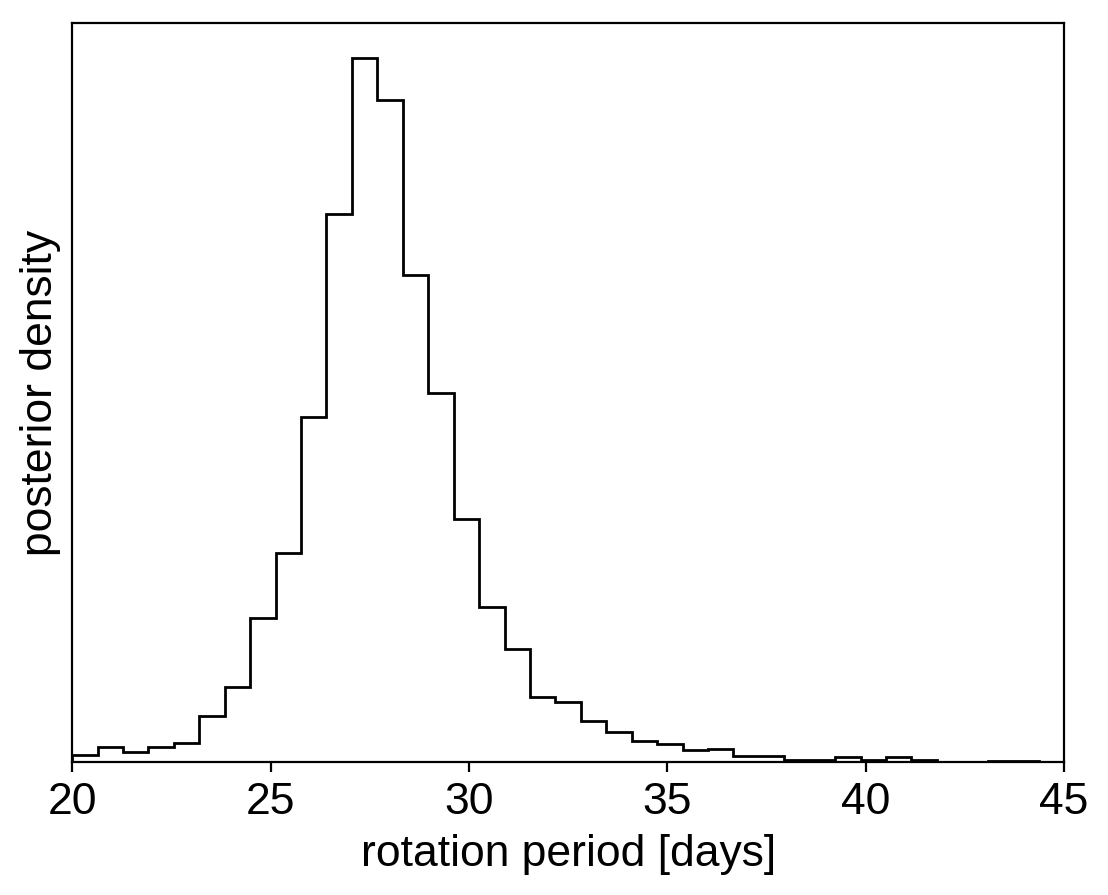

In [9]:
period_samples = trace["period"]
bins = np.linspace(20, 45, 40)
plt.hist(period_samples, bins, histtype="step", color="k")
plt.yticks([])
plt.xlim(bins.min(), bins.max())
plt.xlabel("rotation period [days]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [10]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:exoplanet, exoplanet:foremanmackey17,
exoplanet:foremanmackey18, exoplanet:pymc3, exoplanet:theano}.


In [11]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.2.1},
   month = sep,
    year = 2019,
     doi = {10.5281/zenodo.3462740},
     url = {https://doi.org/10.5281/zenodo.3462740}
}
...
